# Mixture Model with Likelihood 2 and Synth data

**this notebook works with .venv2 and uses the new lymph package**

In this notebook i will use the new forked model and try to adapt it to handel the mixture model likelihoood as described below. 


The steps should roughly look like this:
1. Create the datasets (simple, graph_lnlT1T2)
2. Create the model with the new lymph package
3. Implement the likelihood in the model
4. Check if the likelihood works by using model.likelihood(params, Pi).
5. Use ML estimation to show the true mixture component
6. Use MC sampling to show problem of degeneration
7. Either reduce the degree of freedom in the sampling space, or implement the EM algortihm


I implemented the EM algortihm.

After i used the data S1 S2 S3 again (real data) to check wheter the results make sense:
Outcome: 
- Good results, Proof of concept
- smooothening of certain edges in prevalences 


Next steps are in mm_expl_oc_hp.ipynb




from util import 3

In [28]:
# Reload the modules on kernel restart
%load_ext autoreload
%autoreload 2
from util_2 import create_synth_data, create_prev_vectors, late_binomial, set_size
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import lymph
from lyscripts.predict.prevalences import compute_observed_prevalence, compute_predicted_prevalence, generate_predicted_prevalences
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/juli/Studium/Master/FS23/masterthesis/code/msth_lysubsite/styles/mplstyle_rl.txt')
from pathlib import Path
import corner 
import warnings
from scipy.special import factorial
from scipy.optimize import minimize
import sys
from cycler import cycler
PLOT_PATH = Path("./figures/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of functools failed: Traceback (most recent call last):
  File "/Users/juli/Studium/Master/FS23/masterthesis/code/msth_lysubsite/.venv2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/juli/Studium/Master/FS23/masterthesis/code/msth_lysubsite/.venv2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/juli/Studium/Master/FS23/masterthesis/code/msth_lysubsite/.venv2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/juli/Studium/Master/FS23/masterthesis/code/msth_lysubsite/.venv2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/juli/Studium/Master/FS23/masterthesis/code/msth_lysubsite/.venv2/lib/python3.11/site-packages/IPython/extensions/

In [29]:
# Plotting styles
usz_blue = "#005ea8"
usz_blue_border = "#2387D5"
usz_green = "#00afa5"
usz_green_border = "#30DFD5"
usz_red = "#ae0060"
usz_red_border = "#FB4EAE"
usz_orange = "#f17900"
usz_orange_border = "#F8AB5C"
usz_gray = "#c5d5db"
usz_gray_border = "#DFDFDF"
#sn.set_theme()
COLORS = {
    "blue": '#005ea8',
    "orange": '#f17900',
    "green": '#00afa5',
    "red": '#ae0060',
    "gray": '#c5d5db',
}
colors = [usz_blue, usz_green, usz_red, usz_orange, usz_gray]
edge_colors = [usz_blue_border, usz_green_border, usz_red_border, usz_orange_border, usz_gray_border]


In [30]:
from util_2 import create_synth_data, create_models, create_prev_vectors, late_binomial

In [7]:
# Some function definitions

def binom_pmf(k: np.ndarray, n: int, p: float):
    """Binomial PMF"""
    if p > 1. or p < 0.:
        raise ValueError("Binomial prob must be btw. 0 and 1")
    q = (1. - p)
    binom_coeff = factorial(n) / (factorial(k) * factorial(n - k))
    return binom_coeff * p**k * q**(n - k)

def late_binomial(support: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Parametrized binomial distribution."""
    return binom_pmf(k=support, n=support[-1], p=p)

def create_models(n, graph=None, include_late=True,ignore_t_stage=False, n_mixture_components = 1):
    if graph is None:
        graph = {
            ("tumor", "primary"): ["I", "II", "III", "IV"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): ["IV"],
            ("lnl", "IV"): [],
        }

    diagnostic_spsn = {
        "max_llh": [1.0, 1.0],
    }

    max_t = 10
    first_binom_prob = 0.3

    models = []
    for i in range(n):
        model = lymph.models.Unilateral.binary(graph_dict=graph)
        model.modalities = diagnostic_spsn

        max_time = model.max_time
        time_steps = np.arange(max_time + 1)
        p = 0.3

        if ignore_t_stage:
            early_prior = sp.stats.binom.pmf(time_steps, max_time, p)
            model.diag_time_dists["all"] = early_prior
        else:
            early_prior = sp.stats.binom.pmf(time_steps, max_time, p)
            model.diag_time_dists["early"] = early_prior
            if include_late:
                model.diag_time_dists["late"] = late_binomial
        model.n_mixture_components = n_mixture_components
        models.append(model)
    if n > 1:
        return models
    else:
        return models[0]


def create_prev_vectors(data, lnls, plot=False, title=None, save_figure=False, ax=None):
    states_all_raw = [
        list(combination) for combination in itertools.product([0, 1], repeat=len(lnls))
    ]
    states_all = [
        {lnls[-(i + 1)]: p[i] for i in range(len(lnls))} for p in states_all_raw
    ]
    t_stages = ["early", "late"]
    X_inv_list = []
    for state in states_all:
        # sys.stdout.write(f"\r State: {state}")
        inv, nd = 0, 0
        for t_stage in t_stages:
            observed_prevalence_result = compute_observed_prevalence(
                pattern={"ipsi": state},
                data=data,
                t_stage=t_stage,
                lnls=lnls,
            )
            inv += observed_prevalence_result[0]
            nd += observed_prevalence_result[1]
        X_inv_list.append((inv / nd) if nd != 0 else 0)

    if plot:
        if ax is None:
            fig, ax = plt.subplots(1, figsize=set_size("full"))

        ax.barh(range(len(X_inv_list)), width=X_inv_list)
        maxx = max(X_inv_list)
        ax.set_title(
            f"{title} (n = {len(data)})"
        )  # Adjust title properties

        ax.set_yticks(range(len(X_inv_list)), [str(s) for s in states_all_raw])
        ax.tick_params(axis="x", which="both")
        if save_figure:
            fig.savefig(PLOT_PATH / f"prev_vectors_{title}_{str(lnls)}.svg")
        if ax is None:
            plt.show()
    if len(states_all)>4:
        print(f"Prev Vector: {X_inv_list}")
    else:
        prev_formatted = "".join(f"{l}: {p}" for l, p in zip(states_all, X_inv_list))
        print(f"Prev Vector: {prev_formatted}")
    return X_inv_list


def create_synth_data(
    params_0, params_1, n, ratio, graph, t_stage_dist=None, header="Default"
):
    gen_model = create_models(1, graph=graph)
    gen_model.assign_params(*params_0)
    data_synth_s0_30 = gen_model.generate_dataset(
        int(n * ratio), t_stage_dist, column_index_levels=header
    )
    gen_model.assign_params(*params_1)
    data_synth_s1_30 = gen_model.generate_dataset(
        int(n * (1 - ratio)), t_stage_dist, column_index_levels=header
    )

    data_synth_s2 = pd.concat([data_synth_s0_30, data_synth_s1_30], ignore_index=True)
    return data_synth_s2

def convert_params(params, n_clusters, n_subsites):
    n_mixing = (n_clusters-1)* (n_subsites) 
    p_mixing = params[-n_mixing:]
    p_model = params[:-n_mixing]
    params_model = [[params[i+j] for j in range(n_clusters)] for i in range(0, len(p_model), n_clusters)]

    params_mixing = [[p_mixing[i+j] for j in range(n_clusters - 1)] for i in range(0, len(p_mixing), n_clusters-1)]
    params_mixing = [[*mp, 1-np.sum(mp)] for mp in params_mixing]
    return params_model, params_mixing

import emcee
import multiprocess as mp
import os

def emcee_sampling(llh_function, n_params, sample_name, llh_args=None):

    nwalkers, nstep, burnin = 20*n_params, 1000, 1500
    thin_by = 1
    print(f"Dimension: {n_params} with n walkers: {nwalkers}")
    output_name = sample_name

    if False:
        samples = np.load("samples/"+output_name+".npy")
    else:
        created_pool = mp.Pool(os.cpu_count())
        with created_pool as pool:
            starting_points = np.random.uniform(size=(nwalkers, n_params))
            print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
            burnin_sampler = emcee.EnsembleSampler(
                nwalkers,
                n_params,
                llh_function,
                args=llh_args,
                pool=pool,
            )
            burnin_results = burnin_sampler.run_mcmc(
                initial_state=starting_points, nsteps=burnin, progress=True
            )
            
            ar = np.mean(burnin_sampler.acceptance_fraction)
            print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
            last_sample = burnin_sampler.get_last_sample()[0]
            print(f"The shape of the last sample is {last_sample.shape}")
            starting_points = np.random.uniform(size=(nwalkers, n_params))
            original_sampler_mp = emcee.EnsembleSampler(
                nwalkers,
                n_params,
                llh_function,
                args=llh_args,
                backend=None,
                pool=pool,
            )
            sampling_results = original_sampler_mp.run_mcmc(
                initial_state=last_sample, nsteps=nstep, progress=True, thin_by = thin_by
            )

        ar = np.mean(original_sampler_mp.acceptance_fraction)
        print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
        samples = original_sampler_mp.get_chain(flat=True)
        np.save(f"./samples/" + output_name, samples)
        # plots["acor_times"].append(burnin_info["acor_times"][-1])
        # plots["accept_rates"].append(burnin_info["accept_rates"][-1])
    return samples

def emcee_sampling_ext(llh_function, n_params = None, sample_name = None, n_burnin = None, n_step = None, start_with = None, skip_burnin = False, llh_args=None):

    nwalkers = 20*n_params
    burnin = 1000 if n_burnin is None else n_burnin
    nstep = 1000 if n_step is None else n_step
    thin_by = 1
    print(f"Dimension: {n_params} with n walkers: {nwalkers}")
    output_name = sample_name

    if False:
        samples = np.load("samples/"+output_name+".npy")
    else:
        created_pool = mp.Pool(os.cpu_count())
        with created_pool as pool:
            if start_with is None:
                starting_points = np.random.uniform(size=(nwalkers, n_params))
            else:
                if np.shape(start_with) != np.shape(np.random.uniform(size=(nwalkers, n_params))):
                    starting_points = np.tile(start_with, (nwalkers, 1))
                else:
                    starting_points = start_with
            print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
            burnin_sampler = emcee.EnsembleSampler(
                nwalkers,
                n_params,
                llh_function,
                args=llh_args,
                pool=pool,
            )
            burnin_results = burnin_sampler.run_mcmc(
                initial_state=starting_points, nsteps=burnin, progress=True
            )
            
            ar = np.mean(burnin_sampler.acceptance_fraction)
            print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
            starting_points = burnin_sampler.get_last_sample()[0]
            # print(f"The shape of the last sample is {starting_points.shape}")
            original_sampler_mp = emcee.EnsembleSampler(
                nwalkers,
                n_params,
                llh_function,
                args=llh_args,
                backend=None,
                pool=pool,
            )
            sampling_results = original_sampler_mp.run_mcmc(
                initial_state=starting_points, nsteps=nstep, progress=True, thin_by = thin_by
            )

        ar = np.mean(original_sampler_mp.acceptance_fraction)
        print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
        samples = original_sampler_mp.get_chain(flat=True)
        log_probs = original_sampler_mp.get_log_prob(flat=True)
        end_point = original_sampler_mp.get_last_sample()[0]
        if output_name is not None:
            np.save(f"./samples/" + output_name, samples)
        # plots["acor_times"].append(burnin_info["acor_times"][-1])
        # plots["accept_rates"].append(burnin_info["accept_rates"][-1])
    return samples, end_point, log_probs


In [8]:



graph_lnl_I_II = {
            ("tumor", "primary"): ["I", "II"],
            ("lnl", "I"): [],
            ("lnl", "II"): [],
        }

lnls = ['I', 'II']


n_D1 = 500  
n_D2 = 500
n_D12 = 500
r_12 = 0.4 # means 60% D2 and 40% D1 patients.

# Wheter we want the model to incorprate t-catergory late.
include_late = False

# Define spread prob. for HMM model 
params_d1 = [0.4, 0.0]
params_d2 = [0.0, 0.6]

t_dist = {'early': 1, 'late': 0}


# params_d1 = [0.6, 0.0, 0.05, 0.01, 0.1, 0.5]
# params_d2 = [0.0, 0.6, 0.05, 0.01, 0.1, 0.5]
# params_s2 = [0.2, 0.02, 0.05, 0.00, 0.1, 0.5]

data_synth_D1 = create_synth_data(params_d1, params_d2, n_D1, 1, graph_lnl_I_II, t_dist, header="nd")
data_synth_D2 = create_synth_data(params_d1, params_d2, n_D2, 0, graph_lnl_I_II, t_dist, header="nd")
data_synth_D12 = create_synth_data(params_d1, params_d2, n_D12, r_12, graph_lnl_I_II, t_dist, header="nd")

data_synth = {'D1': data_synth_D1, 'D2': data_synth_D2, 'D12': data_synth_D12}
data_synth_D1.head(5)


mixture_labels = np.array([[r"$\pi_{D1, 0}$", r"$\pi_{D1, 1}$"], 
                  [r"$\pi_{D2, 0}$", r"$\pi_{D2, 1}$"],
                  [r"$\pi_{D12, 0}$", r"$\pi_{D12, 1}$"]])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Prev Vector: {'II': False, 'I': False}: 0.25{'II': False, 'I': True}: 0.75{'II': True, 'I': False}: 0.0{'II': True, 'I': True}: 0.0
Prev Vector: {'II': False, 'I': False}: 0.126{'II': False, 'I': True}: 0.0{'II': True, 'I': False}: 0.874{'II': True, 'I': True}: 0.0
Prev Vector: {'II': False, 'I': False}: 0.168{'II': False, 'I': True}: 0.302{'II': True, 'I': False}: 0.53{'II': True, 'I': True}: 0.0


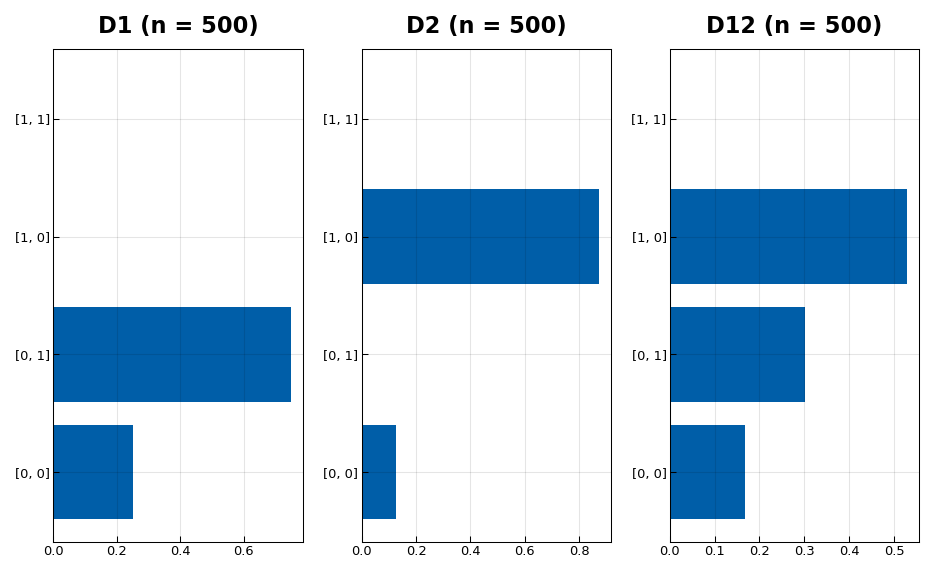

In [ ]:
# Check that the data is correct
fig, ax = plt.subplots(1, 3, figsize= set_size(width='full'), tight_layout = True)
create_prev_vectors(data_synth_D1, lnls, plot=True, title='D1', ax = ax[0])
create_prev_vectors(data_synth_D2, lnls, plot=True, title='D2', ax = ax[1])
create_prev_vectors(data_synth_D12, lnls, plot=True, title='D12', ax = ax[2])
plt.show()
fig.savefig(PLOT_PATH / "prevalence_d1d2d12_r04.svg")

## Implement the mixture model
We have set the true mixture component to 0.4.
The model should be able to estimate this mixture component, if we only have patients from D12, and we only sample the mixture component with the spreading parameters fixed.

In [ ]:
from scipy.optimize import minimize
global MODEL

# Create the model and add the patient data
model = create_models(1, graph_lnl_I_II, include_late=False)
#odel.diag_time_dists["late"] = late_binomial
# model.load_patient_data(data_synth_D1, side='ipsi')
model.load_patient_data(data_synth_D12, side='ipsi')
params_mixture = [[params_d1[i], params_d2[i]] for i in range(len(params_d1))]
model.assign_params(*params_mixture)
model.n_mixture_components = 2
MODEL = model

In [9]:
def llh(param, model):
    model.mixture_components= [param[0], 1-param[0]]
    return - model._hmm_likelihood(True)

def llh2(param, model, pd1, pd2):
    log_sum_0 = -np.inf
    log_sum_1 = -np.inf
    if param != 0:
        log_sum_0 = np.log(param) + model.likelihood(given_param_args=pd1, log = True)
    if (1-param) != 0:
        log_sum_1 = np.log(1-param) + model.likelihood(given_param_args=pd2, log = True)

    log_sum = np.logaddexp(log_sum_0, log_sum_1)
    return - log_sum


In [10]:
bounds = [(0.1,0.9)]
initial_guess = [0.3]

res = minimize(llh, initial_guess, args = model, bounds = bounds, method='L-BFGS-B')
print(f"For D1: pi_0 = {np.round(res.x[0], 2)}, pi_1 = {np.round(1-res.x[0], 2)}")


NameError: name 'model' is not defined

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Lucida Calligraphy
findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'monospace' not found because none of the following families were found: Ubuntu Mono


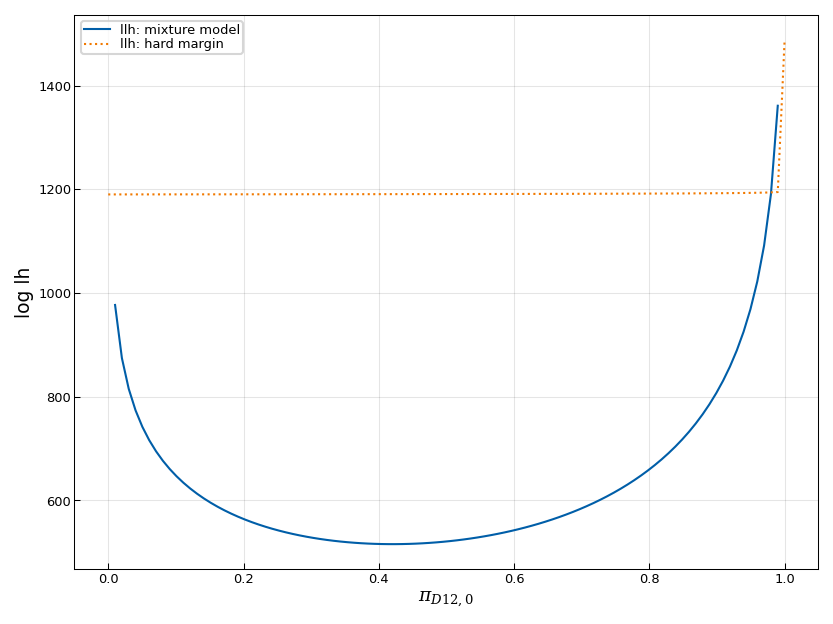

In [13]:
### Compare to the other likelihood (hard margin)
pd1 = [p+0.01 for p in params_d1]
pd2 = [p+0.01 for p in params_d2]

model_l2 = create_models(1, graph_lnl_I_II, include_late=False)
model_l2.load_patient_data(data_synth_D12, side ='ipsi')



xs = np.linspace(0,1,100)
y1 = [llh([x], model) for x in xs]
y2 = [llh2(x, model_l2, pd1, pd2) for x in xs]
plt.plot(xs, y1, label = 'llh: mixture model')
plt.plot(xs, y2, linestyle = 'dotted', label = 'llh: hard margin' )
plt.xlabel(r'$\pi_{D12,0}$')
plt.ylabel('log lh')
plt.legend()
plt.savefig(PLOT_PATH / "llh_12_d12_r04.svg")
plt.show()


We see that the implemented likelihood can succesfully extract the mixture component in our data. Whereas the old likelihood (hard marging) assigns the data to the component which describes the data better.

## Use MLE to estimate all parameters, expand the likelihood functions



define the structure of the sampled parameters like this, e.g. we have a model with b1, b2, t12, p_late, and we have 2 clusters, the parameters are passed like this:
params = (b11, b12, b21, b22, t121, t122, p_s1c1, p_s1c2, ps2cl1, ps2cl2)

In [7]:
from scipy.optimize import minimize
global MODELS

In [8]:

def llh_2_cluster(params, n_clusters):
    global MODELS
    model_params, mixing_params = convert_params(params, n_clusters, len(MODELS))

    log_sum = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = mixing_params[i]
        log_sum += model.likelihood(given_param_args = model_params, log = True)
    if np.isnan(log_sum):
        log_sum = 10000

    if np.isinf(log_sum):
        log_sum = 10000
    return -log_sum
    



In [139]:
# set up the model
n_subsites = 1
n_components = 2


# Create the model and add the patient data
model = create_models(n_subsites, graph_lnl_I_II, include_late=False)
#odel.diag_time_dists["late"] = late_binomial
# model.load_patient_data(data_synth_D1, side='ipsi')
model.load_patient_data(data_synth_D12, side='ipsi')
MODELS = [model]
model.n_mixture_components = n_components

In [140]:
n_params_cluster = len(model.get_params())
n_params = n_params_cluster *n_components + (n_subsites * (n_components -1))

bounds = [(0.001,0.99999)]
initial_guess = [0.5 for i in range(n_params) ]


In [143]:

res = minimize(llh_2_cluster, initial_guess, args = n_components, bounds = bounds, method='L-BFGS-B')


In [153]:
print(
    f"MLE: b1_a = {res.x[0]:.2f}, b2_a = {res.x[1]:.2f}, b1_b = {res.x[2]:.2f}, b2_b = {res.x[3]:.2f}, pi_12_a = {res.x[4]:.2f}"
)

MLE: b1_a = 0.10, b2_a = 0.10, b1_b = 0.22, b2_b = 0.22, pi_12_a = 0.50


In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Define a grid of parameter values
x_values = np.linspace(0.001, 0.999, 30)  # 100 points between 0 and 1 for the first parameter
y_values = np.linspace(0.001, 0.999, 30)  # 100 points between 0 and 1 for the second parameter

# Create a meshgrid from the parameter values
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Calculate the likelihood for each combination of parameter values
likelihood_values = np.zeros_like(x_grid)

for i in range(len(x_values)):
    for j in range(len(y_values)):
        params = [x_values[i], 0, 0, y_values[j], 0.5]
        likelihood_values[i][j] = llh_2_cluster(params, n_components)  # Replace with your likelihood function


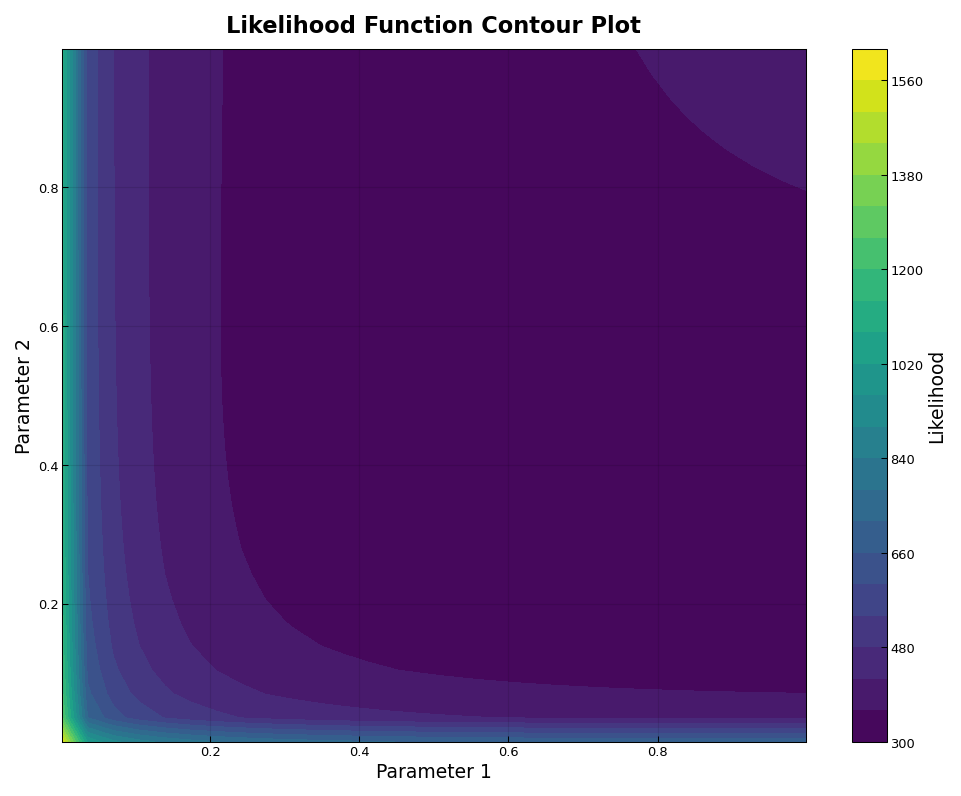

In [161]:
# Create a contour plot of the likelihood function
plt.figure(figsize=(8, 6))
contour = plt.contourf(x_grid, y_grid, likelihood_values, cmap='viridis', levels = 20)
plt.colorbar(contour, label='Likelihood')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('Likelihood Function Contour Plot')
plt.grid(True)
plt.show()

We see that somehow it does not work! Is it because it's degeneratred?

### D1, D2, D12: Estimate all parameters but fix D1 and D2

In [9]:
n_subsites = 3
n_clusters = 2


In [18]:
models = create_models(3, graph_lnl_I_II, include_late=False, n_mixture_components=n_clusters )
for i, (k,v) in enumerate(data_synth.items()):
    models[i].load_patient_data(v, side='ipsi')
MODELS = models

In [45]:
def extend_params_fix_d1d2(params):
    if isinstance(params, list):
        params.insert(-1, 1)
        params.insert(-1, 0)
    else:
        params = np.insert(params, -1, 1)
        params = np.insert(params, -1, 0)

    return params
    
def llh_2_cluster_fix_d1d2(params, n_clusters=2):
    global MODELS
    params = extend_params_fix_d1d2(params)
    model_params, mixing_params = convert_params(params, n_clusters, len(MODELS))

    log_sum = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = mixing_params[i]
        log_sum += model.likelihood(given_param_args = model_params, log = True)
    if np.isnan(log_sum):
        log_sum = -10000

    if np.isinf(log_sum):
        log_sum = -10000
    return log_sum

In [48]:
# check if likelihood works
params = np.array([0.4, 0.1, 0.1, 0.6, 1. ])
llh_2_cluster_fix_d1d2(params)

In [63]:
n_params_base = len(MODELS[0].get_params())
n_params_model = n_clusters * n_params_base + n_subsites * (n_clusters - 1)
n_params = n_params_model - 2 # since we fix d1 to component 1 and d2 to component 2 

In [29]:
sample_name = "samples_mixture_synth_d1_d2_d12_r04_fix_d1d2_T1T2"
sampling = False

In [31]:
if sampling:
    samples_fix_d1d2 = emcee_sampling(llh_2_cluster_fix_d1d2, n_params, sample_name)
else:
    samples_fix_d1d2 = np.load("samples/"+sample_name+".npy")

#### Inspect the samples

In [233]:
# Add the params for the fixed clusters
if n_params_model > np.shape(samples_m_01)[1]:
    samples_m_01_model = np.insert(samples_m_01, -1, np.array([1]*len(samples_m_01)) + (0.001 if np.random.randint(0,1000)<999 else 0), axis = 1)
    samples_m_01_model = np.insert(samples_m_01, -1, np.array([0]*len(samples_m_01)) + (0.001 if np.random.randint(0,1000)<999 else 0), axis = 1)

In [234]:
# Extract cluster parameters
samples_cl0 = samples_m_01_model[:, [0,2,4,5,6]]
samples_cl1 = samples_m_01_model[:, [1,3]]


In [235]:
# Add the mixture parameter which is not samples due to constraint
samples_cl1 = np.hstack((samples_cl1, (1-samples_cl0[:, -3]).reshape(-1, 1)))
samples_cl1 = np.hstack((samples_cl1, (1-samples_cl0[:, -2]).reshape(-1, 1)))
samples_cl1 = np.hstack((samples_cl1, (1-samples_cl0[:, -1]).reshape(-1, 1)))


In [236]:
mixture_labels = np.array([[r"$\pi_{D1, 0}$", r"$\pi_{D1, 1}$"], 
                  [r"$\pi_{D2, 0}$", r"$\pi_{D2, 1}$"],
                  [r"$\pi_{D12, 0}$", r"$\pi_{D12, 1}$"]])

In [237]:
model_labels_cl0 = ["T->I", "T->II", *mixture_labels[:, 0]]
model_labels_cl1 = ["T->I", "T->II", *mixture_labels[:, 1]]

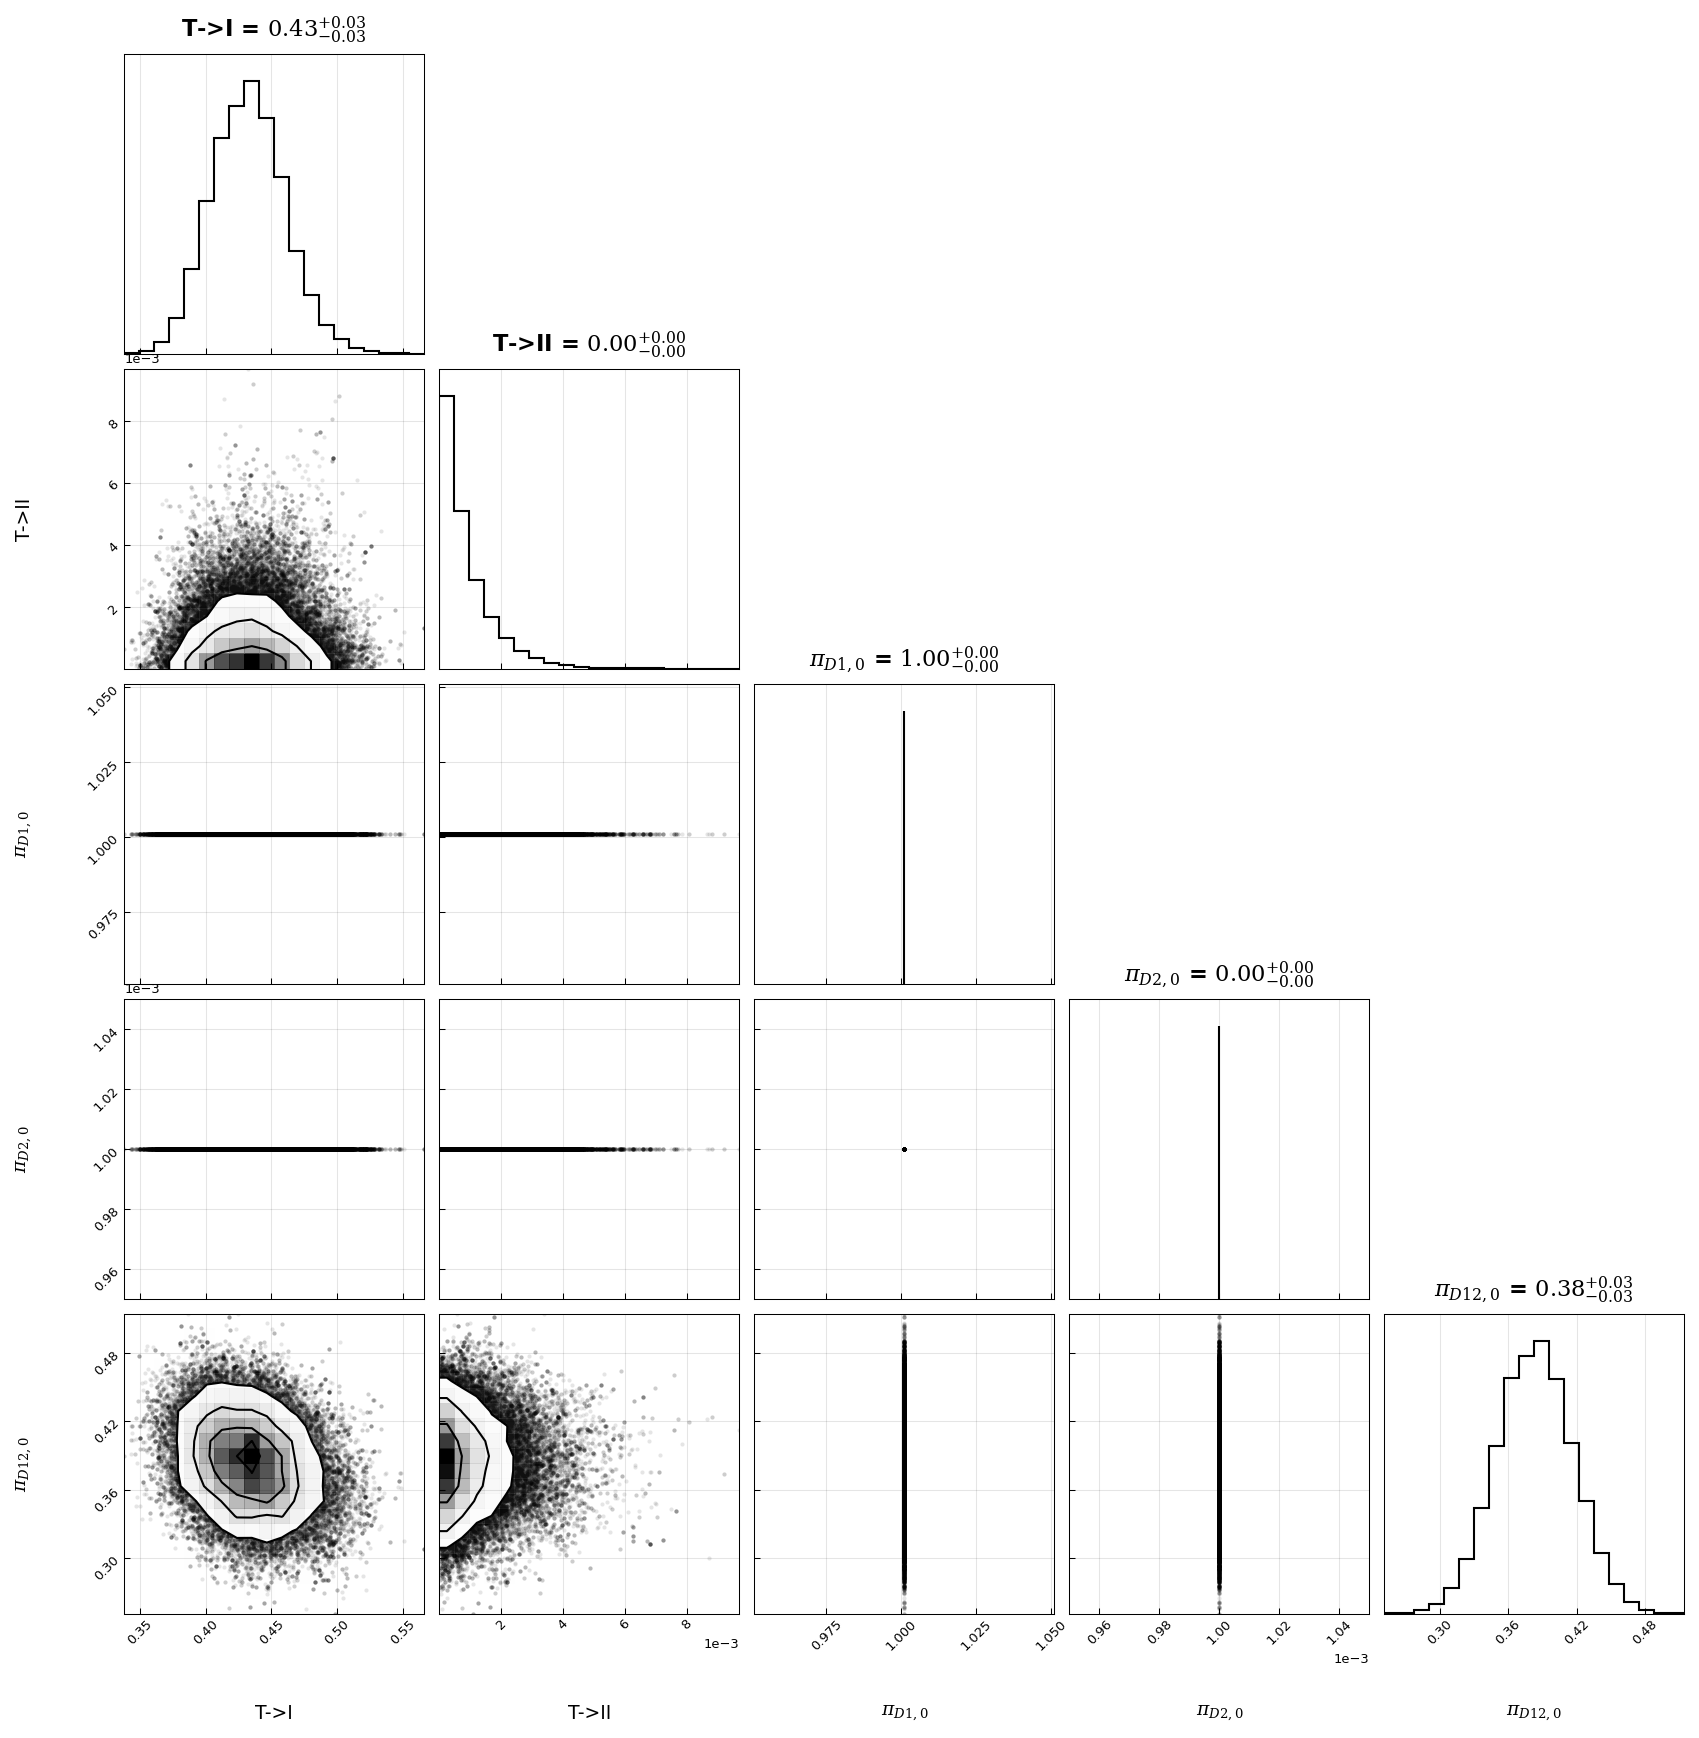

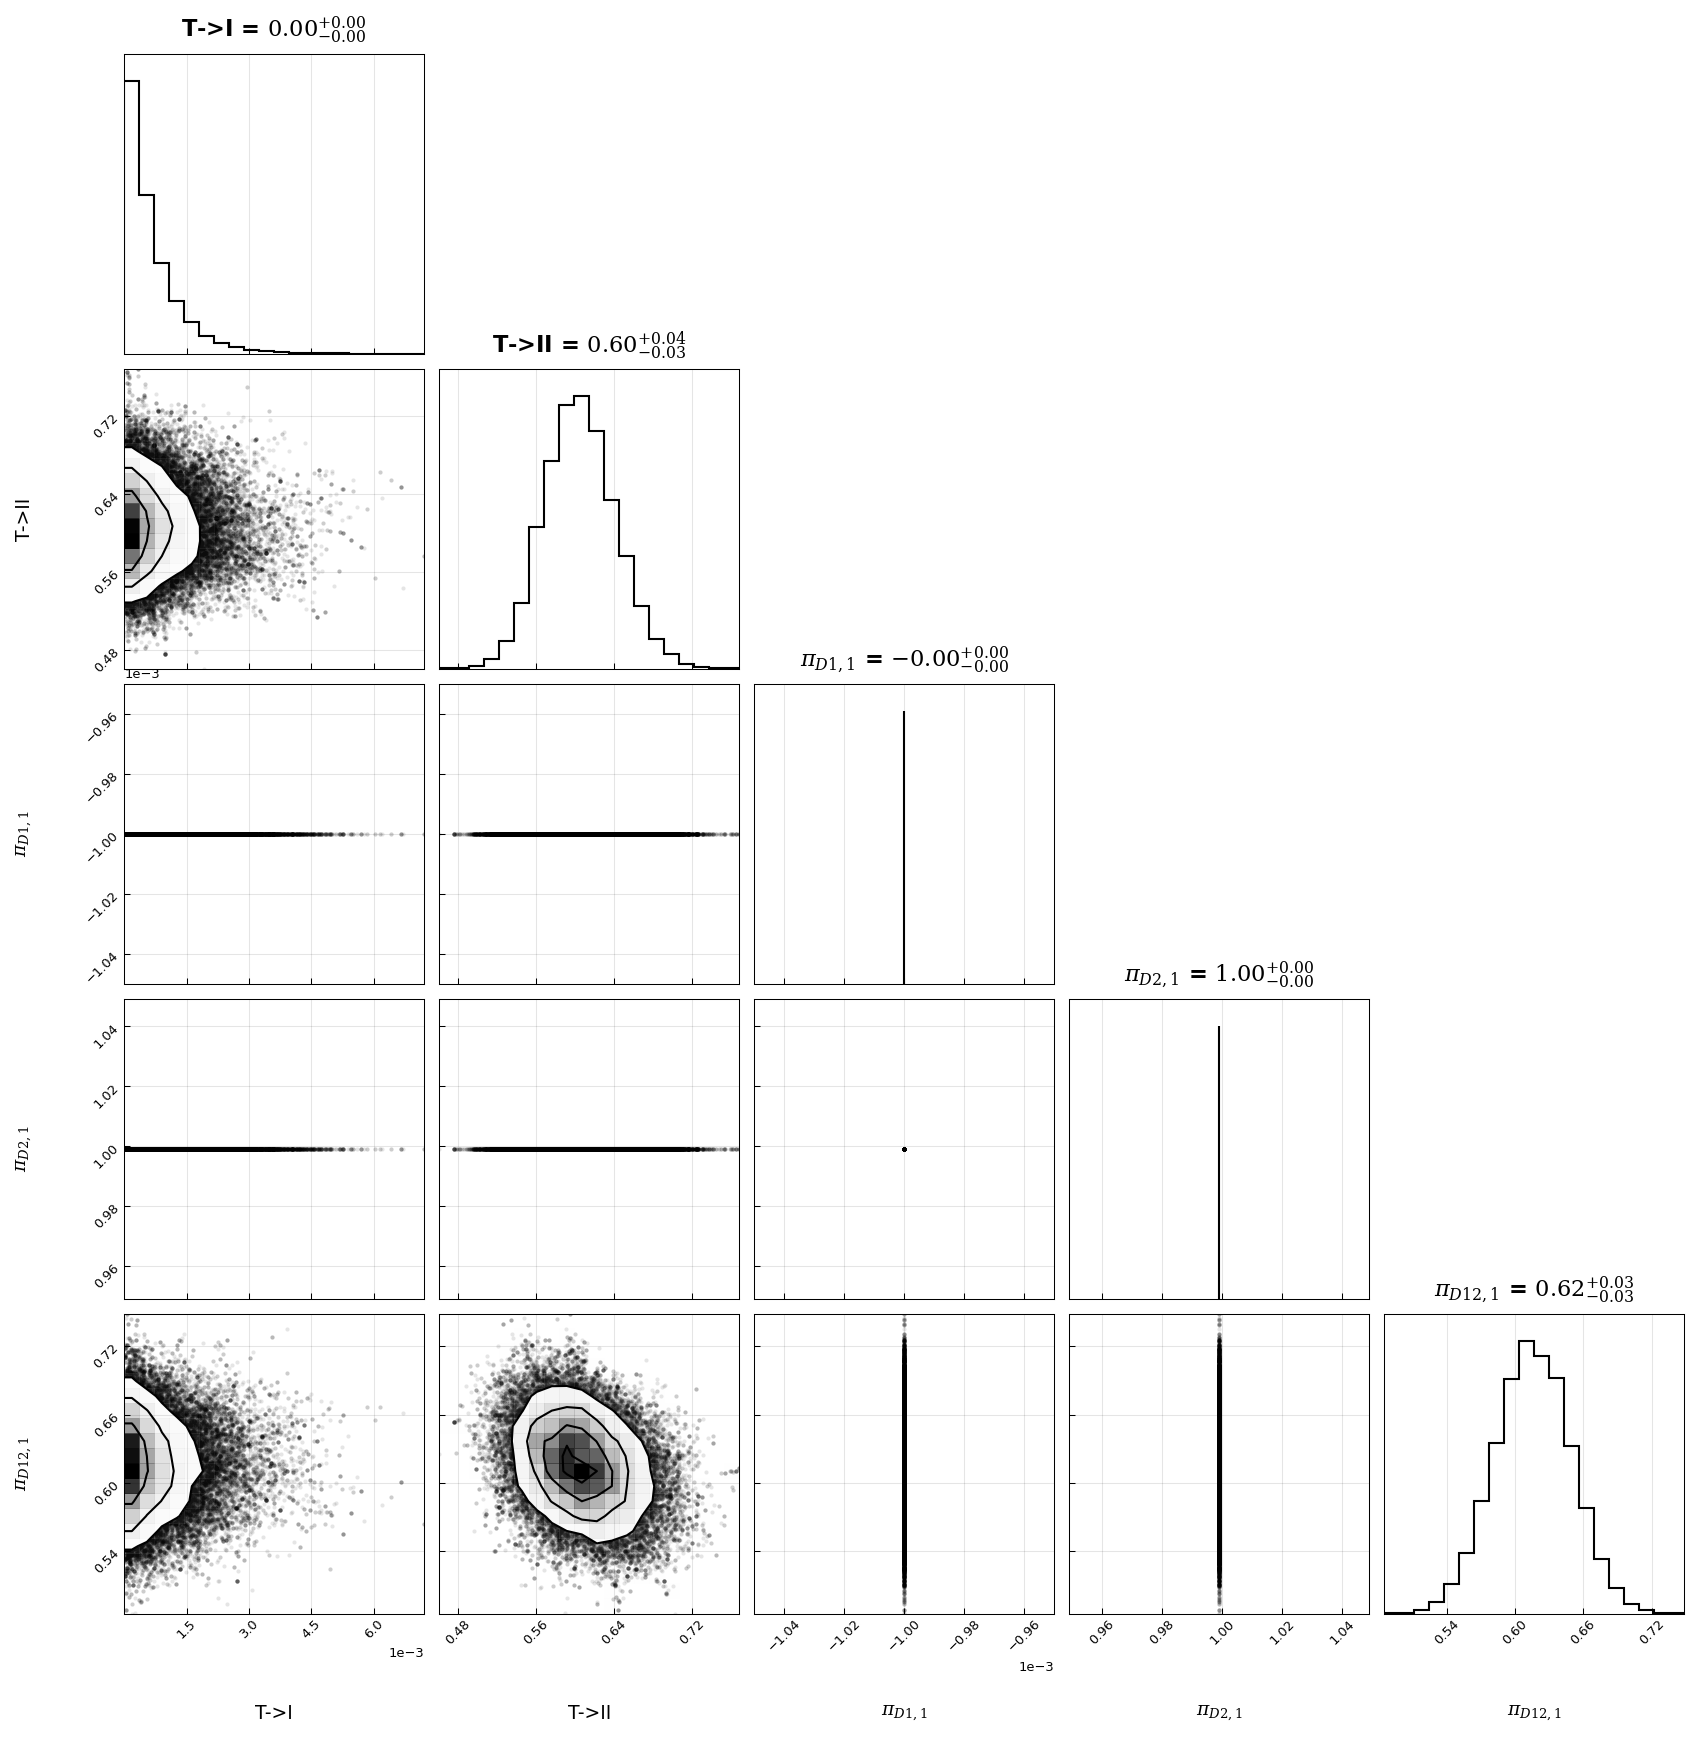

In [239]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.simplefilter("ignore")
    if True:
        fig = corner.corner(
            samples_cl0,
            labels=model_labels_cl0,
            show_titles=True,
        )
        plt.show()
        fig.savefig(PLOT_PATH / "corner_cl0_synth_d1_d2_d12_r04_fix_d1d2_T1T2.svg")

        fig = corner.corner(
            samples_cl1,
            labels=model_labels_cl1,
            show_titles=True,
        )
        plt.show()
        fig.savefig(PLOT_PATH / "corner_cl1_synth_d1_d2_d12_r04_fix_d1d2_T1T2.svg")

### Is sampling all the parameters possible?

In [415]:
# Definitions and create and load the model
n_subsites = 3
n_clusters = 2

models = create_models(n_subsites, graph_lnl_I_II, include_late=False, n_mixture_components=n_clusters )
for i, (k,v) in enumerate(data_synth.items()):
    models[i].load_patient_data(v, side='ipsi')
MODELS = models

In [249]:
def llh_2_cluster(params, n_clusters=2):
    global MODELS

    # Check constraints: 
    for x in params[-(n_clusters-1)* (n_subsites):]:
        if x<0 or x>1:
            return -10000
    model_params, mixing_params = convert_params(params, n_clusters, len(MODELS))
    log_sum = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = mixing_params[i]
        log_sum += model.likelihood(given_param_args = model_params, log = True)
    if np.isnan(log_sum):
        log_sum = -10000

    if np.isinf(log_sum):
        log_sum = -10000
    return log_sum

In [417]:
# Number of parameters 
n_params_base = len(MODELS[0].get_params())
n_params_model = n_clusters * n_params_base + n_subsites * (n_clusters - 1)
n_params = n_params_model 

#and check that llh works

params = [0.4, 0.01, 0.01, 0.6, 1, 0, 0.4]
assert len(params) == n_params
llh_2_cluster(params)

-624.7942268999047

In [283]:
sample_name = "samples_mixture_synth_d1_d2_d12_r04_T1T2"
sampling = False

if sampling:
    samples_d1d2d12 = emcee_sampling(llh_2_cluster, n_params, sample_name)
else:
    samples_d1d2d12 = np.load("samples/"+sample_name+".npy")

In [284]:
# Extract cluster parameters
samples_cl0 = samples_d1d2d12[:, [0,2,4,5,6]]
samples_cl1 = samples_d1d2d12[:, [1,3]]

# Add the mixture parameter which is not samples due to constraint
samples_cl1 = np.hstack((samples_cl1, (1-samples_cl0[:, -3]).reshape(-1, 1)))
samples_cl1 = np.hstack((samples_cl1, (1-samples_cl0[:, -2]).reshape(-1, 1)))
samples_cl1 = np.hstack((samples_cl1, (1-samples_cl0[:, -1]).reshape(-1, 1)))

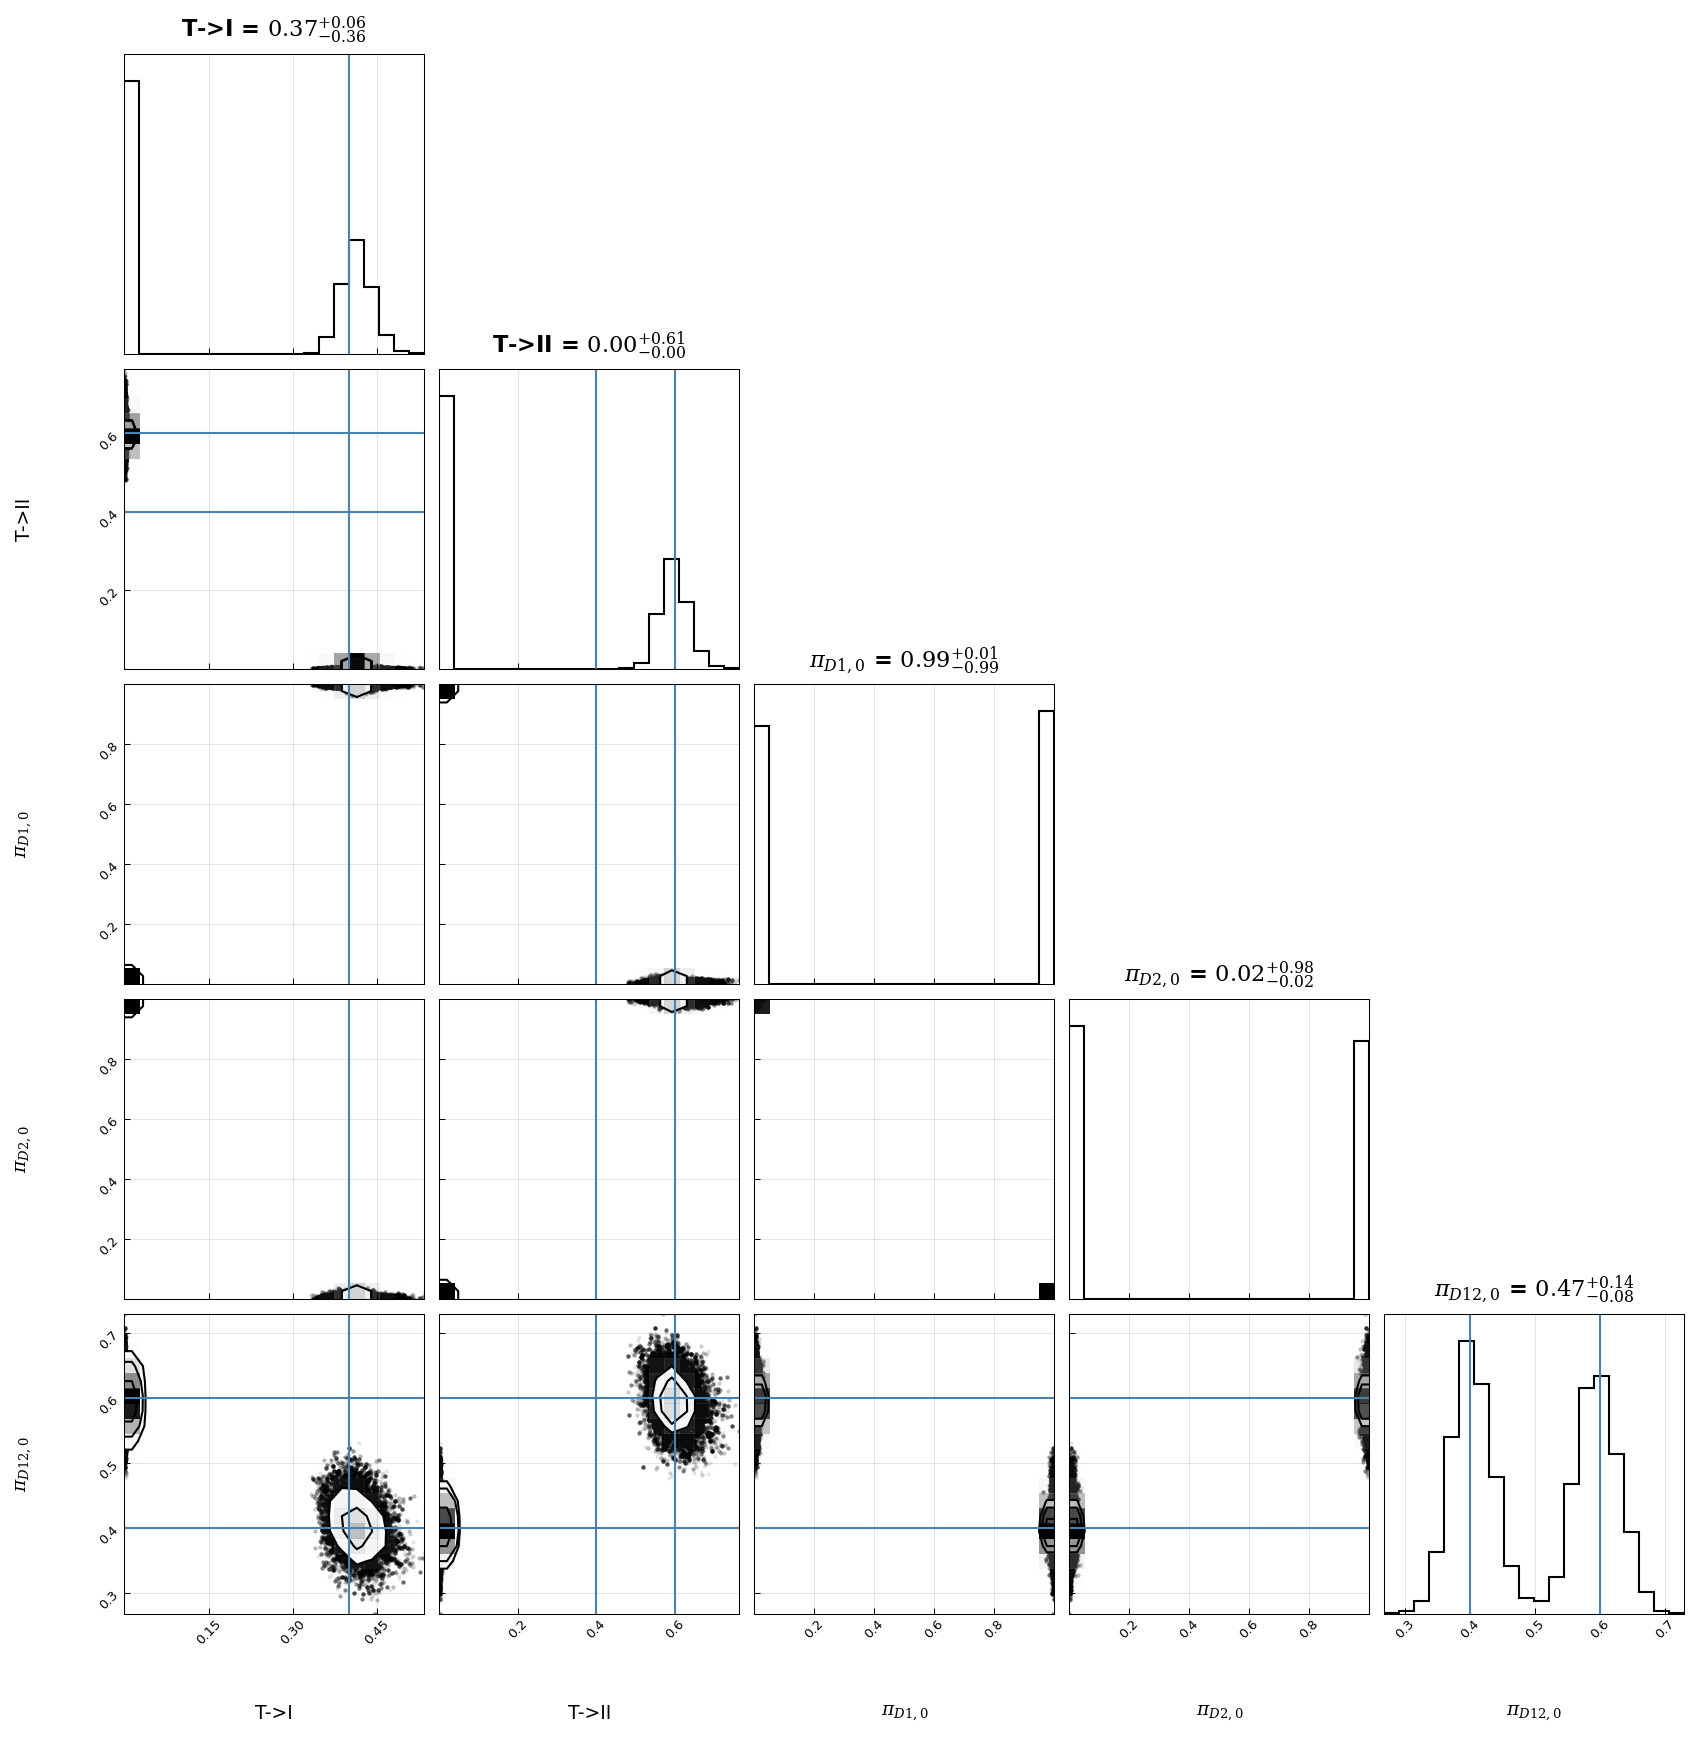

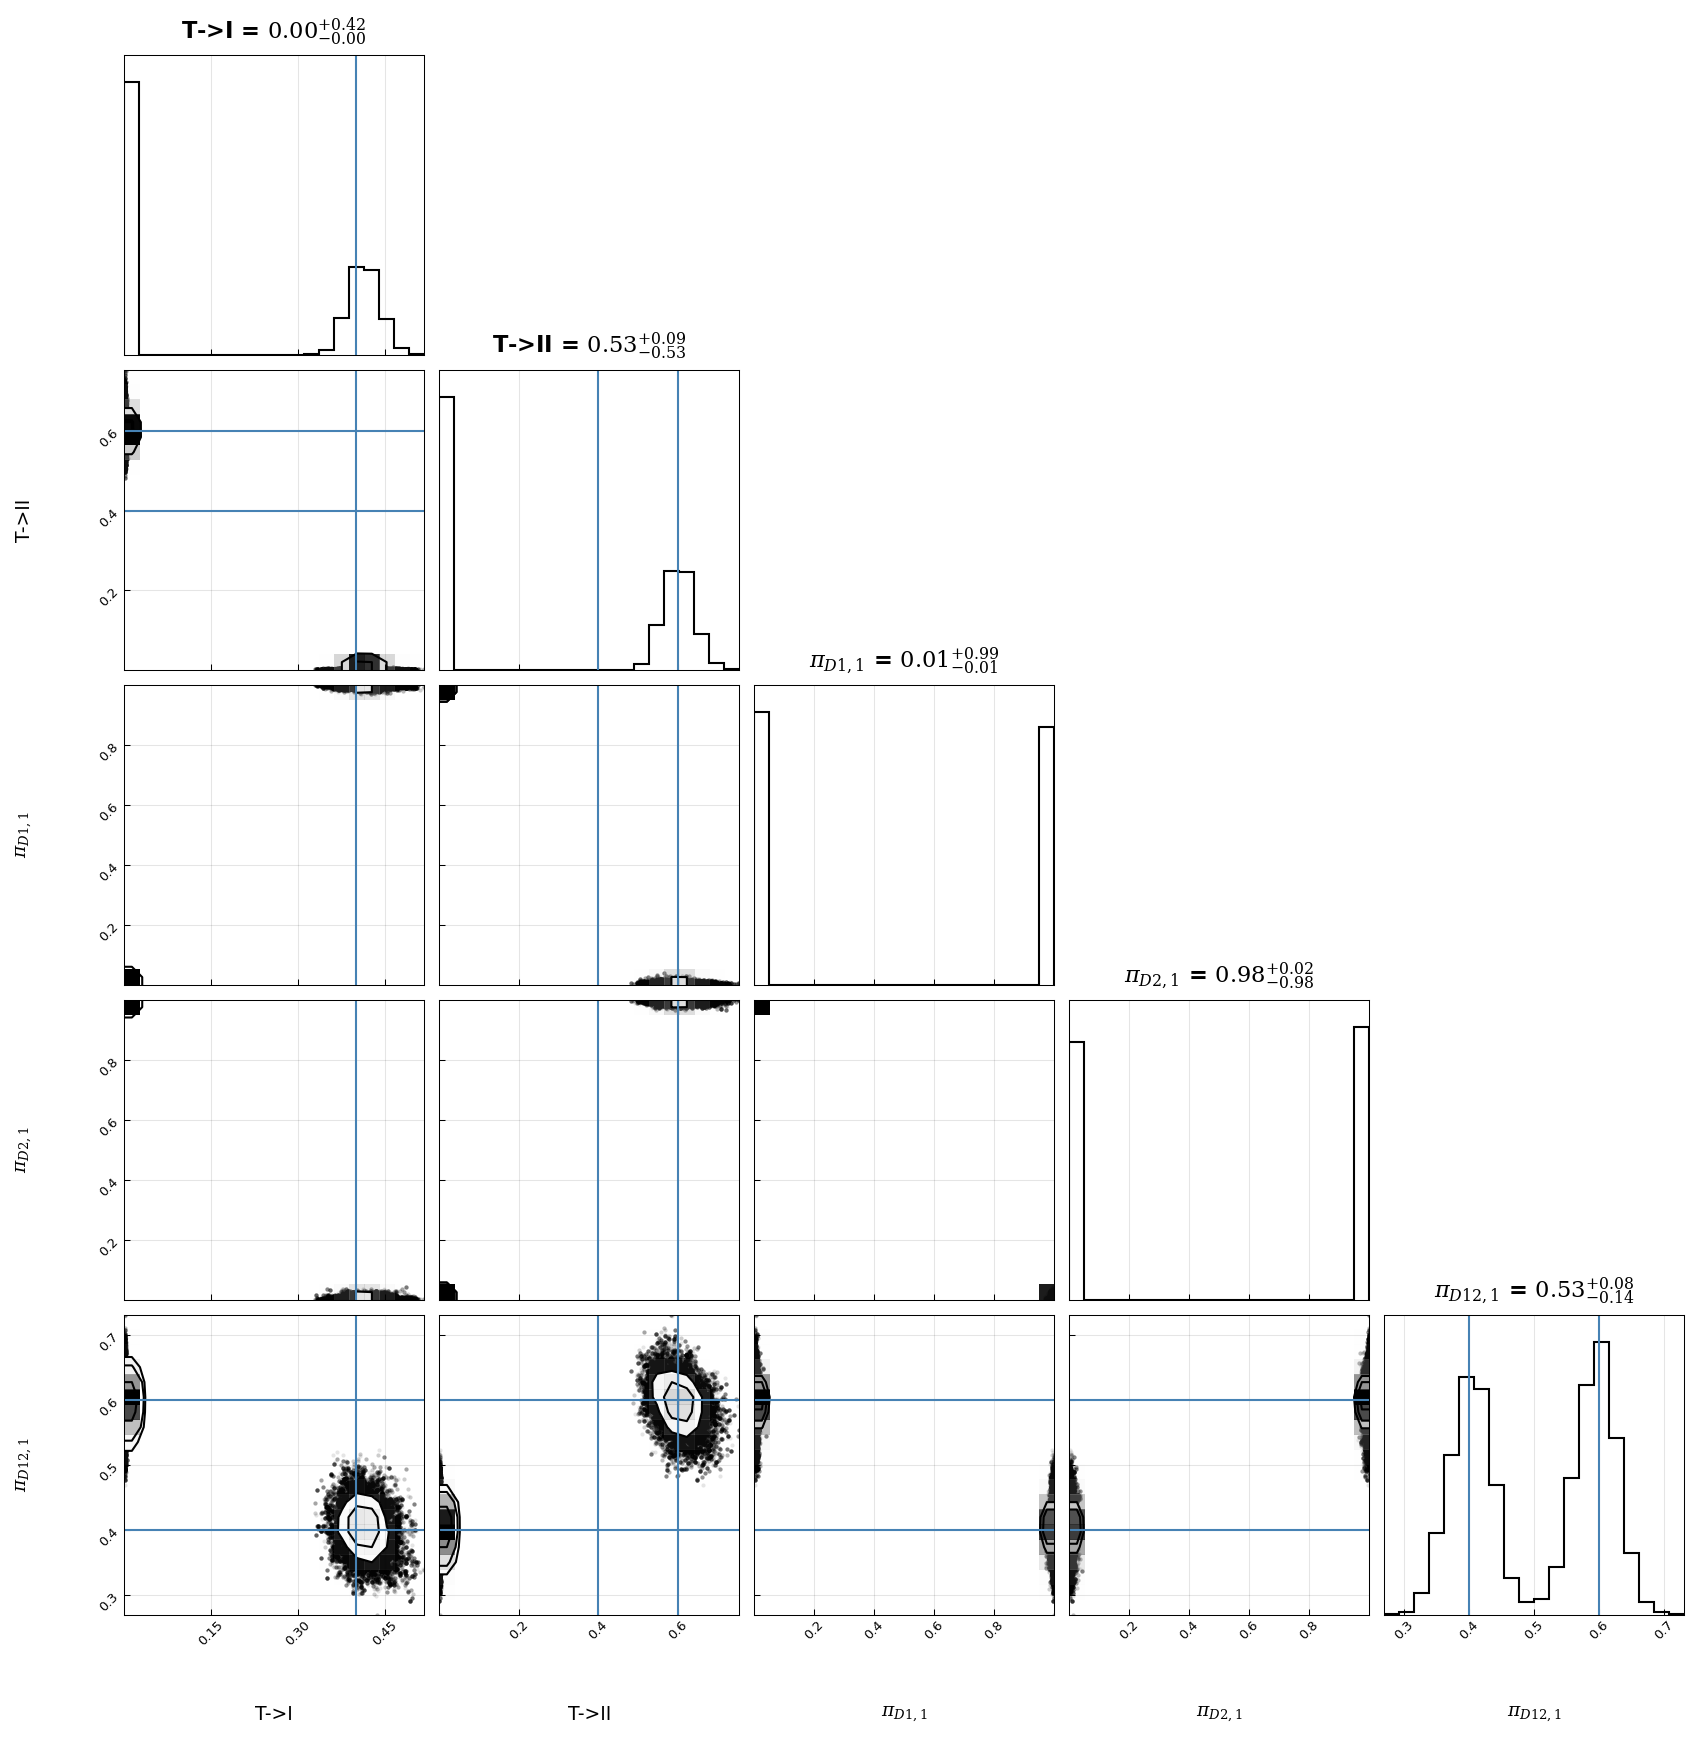

In [413]:
model_labels_cl0 = ["T->I", "T->II", *mixture_labels[:, 0]]
model_labels_cl1 = ["T->I", "T->II", *mixture_labels[:, 1]]

truths = [[0.4, 0.6], [0.4,0.6], None, None, [0.4,0.6]]

if True:
    fig = corner.corner(
        samples_cl0,
        labels=model_labels_cl0,
        truths = truths,
        show_titles=True,
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_cl0_synth_d1_d2_d12_r04_T1T2.svg")

if True:
    fig = corner.corner(
        samples_cl1,
        labels=model_labels_cl1,
        truths = truths,
        show_titles=True,
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_cl1_synth_d1_d2_d12_r04_T1T2.svg")

### Inspect the degeneration

In [277]:
from sklearn.cluster import KMeans
cd = {0: '#42f5b6', 1:'#f542e3'} # Green , Pink

In [278]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(samples_d1d2d12)
mc_labels = kmeans.labels_

In [279]:
if sampling and False:
    llhs = [llh_2_cluster(p) for p in samples_d1d2d12]
    np.save(f"./samples/" + "llhs_mixture_synth_d1_d2_d12_r04_T1T2", llhs)
else:
    llhs = np.load(f"./samples/" + "llhs_mixture_synth_d1_d2_d12_r04_T1T2.npy")

<Figure size 960x720 with 0 Axes>

/Users/juli/Studium/Master/FS23/masterthesis/code/.venv2/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


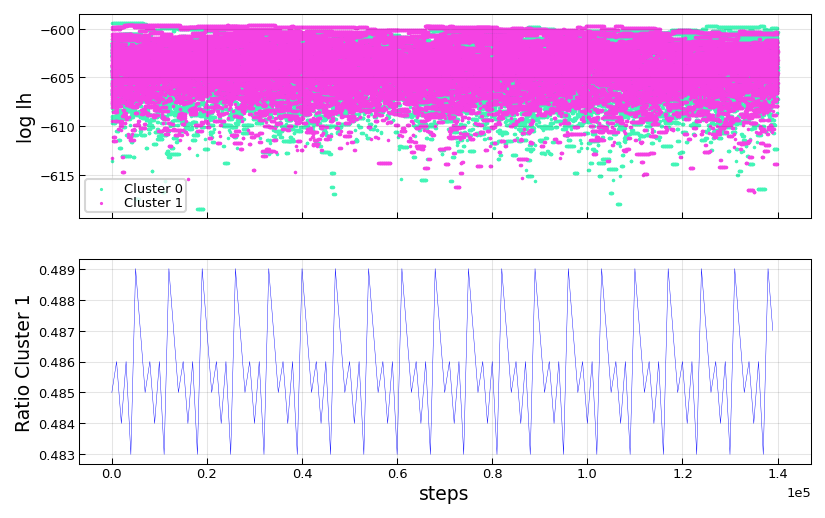

In [293]:
window = 1000
rolling = []
steps = []
for i in range(0, len(mc_labels), window):
    _slice = mc_labels[i: i + window]
    rolling.append(_slice.sum()/window)
    steps.append(i)

label_names = ['Cluster 0', 'Cluster 1']

fig, ax = plt.subplots(2,1, sharex=True, figsize = set_size(width='full'))
for i, label in enumerate(label_names):
    indices = np.where(mc_labels == i)[0]
    ax[0].scatter(indices, [llhs[idx] for idx in indices], color=cd[i], label=label, s=0.5)
ax[0].set_ylabel('log lh')
ax[1].set_xlabel('steps')
ax[0].legend()

ax[1].plot(steps, rolling, linewidth = 0.2, c = 'b')
ax[1].set_ylabel('Ratio Cluster 1')

plt.show()
fig.savefig(PLOT_PATH / "switching_problem_sampler_inspect.png")

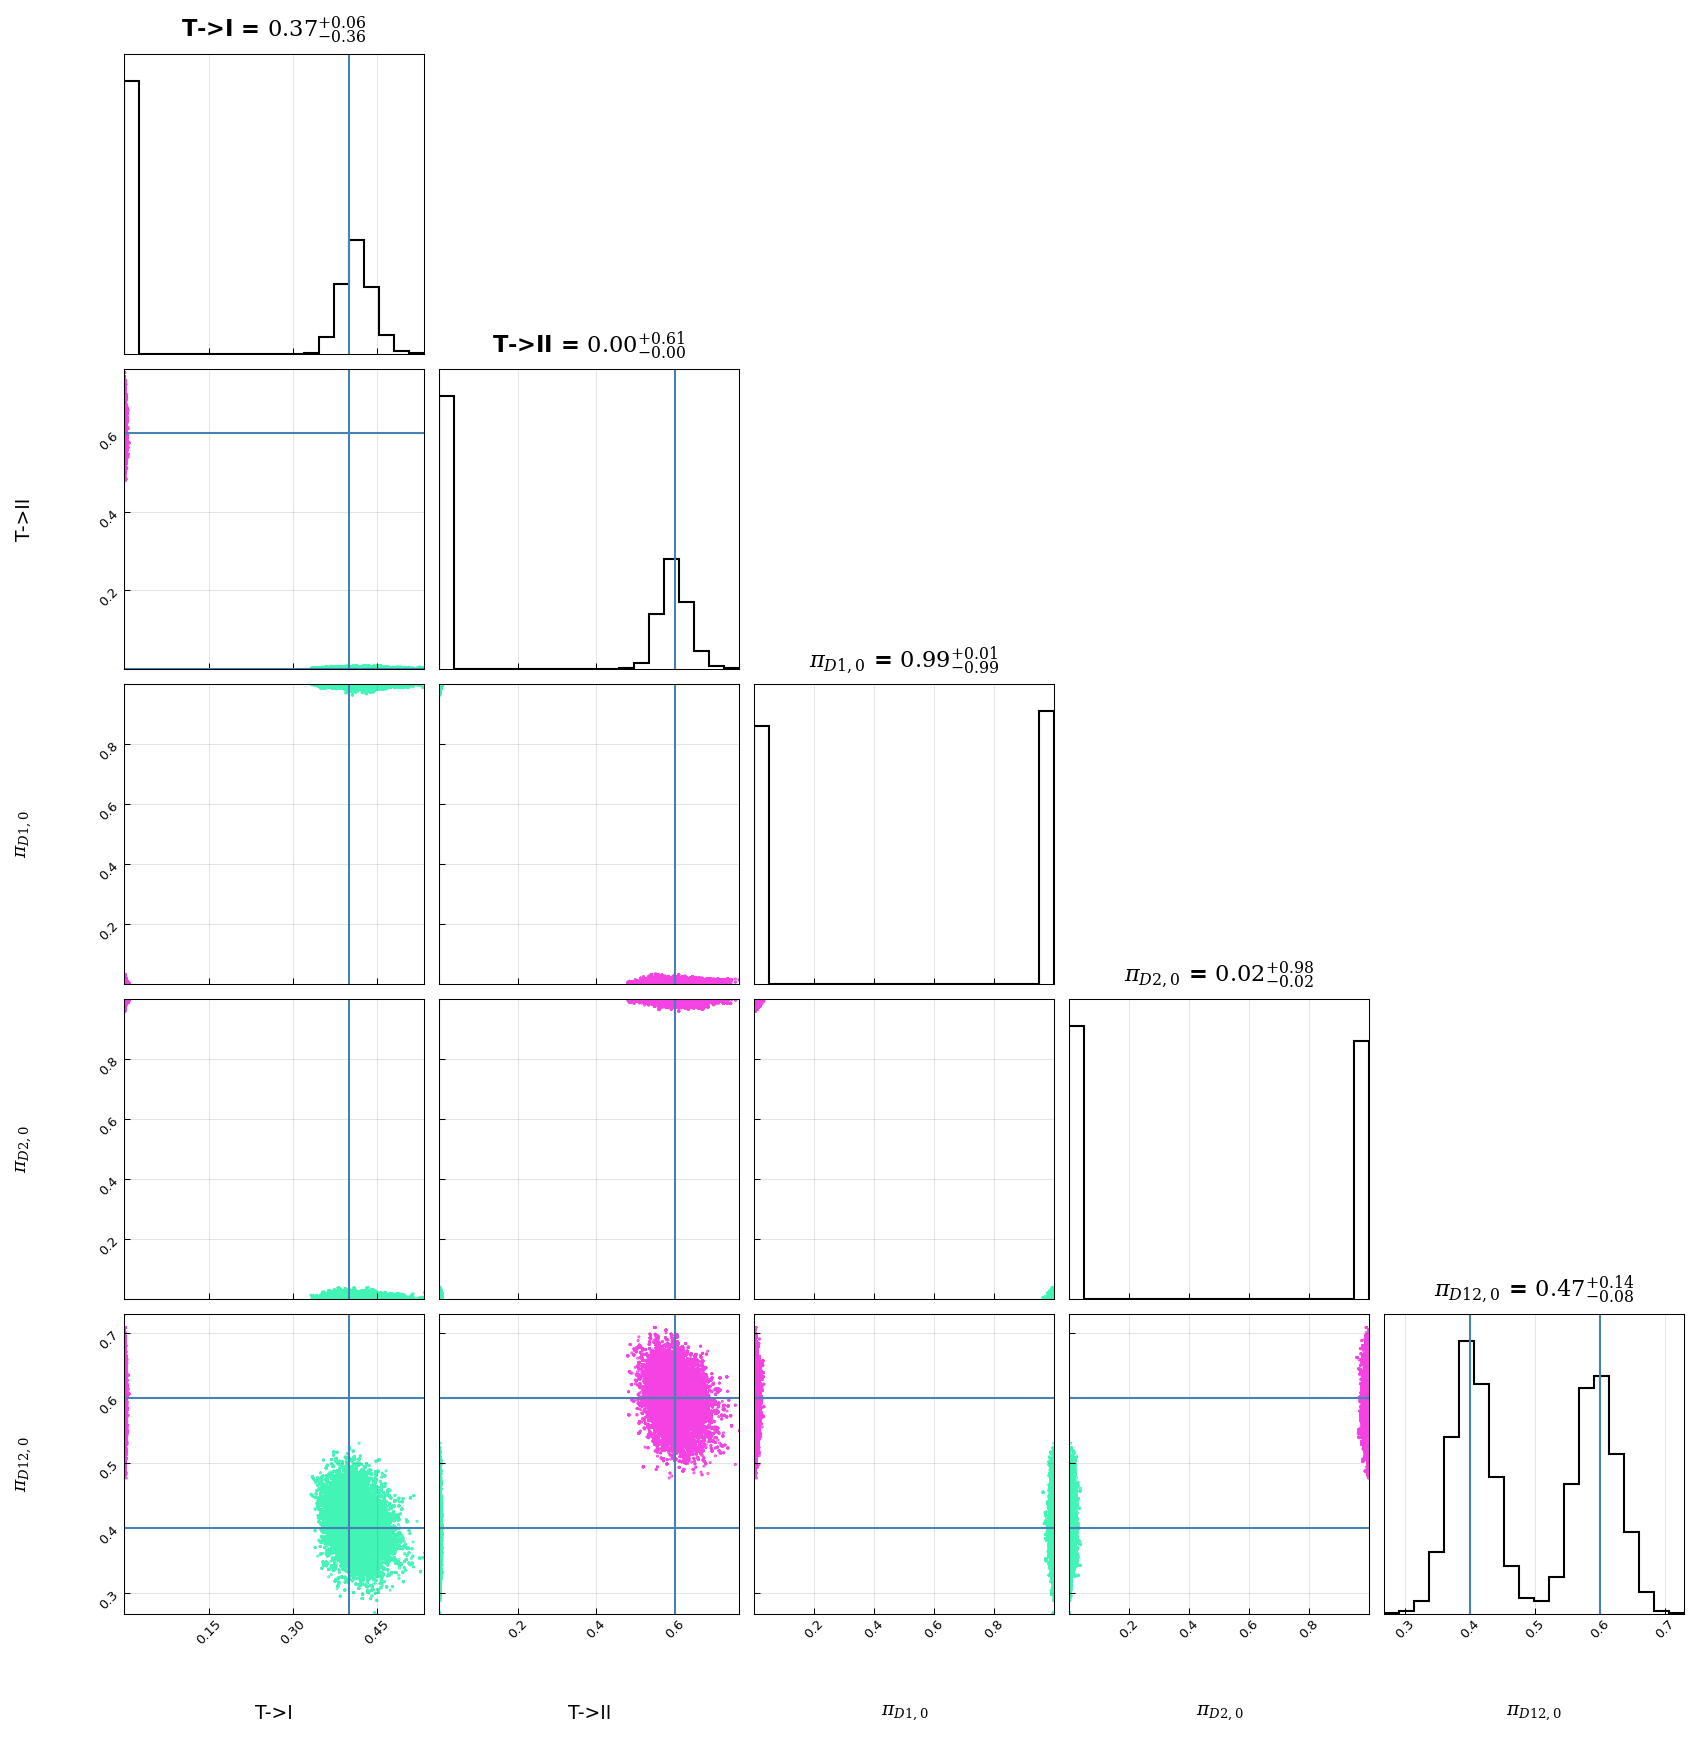

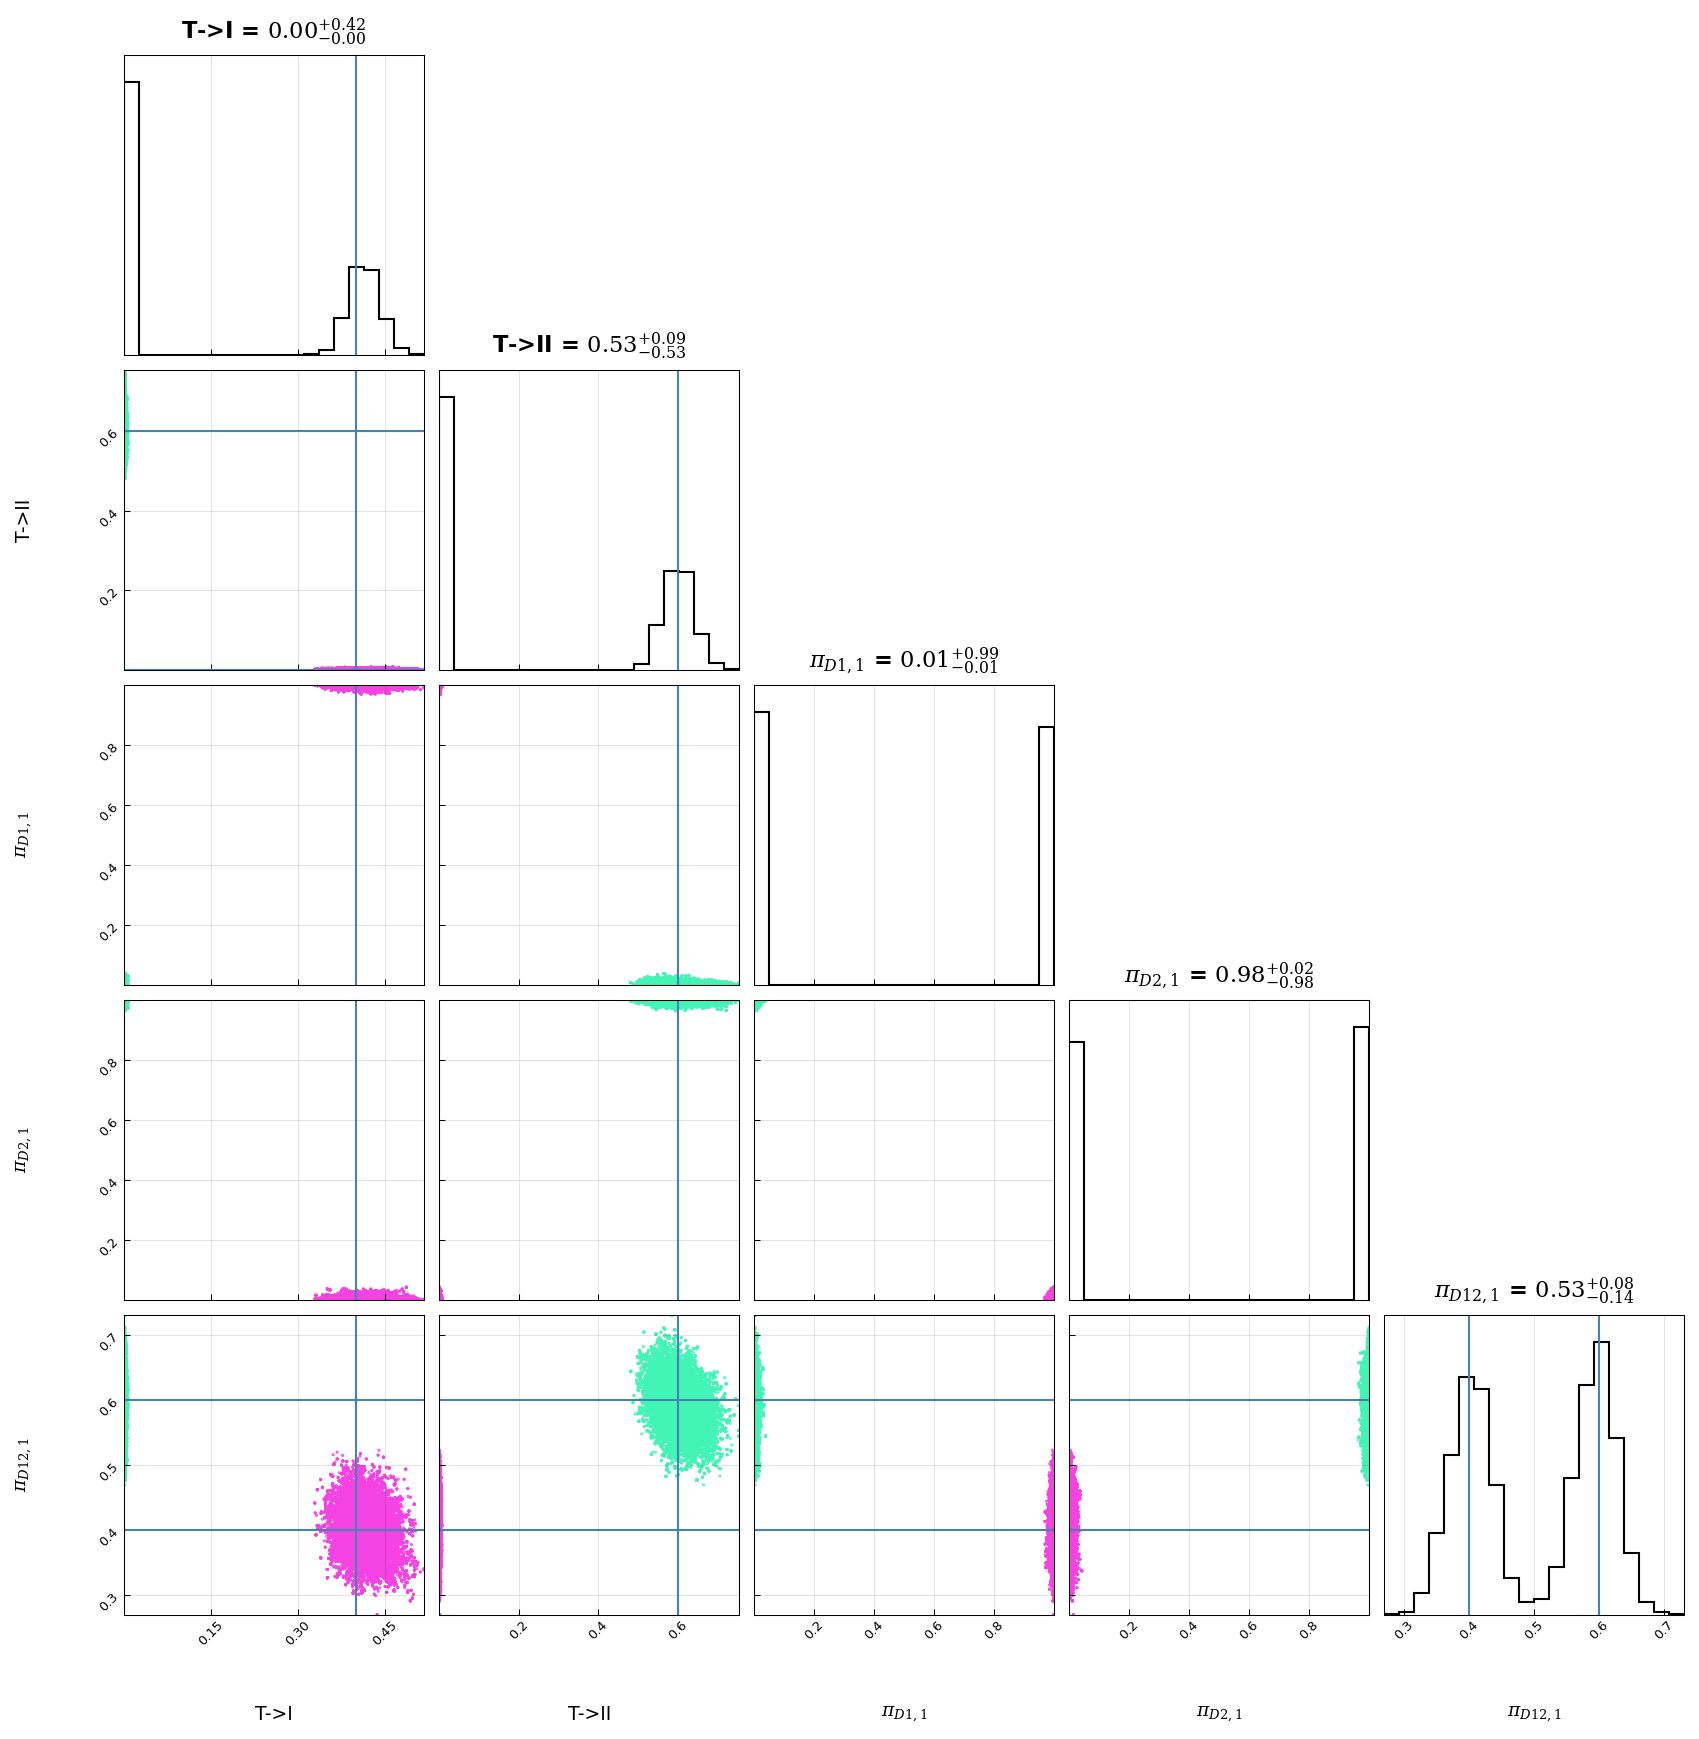

In [289]:
model_labels_cl0 = ["T->I", "T->II", *mixture_labels[:, 0]]
model_labels_cl1 = ["T->I", "T->II", *mixture_labels[:, 1]]

truths = [[0.4, 0.0], [0.0,0.6], None, None, [0.4,0.6]]

if True:
    fig = corner.corner(
        samples_cl0,
        labels=model_labels_cl0,
        truths = truths,
        show_titles=True,
        plot_contours = False,
        plot_density = False,
        no_fill_contours = True,
        data_kwargs= {"colors_llh": [cd[l] for l in mc_labels]}
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_switching_problem_cl0_synth_d1_d2_d12_r04_T1T2.png")

if True:
    fig = corner.corner(
        samples_cl1,
        labels=model_labels_cl1,
        truths= truths,
        show_titles=True,
        plot_contours = False,
        plot_density = False,
        no_fill_contours = True,
        data_kwargs= {"colors_llh": [cd[l] for l in mc_labels]}
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_switching_problem_cl1_synth_d1_d2_d12_r04_T1T2.png")



We see that sampling all the parameters in one is not possible, since the sample space is degenerated. To solve this, either an EM algortihm, or constraints on the sample space is needed.

In [295]:
# Definitions and create and load the model
n_subsites = 1
n_clusters = 2

model = create_models(n_subsites, graph_lnl_I_II, include_late=False, n_mixture_components=n_clusters )
model.load_patient_data(data_synth['D12'])
MODELS = [model]

In [297]:
# Number of parameters 
n_params_base = len(MODELS[0].get_params())
n_params_model = n_clusters * n_params_base + n_subsites * (n_clusters - 1)
n_params = n_params_model 

#and check that llh works

params = [0.4, 0.01, 0.01, 0.6,0.4]
assert len(params) == n_params
llh_2_cluster(params)


-313.90276061367354

In [299]:
sample_name = "samples_mixture_synth_d12_r04_T1T2"
sampling = False

if sampling:
    samples_2_d12 = emcee_sampling(llh_2_cluster, n_params, sample_name)
else:
    samples_2_d12 = np.load("samples/"+sample_name+".npy")

In [300]:
# Extract cluster parameters
samples_cl0 = samples_2_d12[:, [0,2,4]]
samples_cl1 = samples_2_d12[:, [1,3]]

# Add the mixture parameter which is not samples due to constraint
samples_cl1 = np.hstack((samples_cl1, (1-samples_cl0[:, -1]).reshape(-1, 1)))

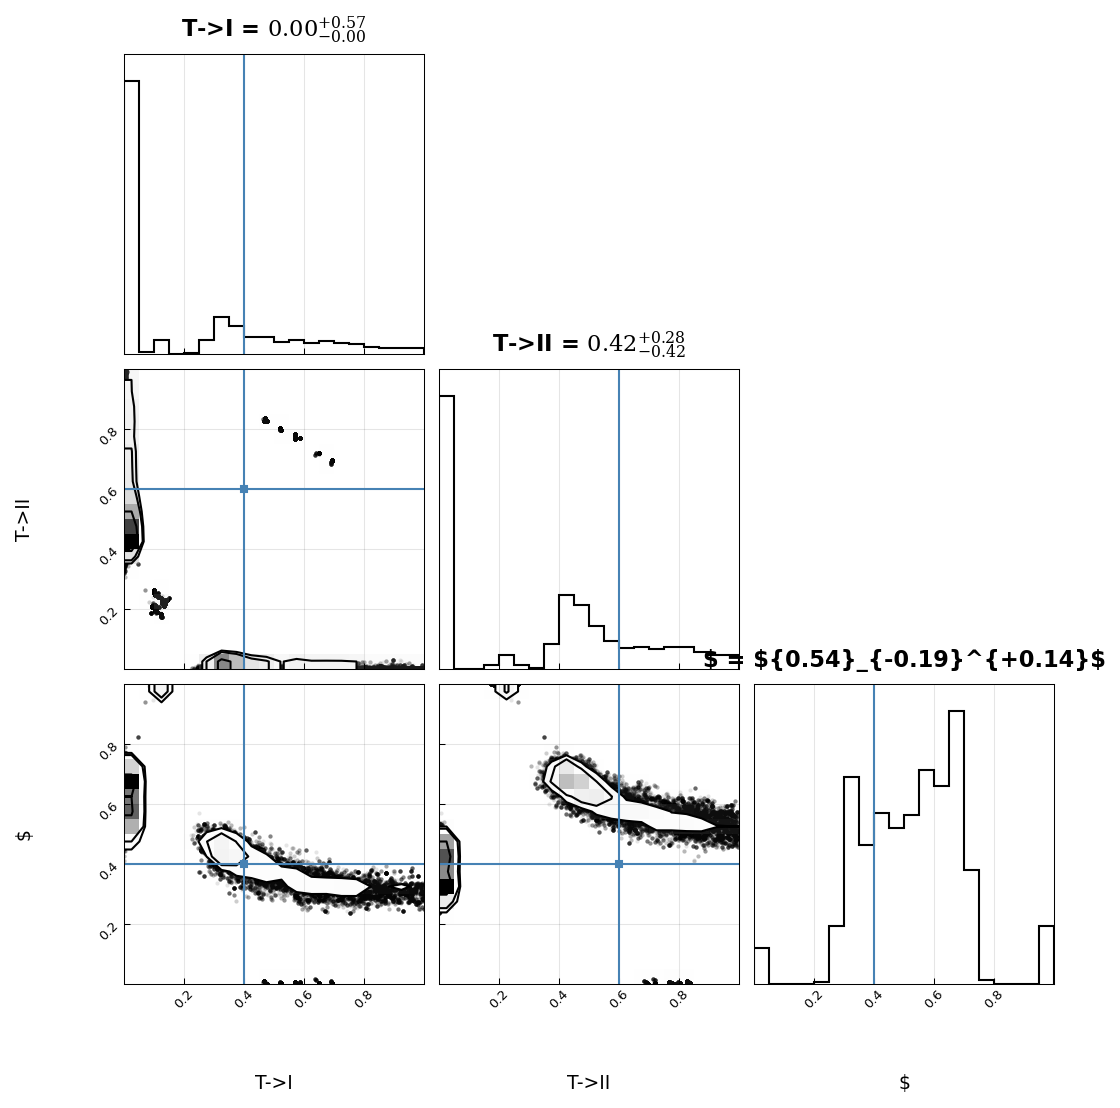

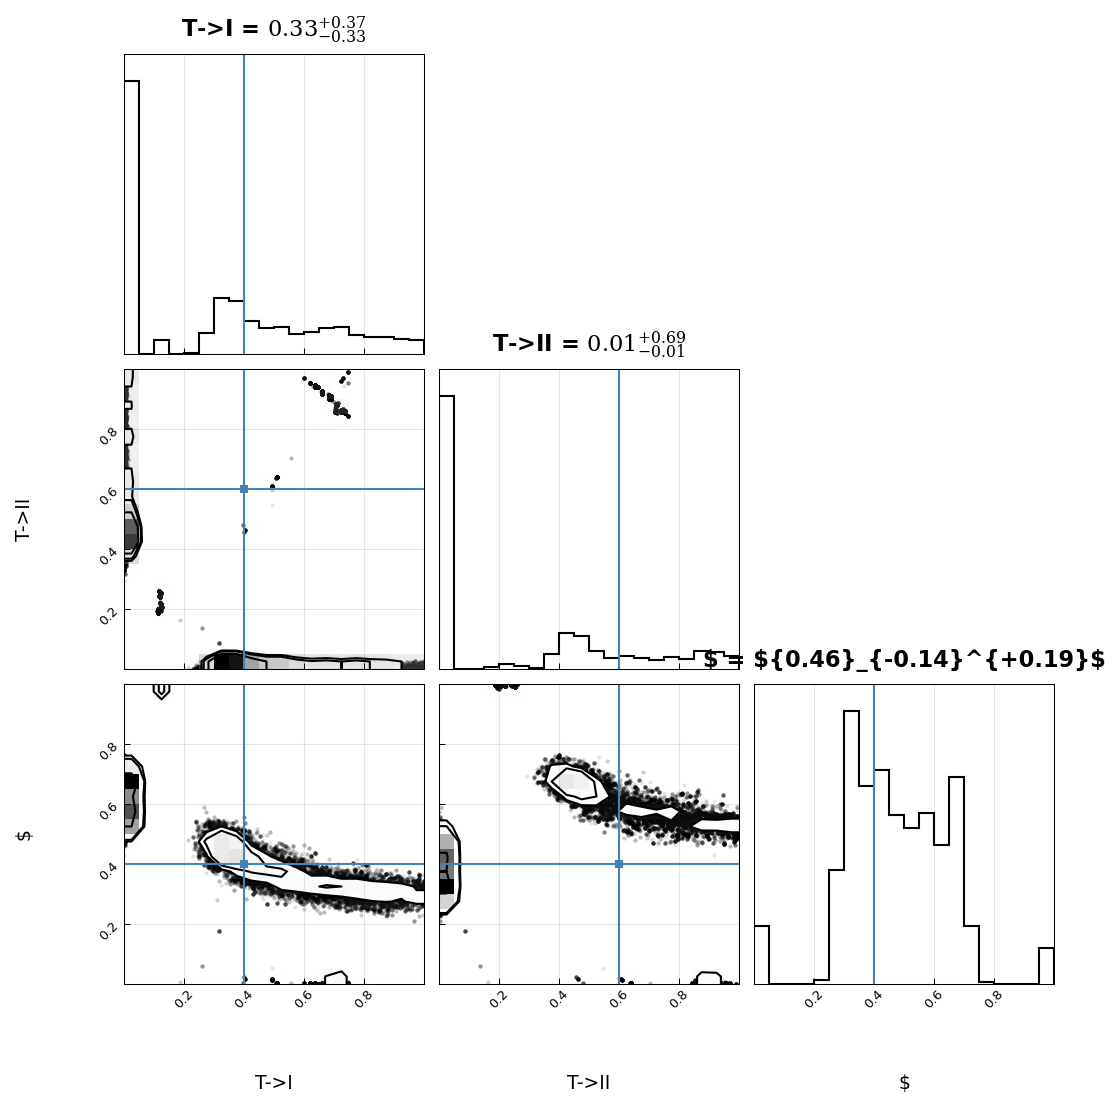

In [301]:
model_labels_cl0 = ["T->I", "T->II", *mixture_labels[2, 0]]
model_labels_cl1 = ["T->I", "T->II", *mixture_labels[2, 1]]

truths = [0.4,0.6, 0.4]

if True:
    fig = corner.corner(
        samples_cl0,
        labels=model_labels_cl0,
        truths = truths,
        show_titles=True,
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_mixture_synth_d12_r04_T1T2.svg")

if True:
    fig = corner.corner(
        samples_cl1,
        labels=model_labels_cl1,
        truths = truths,
        show_titles=True,
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_mixture_synth_d12_r04_T1T2.svg")

## EM algortihm



In [259]:
from scipy.optimize import minimize
global MODEL


In [321]:

def maximation_llh_2_cluster_fixed_weights(params, fixed_weights, n_clusters=2):
    global MODELS
    return_val = -10000
    for p in params:
        if p < 0 or 1 < p:
            return return_val 
    theta = [*params, *fixed_weights]
    model_params, mixing_params = convert_params(theta, n_clusters, len(MODELS))

    log_sum = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = mixing_params[i]
        log_sum += model.likelihood(given_param_args = model_params, log = True)
    if np.isnan(log_sum):
        return return_val

    if np.isinf(log_sum):
        return return_val
    else:
        return log_sum 
    
def maximation_llh_2_cluster_fixed_weights_inv(params, fixed_weights, inverted = True, n_clusters=2):
    global MODELS
    return_val = -10000
    if inverted:
        return_val = 10000
    for p in params:
        if p < 0 or 1 < p:
            return return_val 
    theta = [*params, *fixed_weights]
    model_params, mixing_params = convert_params(theta, n_clusters, len(MODELS))

    log_sum = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = mixing_params[i]
        log_sum += model.likelihood(given_param_args = model_params, log = True)
    if np.isnan(log_sum):
        return return_val

    if np.isinf(log_sum):
        return return_val
    if inverted:
        return -log_sum
    else:
        return log_sum 


def expectation_llh_2_cl(params, models, inverted = True):
    # For now works only with 2 clusters
    for p in params:
        if p < 0 or 1 < p:
            return 10000 if inverted else -10000
    llh = 0
    for i, model in enumerate(models):
        model.mixture_components = [params[i], 1 - params[i]]
        llh += model.likelihood()
    if inverted: 
        return -llh
    else:
        return llh
    
def assign_model_params(params, n_clusters, models, n_params_base = None):
    global MODELS
    if n_params_base is None:
        model_params, mixing_params = convert_params(params, n_clusters, len(MODELS))
    else:
        model_params = [[params[j*n_clusters+i] for i in range(n_clusters)] for j in range(n_params_base)]
    for i, model in enumerate(models):
        model.assign_params(*model_params)
    MODELS = models
    return models

    

In [302]:
n_subsites = 3
n_clusters = 2

n_params = 4
initial_weights = [1,0,0] # wheights of D1, D2, D12 corresponsing to cluster 0

models = create_models(n_subsites, graph_lnl_I_II, include_late=False, n_mixture_components=n_clusters )
for i, (k,v) in enumerate(data_synth.items()):
    models[i].load_patient_data(v, side='ipsi')
MODELS = models

In [304]:
# First, we check the ground truth data:
weights_true = [1,0,r_12]
params_true = [0.4, 0,0,0.6]
sampling = True
#Short sampling round for the model parameters (maximation round)
if sampling:
    samples, end_point, llh = emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, None, n_burnin = 200, n_step = 250, llh_args = [weights_true])
label_names = [r'$b_1^0', r'$b_1^1', r'$b_2^0', r'$b_2^1']

Dimension: 4 with n walkers: 80


Start Burning (steps = 200) with 8 cores


100%|██████████| 200/200 [00:28<00:00,  7.08it/s]


the HMM sampler for model 01 accepted 41.68 % of samples.


100%|██████████| 250/250 [00:38<00:00,  6.55it/s]

the HMM sampler for model accepted 50.41 % of samples.


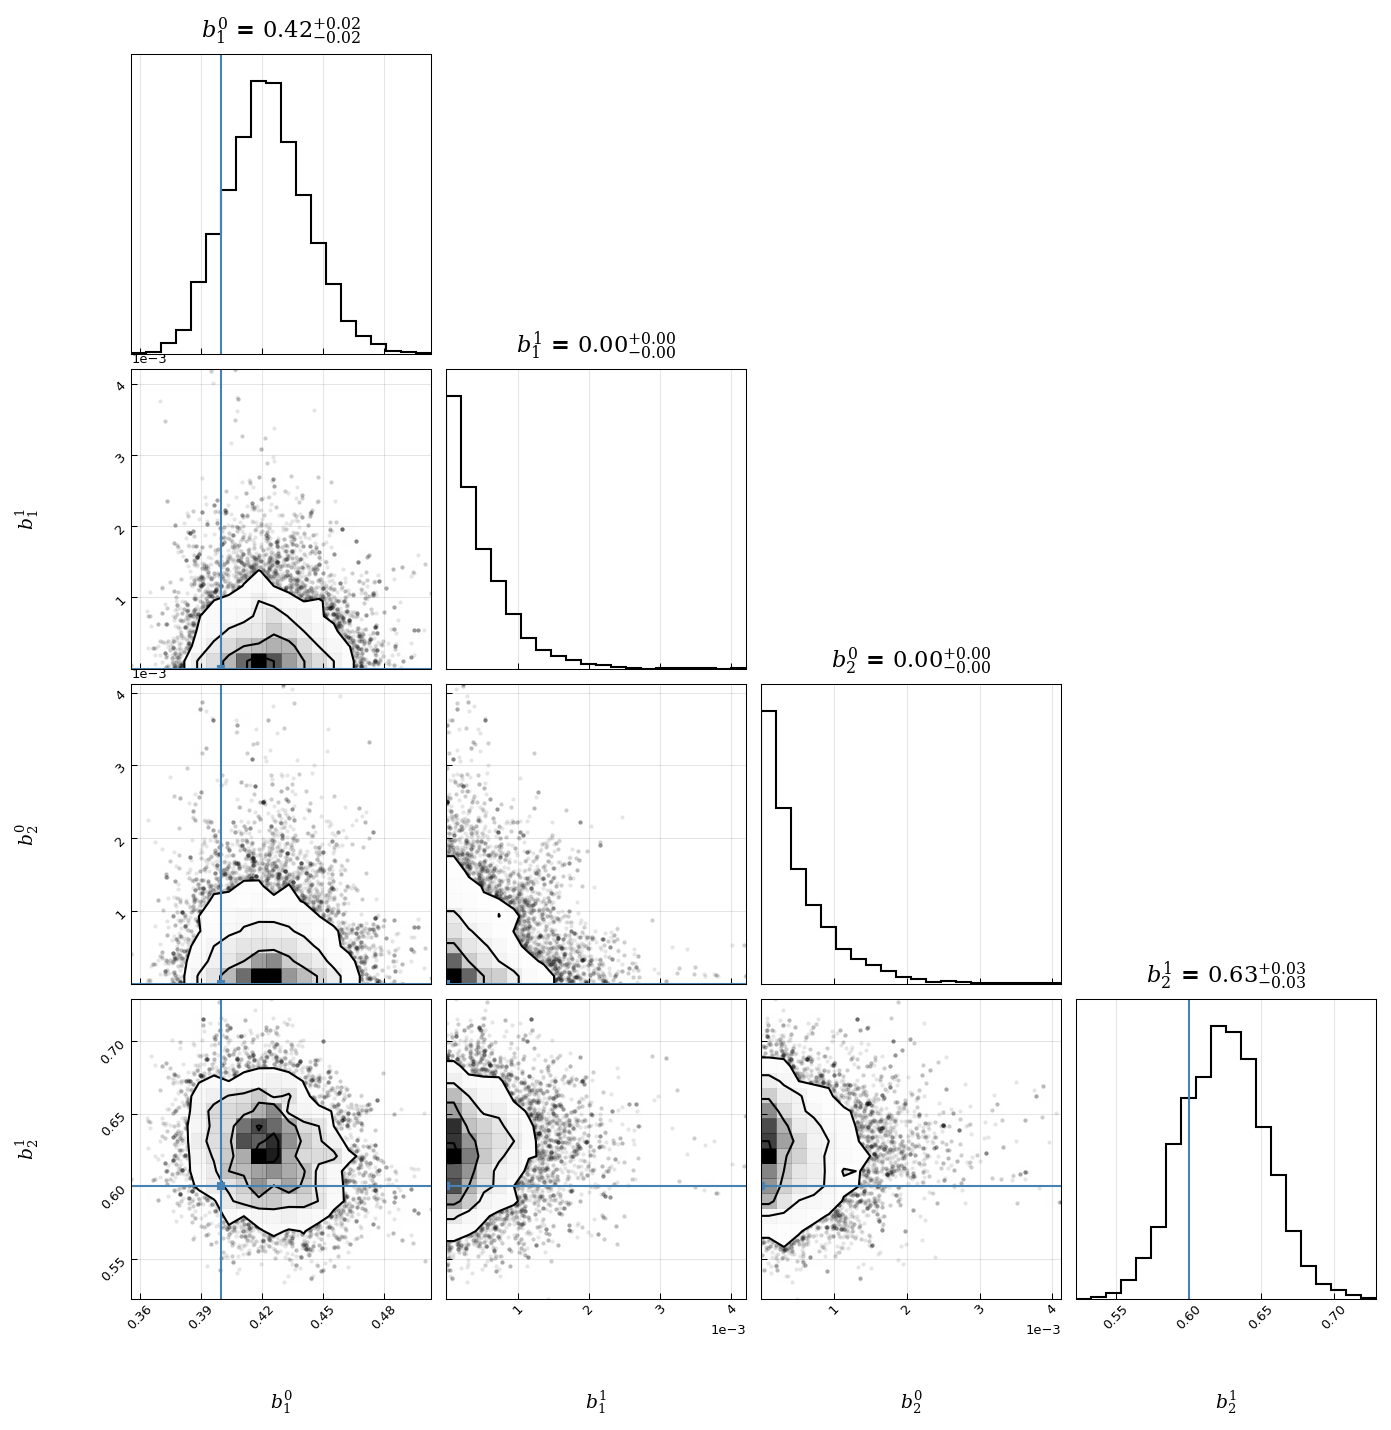

In [305]:
label_names = [r'$b_1^0$', r'$b_1^1$', r'$b_2^0$', r'$b_2^1$']
fig = corner.corner(
        samples,
        labels=label_names,
        truths = [0.4, 0, 0, 0.6],
        show_titles=True,
    )
plt.show()
fig.savefig(PLOT_PATH / "corner_true_assignment_d1d2d12_r04_T1T2.svg")

In [311]:
# MLE results
# Set initial guess for parameters
initial_guess = [0.4, 0.2, 0.0, 0.5]  # Modify this as needed

# Define parameter bounds
param_bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

# Set inverted=True
inverted = True

# Minimize the negative log-likelihood to find MLE
result = minimize(
    maximation_llh_2_cluster_fixed_weights_inv,
    initial_guess,
    args=(weights_true, inverted),
    bounds=param_bounds,
)

# Extract the MLE parameters
mle_params = result.x

print("MLE Parameters:", mle_params)
print("Log-Likelihood at MLE:", -result.fun)


MLE Parameters: [0.42066335 0.         0.         0.62420588]
Log-Likelihood at MLE: -972.740368077802


In [271]:
params_true = [0.4,0,0,0.55]
maximation_llh_2_cluster_fixed_weights(params_true, weights_true)


-1030.108757228245

In [272]:
llh_2_cluster([0.4,0,0,0.6,1,0,0.4])

-1032.0925372994166

In [48]:
sample_name = "em_samples/M0_mixture_synth_d1_d2_d12_r04_T1T2"
sampling = False
# Maximation step
if sampling:
    samples, end_point, llh = emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, sample_name, n_burnin = 500, n_step = 1000, llh_args = [fixed_weights, models])
else:
    samples = np.load(f"./samples/" + sample_name + ".npy")

In [49]:
# Extract cluster parameters
samples_cl0 = samples[:, [0,2]]
samples_cl1 = samples[:, [1,3]]

model_labels_cl0 = ["T->I", "T->II", *mixture_labels[2, 0]]
model_labels_cl1 = ["T->I", "T->II", *mixture_labels[2, 1]]

msc0 = [*samples_cl0.mean(axis =0), *fixed_weights]
msc1 = [*samples_cl1.mean(axis =0), *[1-w for w in fixed_weights]]
print("Cluster 0")
for k,v in zip(model_labels_cl0, msc0):
    print(f"{k}: {v:1f} ")
print("Cluster 1")
for k,v in zip(model_labels_cl1, msc1):
    print(f"{k}: {v:1f} ")


Cluster 0
T->I: 0.220686 
T->II: 0.093527 
$: 1.000000 
\: 0.000000 
p: 1.000000 
Cluster 1
T->I: 0.001144 
T->II: 0.603518 
$: 0.000000 
\: 1.000000 
p: 0.000000 


In [50]:
# Expectation step: assign the aprameters to the model
models = assign_model_params(samples.mean(axis = 0), n_clusters, models)

In [51]:
params = [0.7,0.1,0.5]

expectation_llh_2_cl(params, models)


875.0262842699168

In [58]:
bounds = []
initial_guess = [0.5, 0.5, 0.5]

res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')

weights_00 = res.x
print(weights_00)
np.save(f"./samples/em_samples" + "E00_2cl_d1d2d12_r04", weights_00)
# print(f"For D1: pi_0 = {np.round(res.x[0], 2)}, pi_1 = {np.round(1-res.x[0], 2)}")

[0.99999118 0.12645256 0.5063935 ]


In [ ]:
def maximization(llh, fixed_weights, sample_name, models):
    samples, end_point, llh = emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, sample_name, n_burnin = 500, n_step = 1000, llh_args = [fixed_weights])

### Round 2:

In [ ]:
step = "01"

In [61]:
#Maximation

weights_0 = weights_00
sample_name = f"em_samples/M{step}_mixture_synth_d1_d2_d12_r04_T1T2"
samples, end_point, llh = emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, sample_name, n_burnin = 500, n_step = 500, llh_args = [weights_0])


Dimension: 4 with n walkers: 80


Start Burning (steps = 500) with 8 cores


100%|██████████| 500/500 [00:24<00:00, 20.62it/s]


the HMM sampler for model 01 accepted 47.42 % of samples.


100%|██████████| 500/500 [00:24<00:00, 20.73it/s]

the HMM sampler for model accepted 50.58 % of samples.


In [63]:
# Maximization Results
model_params_01 = samples.mean(axis = 0)
print(model_params_01)

[0.33558666 0.0007825  0.00084314 0.7430466 ]


In [72]:
# Expectation
llhs = []
weights = []
for i in range(100):
    models = assign_model_params(model_params_01, n_clusters, models)
    bounds = []
    initial_guess = np.random.random(3)

    res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')
    llhs.append(maximation_llh_2_cluster_fixed_weights(model_params_01, res.x, models))
    weights.append(res.x)

weights_01 = weights[np.argmax(llhs)]
print(weights_01)
np.save(f"./samples/em_samples" + "E{step}_2cl_d1d2d12_r04", weights_00)

[0.99999015 0.0541013  0.58672094]


In [77]:
## Step 3
step = "02"
params_nm1 = model_params_01
weights_nm1 = weights_01
# Expectation
llhs = []
weights = []

models = assign_model_params(model_params_01, n_clusters, models)
bounds = []
for i in range(100):

    initial_guess = np.random.random(3)

    res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')
    llhs.append(maximation_llh_2_cluster_fixed_weights(model_params_01, res.x, models))
    weights.append(res.x)

weights_02 = weights[np.argmax(llhs)]
print(weights_02)
np.save(f"./samples/em_samples" + "E{step}_2cl_d1d2d12_r04", weights_00)

[0.99992764 0.0033698  0.44080988]


In [80]:
#Maximation
MODELS = models
weights = weights_02
sample_name = f"em_samples/M{step}_mixture_synth_d1_d2_d12_r04_T1T2"
samples, end_point, llh = emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, sample_name, n_burnin = 500, n_step = 500, llh_args = [weights])


Dimension: 4 with n walkers: 80


Start Burning (steps = 500) with 8 cores


100%|██████████| 500/500 [00:24<00:00, 20.11it/s]


the HMM sampler for model 01 accepted 47.46 % of samples.


100%|██████████| 500/500 [00:22<00:00, 21.75it/s]

the HMM sampler for model accepted 50.35 % of samples.


In [81]:
# Maximization Results
model_params_01 = samples.mean(axis = 0)
print(model_params_01)

[0.37233765 0.0007417  0.00083205 0.61225236]


In [83]:
## Step 4
step = "03"
params_nm1 = model_params_01
weights_nm1 = weights
# Expectation
llhs = []
weights = []

models = assign_model_params(model_params_01, n_clusters, models)
MODELS = models
bounds = []
for i in range(100):

    initial_guess = np.random.random(3)

    res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')
    llhs.append(maximation_llh_2_cluster_fixed_weights(model_params_01, res.x))
    weights.append(res.x)

weights = weights[np.argmax(llhs)]
print(weights)
np.save(f"./samples/em_samples/" + f"E{step}_2cl_d1d2d12_r04", weights)

[0.99995074 0.00430617 0.42814682]


In [85]:
#Maximation
MODELS = models
weights = weights
sample_name = f"em_samples/M{step}_mixture_synth_d1_d2_d12_r04_T1T2"
samples, end_point, llh = emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, sample_name, n_burnin = 500, n_step = 500, llh_args = [weights])
# Maximization Results
model_params_01 = samples.mean(axis = 0)
print(model_params_01)


Dimension: 4 with n walkers: 80


Start Burning (steps = 500) with 8 cores


100%|██████████| 500/500 [00:21<00:00, 23.46it/s]


the HMM sampler for model 01 accepted 48.19 % of samples.


100%|██████████| 500/500 [00:22<00:00, 22.54it/s]

the HMM sampler for model accepted 50.69 % of samples.
[0.37257875 0.00074266 0.00078972 0.60973655]


In [294]:
weights

array([9.96336192e-01, 1.38352194e-08, 4.30078719e-01])

In [343]:
steps = ["19"]
for step in steps:
    print(f"Step {step}" + "-"*10)
    params_nm1 = model_params_01
    weights_nm1 = weights
    # Expectation
    llhs = []
    weights = []

    models = assign_model_params(model_params_01, n_clusters, models)
    MODELS = models
    bounds = []
    for i in range(10):

        initial_guess = np.random.random(3)

        res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')
        llhs.append(maximation_llh_2_cluster_fixed_weights(model_params_01, res.x))
        weights.append(res.x)

    weights = weights[np.argmax(llhs)]
    print(f"Eximation: {weights}")
    np.save(f"./samples/em_samples/" + f"E{step}_2cl_d1d2d12_r04", weights)
        #Maximation
    MODELS = models
    for m in MODELS:
        print(m.mixture_components)
    weights = weights
    sample_name = f"em_samples/M{step}_mixture_synth_d1_d2_d12_r04_T1T2"
    samples, end_point, llh = emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, sample_name, n_burnin = 50, n_step = 100, start_with=end_point, llh_args = [weights])
    # Maximization Results
    model_params_01 = samples.mean(axis = 0)
    print(f"Maximation: {model_params_01}")

Step 19----------
Eximation: [0.99996827 0.04535899 0.46175676]
[0.7577107753108676, 0.2422892246891324]
[1.7762168866563672e-08, 0.9999999822378312]
[0.38104558385477766, 0.6189544161452223]
Dimension: 4 with n walkers: 80
Start Burning (steps = 50) with 8 cores


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


the HMM sampler for model 01 accepted 51.32 % of samples.


100%|██████████| 100/100 [00:16<00:00,  6.17it/s]

the HMM sampler for model accepted 49.73 % of samples.
Maximation: [4.01955255e-01 4.35909486e-04 4.97070772e-04 6.72555438e-01]


In [344]:
weights

array([0.99996827, 0.04535899, 0.46175676])

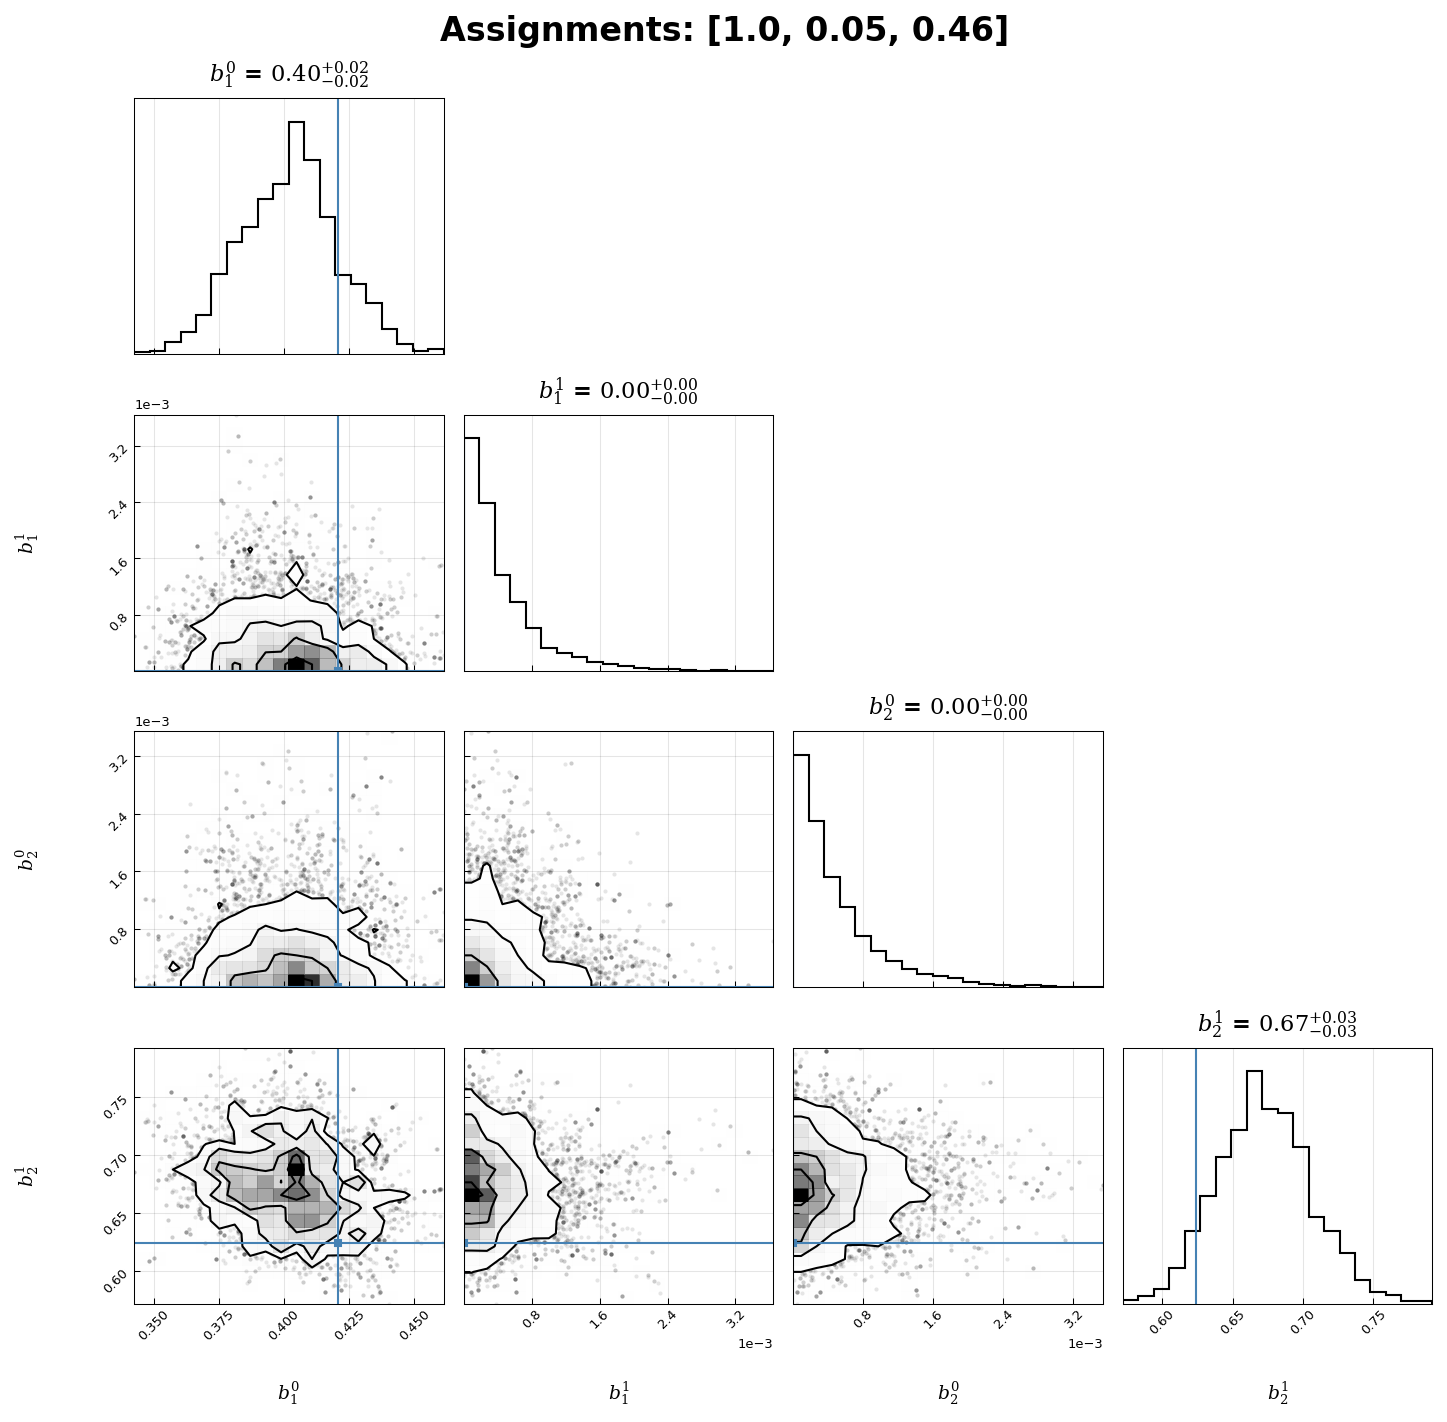

In [345]:
label_names = [r'$b_1^0$', r'$b_1^1$', r'$b_2^0$', r'$b_2^1$']
fig = corner.corner(
        samples,
        labels=label_names,
        truths = mle_params,
        show_titles=True,
    )
fig.suptitle(f'Assignments: {[np.round(w, 2) for w in weights]}', fontsize=16)
fig.tight_layout()
plt.show()
fig.savefig(PLOT_PATH / f"corner_em_{step}_d1d2d12_r04_T1T2.png")

In [171]:
# Slight off for the T->1 cl0 parameter, as well the agumented parameter for D12. T->1 of cluster 0 is to low, and therefore the assignment of D12 to cluster 0 is to high!

In [92]:
random.randint(0,5)

4

In [94]:
weights_list = []
llhs_list = []
for i in [random.randint(0,len(samples)) for _ in range(100)]:
        # Expectation
    llhs = []
    weights = []

    models = assign_model_params(samples[i,:], n_clusters, models)
    MODELS = models
    bounds = []
    for i in range(5):

        initial_guess = np.random.random(3)

        res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')
        llhs.append(maximation_llh_2_cluster_fixed_weights(model_params_01, res.x))
        weights.append(res.x)

    weights_list.append(weights[np.argmax(llhs)])
    llhs_list.append(np.max(llhs))
print(f"Eximation: {weights_list[np.argmax(llhs_list)]}")



Eximation: [9.95843675e-01 4.06711855e-04 4.52052457e-01]


(array([ 1.,  7., 10., 21., 21., 18.,  6.,  5.,  6.,  5.]),
 array([0.28503823, 0.32186361, 0.35868898, 0.39551435, 0.43233972,
        0.46916509, 0.50599046, 0.54281583, 0.5796412 , 0.61646657,
        0.65329194]),
 <BarContainer object of 10 artists>)

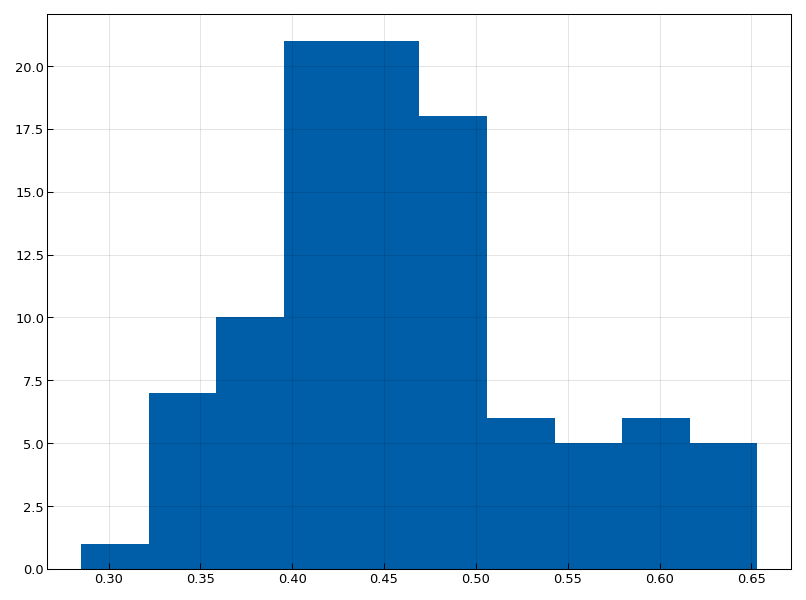

In [98]:
plt.hist([x[2] for x in weights_list])

In [100]:
# seems like we have a huge range, do we need to change the expectation step?

In [346]:
models = assign_model_params(model_params_01, n_clusters, models, n_params_base = 2)

In [340]:
for m in models:
    print(m.get_params())
    print(m.mixture_components)
print(weights)

dict_values([[0.4253405110042895, 0.00036014716888841823], [0.0004550102083768767, 0.6231091278188514]])
[0.999, 0.0010000000000000009]
dict_values([[0.4253405110042895, 0.00036014716888841823], [0.0004550102083768767, 0.6231091278188514]])
[8.310612871631463e-06, 0.9999916893871283]
dict_values([[0.4253405110042895, 0.00036014716888841823], [0.0004550102083768767, 0.6231091278188514]])
[0.9, 0.09999999999999998]
[9.35199510e-01 8.31061287e-06 4.19930916e-01]


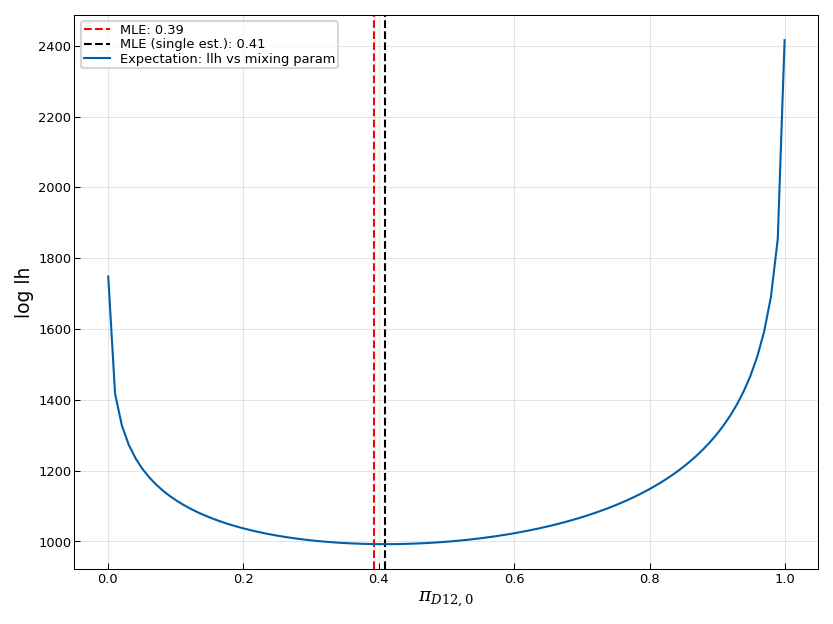

In [347]:
def llh_pi_d12(x, weights, models):
    if isinstance(x, np.ndarray):
        x = x[0] 
    return expectation_llh_2_cl([*weights[:2], x], models)
pi_d12_c0 = np.linspace(0.001, 0.999, 100) 
llh = [llh_pi_d12(p, weights, models) for p in pi_d12_c0]
res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')
plt.axvline(res.x[2], linestyle = '--', c = 'red', label = f"MLE: {np.round(res.x[2], 2)}")
res = minimize(llh_pi_d12, 0.5, args = (weights, models), method='L-BFGS-B')
plt.axvline(res.x[0], linestyle = '--', c = 'black', label = f"MLE (single est.): {np.round(res.x[0], 2)}")
plt.plot(pi_d12_c0, llh, label = 'Expectation: llh vs mixing param')
plt.xlabel(r'$\pi_{D12,0}$')
plt.ylabel('log lh')
plt.legend()
plt.savefig(PLOT_PATH / "exp_llh_12_d12_r04.svg")
plt.show()


In [148]:
### EM - Algo with emcee sampling in Expectation and Maximation

In [ ]:
steps = ["09", "10"]
base_name = "_2cl_fullmc_d1d2d12_r04"
n_posterior_samples = 50
for step in steps:
    print(f"Step {step}")

    e_llhs = []
    e_weights = []
    for i in range(n_posterior_samples):
        sampled_model_params = samples[np.random.randint(0,len(samples)), :]
        models = assign_model_params(sampled_model_params, n_clusters, models, n_params_base=2)
        weights = []
        llhs = []
        for j in range(3):
            initial_guess = np.random.random(3)
            res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')
            llhs.append(expectation_llh_2_cl(res.x, models))
            weights.append(res.x)
        e_llhs.append(np.max(llhs))
        e_weights.append(weights[np.argmax(llhs)])
        

    
    print(f"Eximation: {weights}")
    np.save(f"./samples/em_samples/" + f"E{step}_2cl_d1d2d12_r04", weige_weightshts)

        #Maximation
    MODELS = models
    weights = weights
    sample_name = f"em_samples/M{step}_mixture_synth_d1_d2_d12_r04_T1T2"
    samples, end_point, llh = emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, sample_name, n_burnin = 500, n_step = 500, llh_args = [weights])
    # Maximization Results
    model_params_01 = samples.mean(axis = 0)
    print(f"Maximation: {model_params_01}")

In [ ]:
def expectation(model_params, models ):
    params_nm1 = model_params_01
    weights_nm1 = weights
    # Expectation
    llhs = []
    weights = []

    assign_model_params(model_params_01, n_clusters, models)
    MODELS = models
    bounds = []
    for i in range(100):

        initial_guess = np.random.random(3)

        res = minimize(expectation_llh_2_cl, initial_guess, args = models, method='L-BFGS-B')
        llhs.append(maximation_llh_2_cluster_fixed_weights(model_params_01, res.x))
        weights.append(res.x)

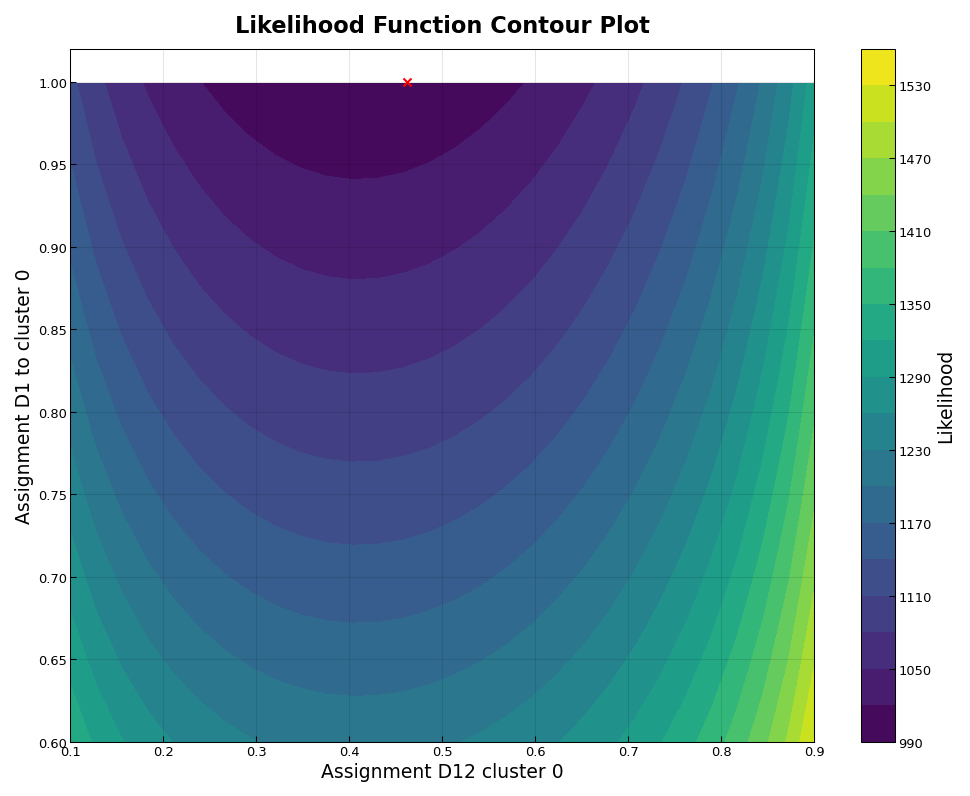

In [356]:
# Define a grid of parameter values
x_values = np.linspace(0.1, 0.9, 30)  # 100 points between 0 and 1 for the first parameter
y_values = np.linspace(0.6, 0.999, 30)  # 100 points between 0 and 1 for the second parameter

# Create a meshgrid from the parameter values
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Calculate the likelihood for each combination of parameter values
likelihood_values = np.zeros_like(x_grid)

for i in range(len(x_values)):
    for j in range(len(y_values)):
        params = [y_values[j], weights[1], x_values[i]]
        likelihood_values[j][i] = expectation_llh_2_cl(params, models)

# Create a contour plot of the likelihood function
plt.figure(figsize=(8, 6))
contour = plt.contourf(x_grid, y_grid, likelihood_values, cmap='viridis', levels = 20)
plt.colorbar(contour, label='Likelihood')
plt.xlabel('Assignment D12 cluster 0')
plt.ylabel('Assignment D1 to cluster 0')
plt.title('Likelihood Function Contour Plot')
plt.scatter(weights[2], weights[0], color = 'red', marker = 'x', s = 15)
plt.grid(True)

plt.savefig(PLOT_PATH / "exp_llh_D10_D120_r04.svg")
plt.show()


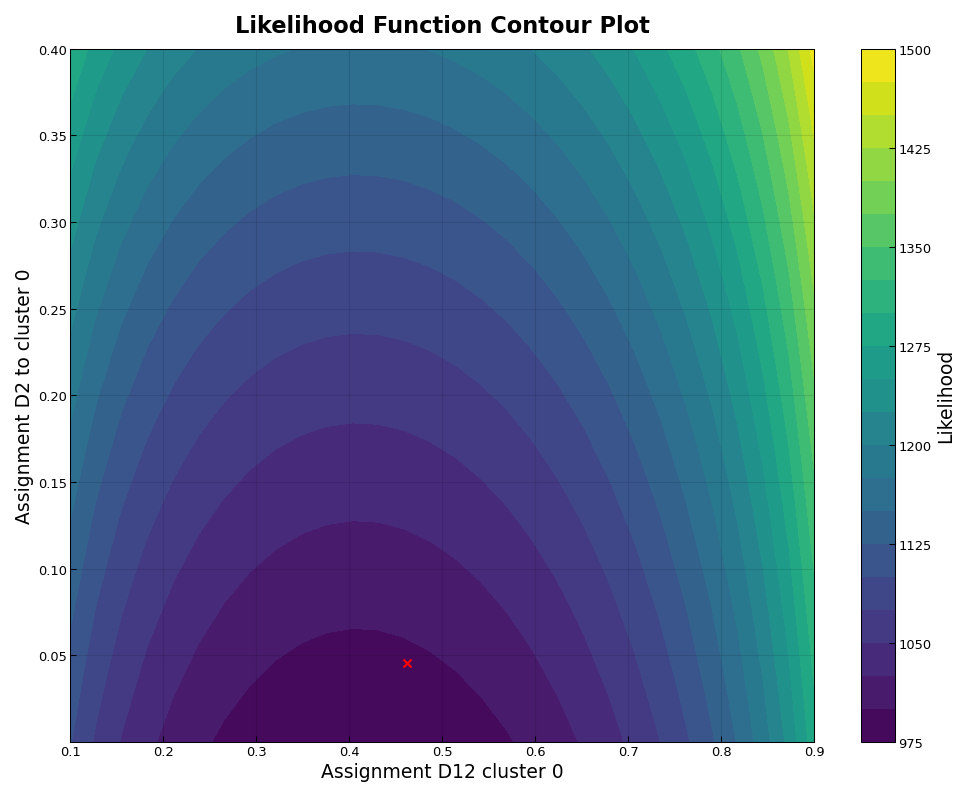

In [355]:
# Define a grid of parameter values
x_values = np.linspace(0.1, 0.9, 30)  # 100 points between 0 and 1 for the first parameter
y_values = np.linspace(0.0001, 0.4, 30)  # 100 points between 0 and 1 for the second parameter

# Create a meshgrid from the parameter values
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Calculate the likelihood for each combination of parameter values
likelihood_values = np.zeros_like(x_grid)

for i in range(len(x_values)):
    for j in range(len(y_values)):
        params = [weights[0], y_values[j],  x_values[i]]
        likelihood_values[j][i] = expectation_llh_2_cl(params, models)

# Create a contour plot of the likelihood function
plt.figure(figsize=(8, 6))
contour = plt.contourf(x_grid, y_grid, likelihood_values, cmap='viridis', levels = 20)
plt.colorbar(contour, label='Likelihood')
plt.xlabel('Assignment D12 cluster 0')
plt.ylabel('Assignment D2 to cluster 0')
plt.title('Likelihood Function Contour Plot')
plt.scatter(weights[2], weights[1], color = 'red', marker = 'x', s = 15)
plt.grid(True)

plt.savefig(PLOT_PATH / "exp_llh_D20_D120_r04.svg")
plt.show()

<Figure size 960x720 with 0 Axes>

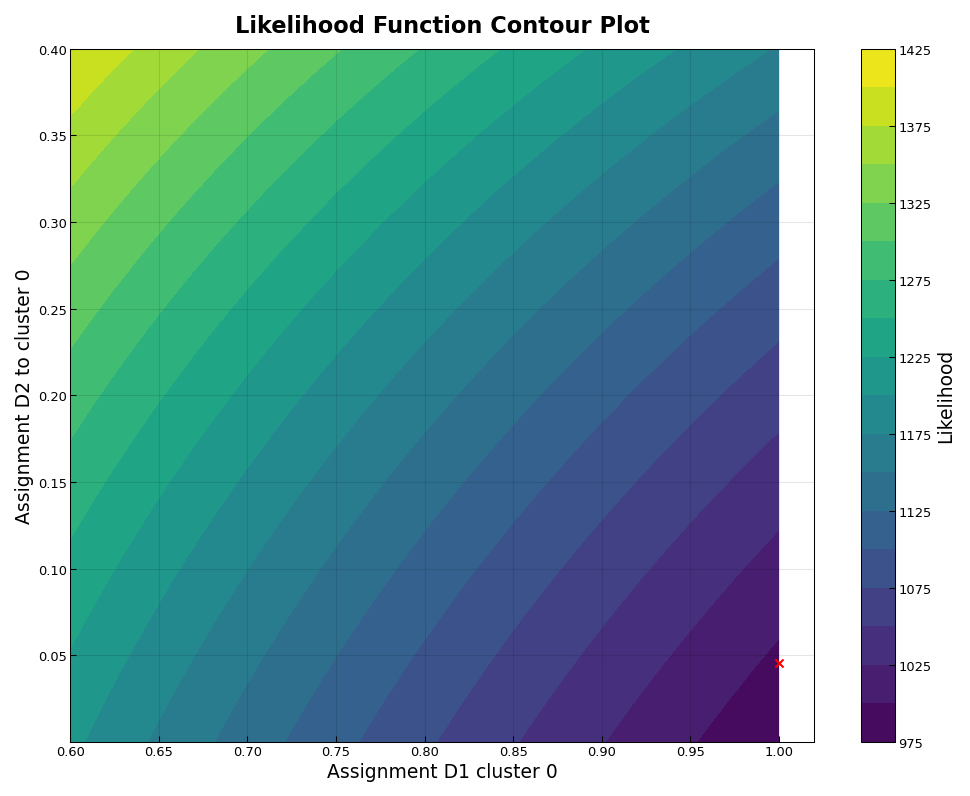

In [354]:
# Define a grid of parameter values
x_values = np.linspace(0.6, 0.9999, 30)  # 100 points between 0 and 1 for the first parameter
y_values = np.linspace(0.0001, 0.4, 30)  # 100 points between 0 and 1 for the second parameter

# Create a meshgrid from the parameter values
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Calculate the likelihood for each combination of parameter values
likelihood_values = np.zeros_like(x_grid)

for i in range(len(x_values)):
    for j in range(len(y_values)):
        params = [x_values[i], y_values[j],  weights[2]]
        likelihood_values[j][i] = expectation_llh_2_cl(params, models)

# Create a contour plot of the likelihood function
plt.figure(figsize=(8, 6))
contour = plt.contourf(x_grid, y_grid, likelihood_values, cmap='viridis', levels = 20)
plt.colorbar(contour, label='Likelihood')
plt.xlabel('Assignment D1 cluster 0')
plt.ylabel('Assignment D2 to cluster 0')
plt.title('Likelihood Function Contour Plot')
plt.scatter(weights[0], weights[1], color = 'red', marker = 'x', s = 15)
plt.grid(True)
plt.savefig(PLOT_PATH / "exp_llh_D10_D20_r04.svg")
plt.show()



In [172]:
## MLE of the model parameters?

In [213]:
maximation_llh_2_cluster_fixed_weights([0, 0, 0, 1.], weights, inverted = True)

10000

In [221]:
weights_true = [1,0,0.4]

In [361]:
def expectation_pi1_0(p, fixed_p, models):
    if isinstance(p, list):
        p = p[0]
    params = [p, *fixed_p]
    return expectation_llh_2_cl(params, models)
def expectation_pi2_0(p, fixed_p, models):
    if isinstance(p, list):
        p = p[0]
    params = [fixed_p[0], p, fixed_p[1]]
    return expectation_llh_2_cl(params, models)
def expectation_pi12_0(p, fixed_p, models):
    if isinstance(p, list):
        p = p[0]
    params = [*fixed_p, p]
    return expectation_llh_2_cl(params, models)

In [360]:
initial_guess = np.random.random(1)
res = minimize(expectation_pi1_0, initial_guess, args = ([weights[1], weights[2]], models), method='L-BFGS-B')
res.x

array([0.98789964])

In [364]:
n_subsites = 3
n_clusters = 2

n_params = 4
initial_weights = [1,0,0] # wheights of D1, D2, D12 corresponsing to cluster 0

models = create_models(n_subsites, graph_lnl_I_II, include_late=False, n_mixture_components=n_clusters )
for i, (k,v) in enumerate(data_synth.items()):
    models[i].load_patient_data(v, side='ipsi')
MODELS = models

In [375]:
base_name = "2cl_mle_indp_e_d1d2d12_r04"
weights = [0.5,0.5,0.5]
model_params = None

param_bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
weights_hist = []
model_params_hist = []
llh_hist=[]
steps = [str(i) for i in range(20)]
for step in steps:
    print(f"Step {step} " + "-"*100)
    # Expectation
    if model_params is not None:
        llhs_e = []
        weights_e = []

        MODELS = assign_model_params(model_params, n_clusters, models)
        bounds = [(0,1), (0,1), (0,1)]
        new_weights = []
        for i in range(3):
            wbu = []
            initial_guess = np.random.random(1)
            res = minimize(expectation_pi1_0, initial_guess, args = ([weights[1], weights[2]], models), method='L-BFGS-B')
            wbu.append(res.x[0])
            res = minimize(expectation_pi2_0, initial_guess, args = ([weights[1], weights[2]], models), method='L-BFGS-B')
            wbu.append(res.x[0])
            res = minimize(expectation_pi12_0, initial_guess, args = ([weights[0], weights[1]], models), method='L-BFGS-B')
            wbu.append(res.x[0])
            llhs_e.append(maximation_llh_2_cluster_fixed_weights(model_params_01, new_weights))
            weights_e.append(wbu)

        weights = weights_e[np.argmax(llhs_e)]
        print(f"Expectation yields: {weights}")
        np.save(f"./samples/em_samples/" + f"E{step}_{base_name}", weights)

        #Maximation
    
    sample_name = f"em_samples/M{step}_{base_name}"
    llhs_m = []
    params_m = []
    for i in range(5):
        initial_guess = np.random.random(n_params)
        result = minimize(
            maximation_llh_2_cluster_fixed_weights_inv,
            initial_guess,
            args=(weights),
            bounds=param_bounds,
        )
        llhs_m.append(-result.fun)
        params_m.append(result.x)
    model_params = params_m[np.argmax(llhs_m)]
    # Maximization Results

    print(f"Maximation yields: {model_params_01}")
    weights_hist.append(weights)
    model_params_hist.append(model_params)
    llh_hist.append(np.max(llhs_m))


Step 0 ----------------------------------------------------------------------------------------------------
Maximation yields: [0.36776313 0.         0.         0.79591389]
Step 1 ----------------------------------------------------------------------------------------------------
Expectation yields: [8.405499075898881e-05, 0.999765492297318, 0.5634110417383725]
Maximation yields: [0.36776313 0.         0.         0.79591389]
Step 2 ----------------------------------------------------------------------------------------------------
Expectation yields: [0.032329338204967, 0.9833135572514093, 0.6007568628782105]
Maximation yields: [0.36776313 0.         0.         0.79591389]
Step 3 ----------------------------------------------------------------------------------------------------
Expectation yields: [2.1818532698980033e-05, 0.9999821378410276, 0.6046037547192415]
Maximation yields: [0.36776313 0.         0.         0.79591389]
Step 4 -----------------------------------------------------

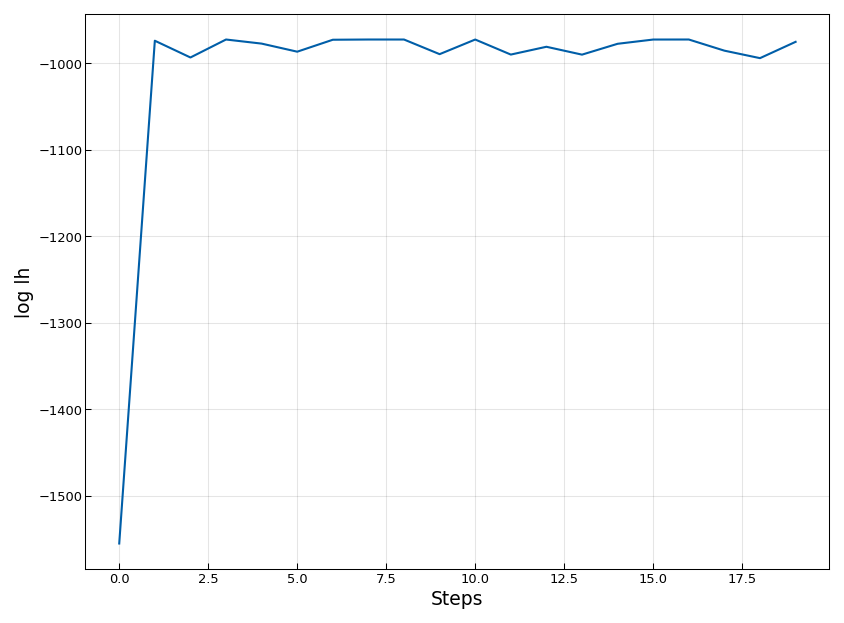

In [392]:
# Inspect llh
plt.plot(range(len(llh_hist)), llh_hist, label = 'Likelihood')
plt.xlabel('Steps')
plt.ylabel('log lh')
plt.savefig(PLOT_PATH / "hist_llh.svg")
plt.show()


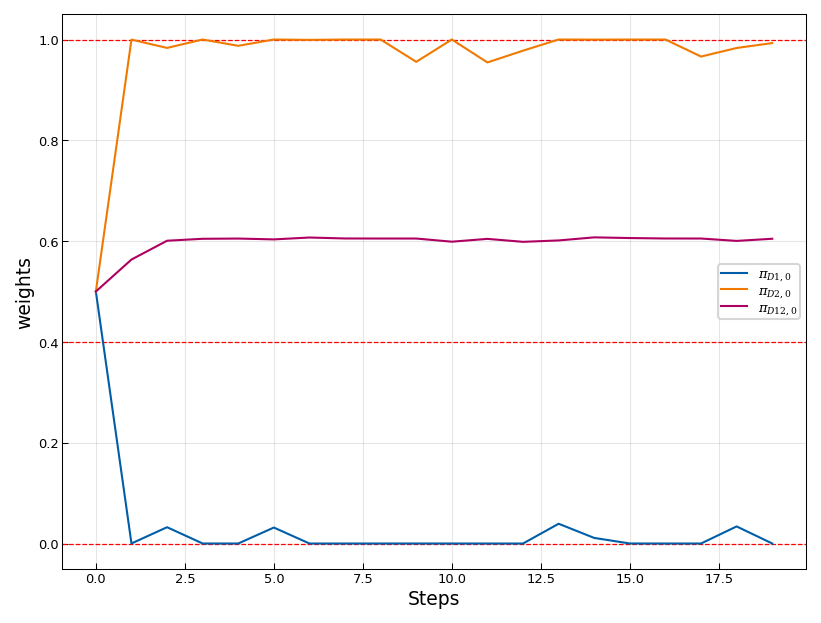

In [393]:
# Inspect llh
fig,ax = plt.subplots(1)
for p in weights_true:
    ax.axhline(p, c='red', linestyle = '--', linewidth = '.6')
ax.plot(range(len(weights_hist)), [w[0] for w in weights_hist], label = r'$\pi_{D1,0}$')
ax.plot(range(len(weights_hist)), [w[1] for w in weights_hist], label = r'$\pi_{D2,0}$')
ax.plot(range(len(weights_hist)), [w[2] for w in weights_hist], label = r'$\pi_{D12,0}$')
plt.xlabel('Steps')
plt.ylabel('weights')
plt.legend()
plt.savefig(PLOT_PATH / "hist_weights.svg")
plt.show()

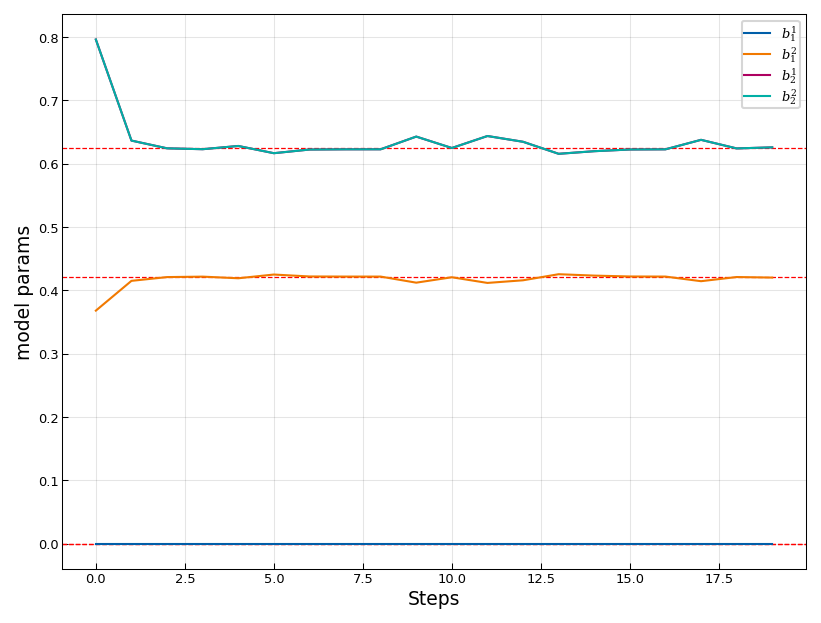

In [394]:
# Inspect llh
fig,ax = plt.subplots(1)
for p in mle_params:
    ax.axhline(p, c='red', linestyle = '--', linewidth = '.6')
ax.plot(range(len(model_params_hist)), [w[0] for w in model_params_hist], label = r'$b_1^1$')
ax.plot(range(len(model_params_hist)), [w[1] for w in model_params_hist], label = r'$b_1^2$')
ax.plot(range(len(model_params_hist)), [w[2] for w in model_params_hist], label = r'$b_2^1$')
ax.plot(range(len(model_params_hist)), [w[2] for w in model_params_hist], label = r'$b_2^2$')

plt.xlabel('Steps')
plt.ylabel('model params')
plt.legend()
plt.savefig(PLOT_PATH / "hist_modelparams.svg")
plt.show()

In [ ]:
n_subsites = 3
n_clusters = 2

n_params = 4
initial_weights = [1,0,0] # wheights of D1, D2, D12 corresponsing to cluster 0

models = create_models(n_subsites, graph_lnl_I_II, include_late=False, n_mixture_components=n_clusters )
for i, (k,v) in enumerate(data_synth.items()):
    models[i].load_patient_data(v, side='ipsi')
MODELS = models

In [395]:
base_name = "2cl_mle_indp_e_d1d2d12_r04"
weights = [0.5,0.5,0.5]
model_params = None

param_bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
weights_hist = []
model_params_hist = []
llh_hist=[]
steps = [str(i) for i in range(20)]
for step in steps:
    print(f"Step {step} " + "-"*100)
    # Expectation
    if model_params is not None:
        llhs_e = []
        weights_e = []

        MODELS = assign_model_params(model_params, n_clusters, models)
        bounds = [(0,1), (0,1), (0,1)]
        new_weights = []
        for i in range(3):
            wbu = []
            initial_guess = np.random.random(3)
            res = minimize(expectation_llh_2_cl, initial_guess, args = (models), method='L-BFGS-B')
            wbu.append(res.x)
            llhs_e.append(maximation_llh_2_cluster_fixed_weights(model_params_01, res.x))
            weights_e.append(res.x)

        weights = weights_e[np.argmax(llhs_e)]
        print(f"Expectation yields: {weights}")
        # np.save(f"./samples/em_samples/" + f"E{step}_{base_name}", weights)

        #Maximation
    
    sample_name = f"em_samples/M{step}_{base_name}"
    llhs_m = []
    params_m = []
    for i in range(5):
        initial_guess = np.random.random(n_params)
        result = minimize(
            maximation_llh_2_cluster_fixed_weights_inv,
            initial_guess,
            args=(weights),
            bounds=param_bounds,
        )
        llhs_m.append(-result.fun)
        params_m.append(result.x)
    model_params = params_m[np.argmax(llhs_m)]
    # Maximization Results

    print(f"Maximation yields: {model_params_01}")
    weights_hist.append(weights)
    model_params_hist.append(model_params)
    llh_hist.append(np.max(llhs_m))


Step 0 ----------------------------------------------------------------------------------------------------
Maximation yields: [0.36776313 0.         0.         0.79591389]
Step 1 ----------------------------------------------------------------------------------------------------
Expectation yields: [0.99995804 0.01445497 0.44934472]
Maximation yields: [0.36776313 0.         0.         0.79591389]
Step 2 ----------------------------------------------------------------------------------------------------
Expectation yields: [1.         0.04091908 0.40082854]
Maximation yields: [0.36776313 0.         0.         0.79591389]
Step 3 ----------------------------------------------------------------------------------------------------
Expectation yields: [0.95872531 0.08216383 0.47772733]
Maximation yields: [0.36776313 0.         0.         0.79591389]
Step 4 ----------------------------------------------------------------------------------------------------
Expectation yields: [0.97366439 0.1

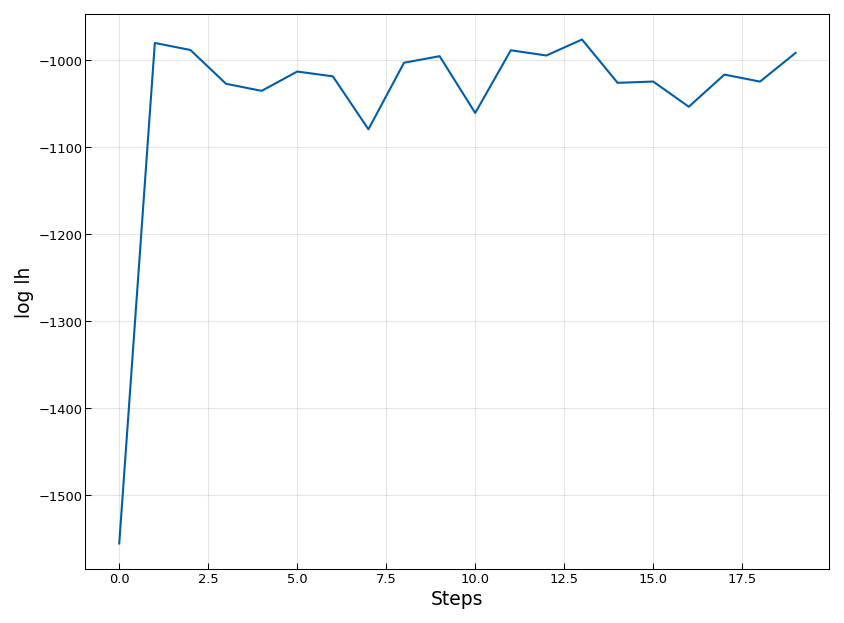

In [399]:
# Inspect llh
plt.plot(range(len(llh_hist)), llh_hist, label = 'Likelihood')
plt.xlabel('Steps')
plt.ylabel('log lh')
plt.savefig(PLOT_PATH / "hist_llh.svg")
plt.show()


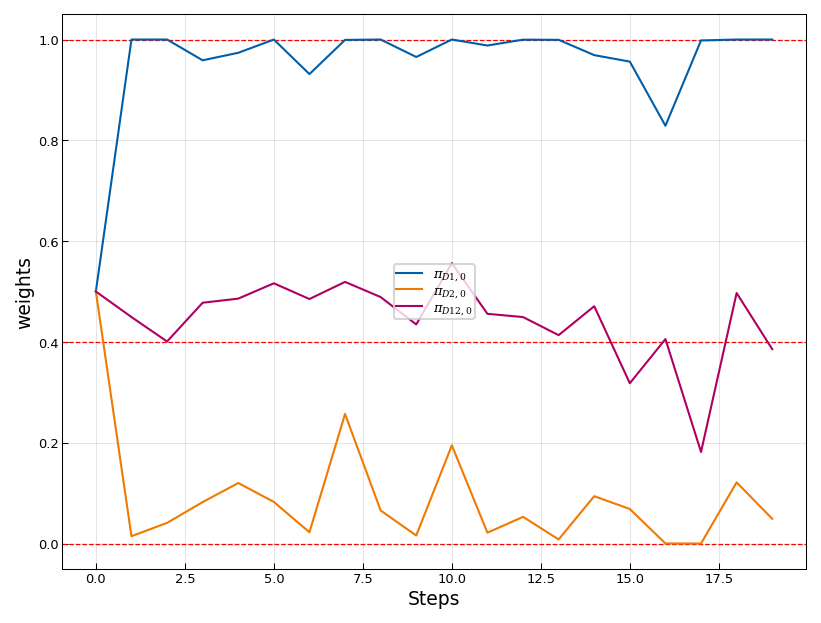

In [396]:
# Inspect llh
fig,ax = plt.subplots(1)
for p in weights_true:
    ax.axhline(p, c='red', linestyle = '--', linewidth = '.6')
ax.plot(range(len(weights_hist)), [w[0] for w in weights_hist], label = r'$\pi_{D1,0}$')
ax.plot(range(len(weights_hist)), [w[1] for w in weights_hist], label = r'$\pi_{D2,0}$')
ax.plot(range(len(weights_hist)), [w[2] for w in weights_hist], label = r'$\pi_{D12,0}$')
plt.xlabel('Steps')
plt.ylabel('weights')
plt.legend()
plt.savefig(PLOT_PATH / "hist_weights.svg")
plt.show()

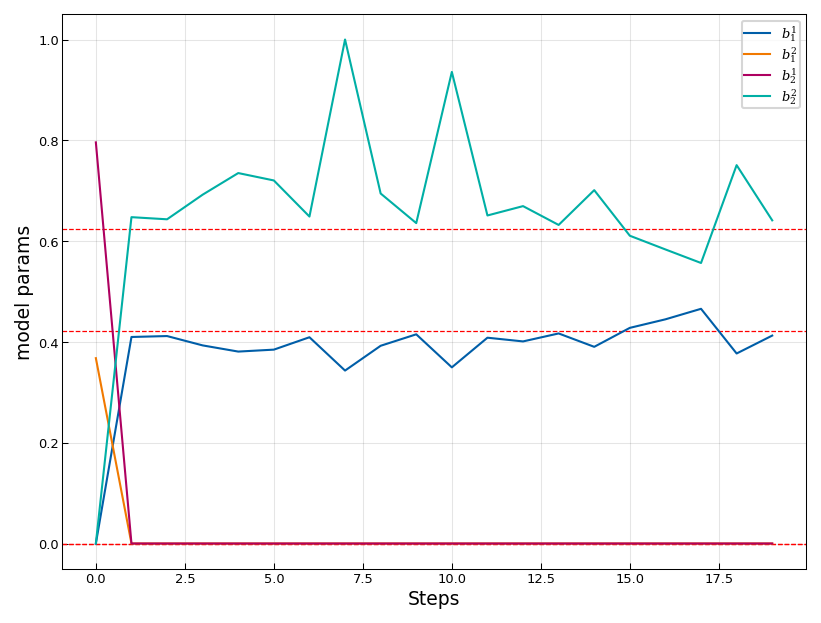

In [398]:
# Inspect llh
fig,ax = plt.subplots(1)
for p in mle_params:
    ax.axhline(p, c='red', linestyle = '--', linewidth = '.6')
ax.plot(range(len(model_params_hist)), [w[0] for w in model_params_hist], label = r'$b_1^1$')
ax.plot(range(len(model_params_hist)), [w[1] for w in model_params_hist], label = r'$b_1^2$')
ax.plot(range(len(model_params_hist)), [w[2] for w in model_params_hist], label = r'$b_2^1$')
ax.plot(range(len(model_params_hist)), [w[3] for w in model_params_hist], label = r'$b_2^2$')

plt.xlabel('Steps')
plt.ylabel('model params')
plt.legend()
plt.savefig(PLOT_PATH / "hist_modelparams.svg")
plt.show()

# Real Data
Now we go back to real data again, to see wether the results are stable.

In [11]:

def maximation_llh_2_cluster_fixed_weights(params, fixed_weights, n_clusters=2):
    global MODELS
    return_val = -10000
    for p in params:
        if p < 0 or 1 < p:
            return return_val 
    theta = [*params, *fixed_weights]
    model_params, mixing_params = convert_params(theta, n_clusters, len(MODELS))

    log_sum = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = mixing_params[i]
        log_sum += model.likelihood(given_param_args = model_params, log = True)
    if np.isnan(log_sum):
        return return_val

    if np.isinf(log_sum):
        return return_val
    else:
        return log_sum 
    
def maximation_llh_2_cluster_fixed_weights_inv(params, fixed_weights, inverted = True, n_clusters=2):
    global MODELS
    return_val = -10000
    if inverted:
        return_val = 10000
    for p in params:
        if p < 0 or 1 < p:
            return return_val 
    theta = [*params, *fixed_weights]
    model_params, mixing_params = convert_params(theta, n_clusters, len(MODELS))

    log_sum = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = mixing_params[i]
        log_sum += model.likelihood(given_param_args = model_params, log = True)
    if np.isnan(log_sum):
        return return_val

    if np.isinf(log_sum):
        return return_val
    if inverted:
        return -log_sum
    else:
        return log_sum 


def expectation_llh_2_cl(params, inverted = True):
    global MODELS
    # For now works only with 2 clusters
    for p in params:
        if p < 0 or 1 < p:
            return 10000 if inverted else -10000
    llh = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = [params[i], 1 - params[i]]
        llh += model.likelihood()
    if inverted: 
        return -llh
    else:
        return llh
    
def assign_model_params(params, n_clusters,n_params_base = None):
    global MODELS
    if n_params_base is None:
        model_params, mixing_params = convert_params(params, n_clusters, len(MODELS))
    else:
        model_params = [[params[j*n_clusters+i] for i in range(n_clusters)] for j in range(n_params_base)]
    for i, model in enumerate(MODELS):
        model.assign_params(*model_params)


def expectation_pi1_0(p, fixed_p):
    if isinstance(p, list):
        p = p[0]
    params = [p, *fixed_p]
    return expectation_llh_2_cl(params)
def expectation_pi2_0(p, fixed_p):
    if isinstance(p, list):
        p = p[0]
    params = [fixed_p[0], p, fixed_p[1]]
    return expectation_llh_2_cl(params)
def expectation_pi12_0(p, fixed_p):
    if isinstance(p, list):
        p = p[0]
    params = [*fixed_p, p]
    return expectation_llh_2_cl(params)


def log_prob_fn(theta):
    global MODEL
    for t in theta:
        if t<0 or 1<t:
            return -10000
    llh = MODEL.likelihood(given_param_args = theta, log=True)
    if np.isnan(llh):
        llh = -10000
    if np.isinf(llh):
        llh = -10000
    return llh


def log_prob_n_models(params):
    global MODELS
    # For now works only with 2 clusters
    for p in params:
        if p < 0 or 1 < p:
            return -10000
    params_model = [[params[i], params[i+1]] for i in range(0,int(len(params)), 2)]
    llh = 0
    for i, model in enumerate(MODELS):
        llh += model.likelihood(given_param_args = params_model, log=True)
    if np.isnan(llh):
        llh = -10000
    if np.isinf(llh):
        llh = -10000
    return llh

    

In [12]:
list(range(0,int(10), 2))

[0, 2, 4, 6, 8]

In [13]:
# Read the data and prepare for subsite analyis.
datasets_names = ["2022_CLB_multisite_enhanced.csv", "2022_CLB_oropharynx_enhanced.csv", "2022-ISB-multisite_enhanced.csv"]
dataset = pd.DataFrame({})
for ds in datasets_names:
    dataset_new = pd.read_csv(Path("../../data/datasets/enhanced/" + ds), header=[0, 1, 2])
    dataset = pd.concat([dataset, dataset_new], ignore_index=True)
print(f"Succesfully loaded {len(dataset)} Patients")

# 
subsites_list = list(dataset['tumor']["1"]["subsite"])
major_subsites = [s[:3] for s in subsites_list]
dataset['tumor', "1", "majorsubsites"] = major_subsites

convert_t_stage = {
            0: "early",
            1: "early",
            2: "early",
            3: "late",
            4: "late"
        }
t_stages = list(dataset[("tumor", "1", "t_stage")].apply(lambda t: convert_t_stage[t]))
#data["tumor", "1", "t_stage"] = t_stages
dataset_ignore_t = dataset.copy(deep=True)
dataset[('info', 'tumor', 't_stage')] = t_stages
dataset_ignore_t[('info', 'tumor', 't_stage')] = ['all']*len(dataset)
dataset.head()

# # For reference (or initial clustering), cluster the subsites based on the location
# location_to_cluster = {
#     'oral cavity': 0,
#     'oropharynx': 1,
#     'hypopharynx': 2,
#     'larynx': 3
# }
# data["tumor","1","clustering"] = data["tumor"]["1"]["location"].apply(lambda x: location_to_cluster[x])

Succesfully loaded 969 Patients


patient                                                                    \
        #                                                                     
       id     sex age diagnose_date alcohol_abuse nicotine_abuse hpv_status   
0    2003    male  60    2006-07-29          True           True        NaN   
1    2004    male  52    2009-04-29          True           True        NaN   
2    2005    male  51    2006-04-12          True           True        NaN   
3    2006  female  49    2004-11-10          True           True      False   
4    2007    male  41    2006-05-10         False           True        NaN   

                                            ... max_llh                     \
                                            ...  contra                      
  neck_dissection tnm_edition stage_prefix  ...     VII     II     Ia   Vb   
0            True           8            p  ...     NaN  False  False  NaN   
1            True           8            p  ...     NaN  False  False  NaN   
2            True           8            p  ...     NaN  False  False  NaN   
3            True           8            p  ...     NaN  False  False  NaN   
4            True           7            p  ...     NaN  False  False  NaN   

                                    tumor    info  
                                        1   tumor  
      Ib  IIa     IV    III majorsubsites t_stage  
0  False  NaN  False  False           C12   early  
1  False  NaN  False  False           C02   early  
2  False  NaN  False  False           C32   early  
3  False  NaN  False  False           C01    late  
4  False  NaN  False  False           C02   early  

[5 rows x 221 columns]

In [14]:
# Define the subsite we want to analyse
s_bucket = {
    "S1" : ['C03', 'C04', 'C06'],
    "S2" : ['C09', 'C01'],
    "S3" : ['C02', 'C05']
}

sdata = {}
sdata_ignore_t = {}
for s, icds in s_bucket.items():
    mask = [False]*len(dataset)
    for icd in icds:
        mask = np.logical_or(mask, dataset["tumor"]["1"]["majorsubsites"] == icd )
    sdata[s] = dataset[mask]
    sdata_ignore_t[s] = dataset_ignore_t[mask]
    

In [15]:
sdata_ignore_t

{'S1':     patient                                                                    \
           #                                                                     
          id     sex age diagnose_date alcohol_abuse nicotine_abuse hpv_status   
 5      2008    male  67    2015-04-14         False          False      False   
 6      2009  female  61    2014-02-18         False           True        NaN   
 8      2011    male  55    2011-11-16         False           True        NaN   
 15     2018    male  63    2012-07-15          True           True        NaN   
 18     2021    male  48    2015-10-20          True           True        NaN   
 ..      ...     ...  ..           ...           ...            ...        ...   
 904     819    male  65    2015-04-15          True           True       True   
 905     820    male  67    2011-01-04          True          False       True   
 907     822    male  71    2018-05-01          True           True      False   
 908     8

Prev Vector: [0.5736842105263158, 0.15263157894736842, 0.10526315789473684, 0.07894736842105263, 0.03684210526315789, 0.005263157894736842, 0.021052631578947368, 0.02631578947368421]
Prev Vector: [0.22285714285714286, 0.002857142857142857, 0.47714285714285715, 0.03142857142857143, 0.045714285714285714, 0.002857142857142857, 0.18, 0.037142857142857144]
Prev Vector: [0.5495049504950495, 0.04455445544554455, 0.2079207920792079, 0.04455445544554455, 0.04455445544554455, 0.01485148514851485, 0.0594059405940594, 0.034653465346534656]


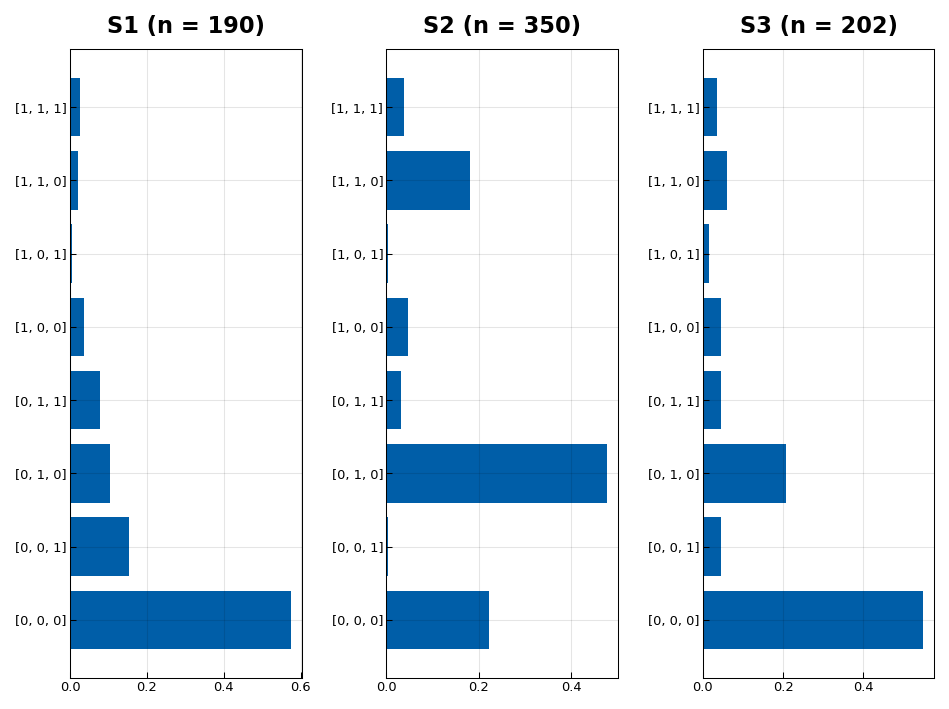

In [22]:
# Inspect the data again
lnls = ['I', 'II', 'III']
fig, ax = plt.subplots(1,3, tight_layout=True)
create_prev_vectors(sdata['S1'], lnls, title=f"S1", plot=True, ax = ax[0])
create_prev_vectors(sdata['S2'], lnls, title=f"S2", plot=True, ax = ax[1])
create_prev_vectors(sdata['S3'], lnls, title=f"S3", plot=True, ax = ax[2])
plt.show()


In [85]:
graph_3lnl = {
            ("tumor", "primary"): ["I", "II", "III"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): [],
        }
models_rd = create_models(3, graph_3lnl, ignore_t_stage=False)

In [86]:
model_s1 = models_rd[0]
model_s1.load_patient_data(sdata['S1'])
model_s2 = models_rd[1]
model_s2.load_patient_data(sdata['S2'])
model_s3 = models_rd[2]
model_s3.load_patient_data(sdata['S3'])

n_params = len(model_s1.get_params())
print(model_s1.get_params())

dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.5])


In [87]:
def log_prob_fn(theta):
    global MODEL
    for t in theta:
        if t<0 or 1<t:
            return -10000
    llh = MODEL.likelihood(given_param_args = theta, log=True)
    if np.isnan(llh):
        llh = -10000
    if np.isinf(llh):
        llh = -10000
    return llh

In [88]:
MODEL = model_s1

In [89]:
log_prob_fn(np.random.random(5))

-528.4816715507712

In [20]:
# Sampling
global MODEL
MODEL = model_s1
sample_name = f"S1_2123_late"
sampling = False
if sampling:
    samples_s1, end_point, llh = emcee_sampling_ext(log_prob_fn, n_params, sample_name, n_burnin = 750, n_step = 500, llh_args = [])
else:
    samples_s1 = np.load("samples/"+sample_name+".npy")

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Lucida Calligraphy
findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'monospace' not found because none of the following families were found: Ubuntu Mono


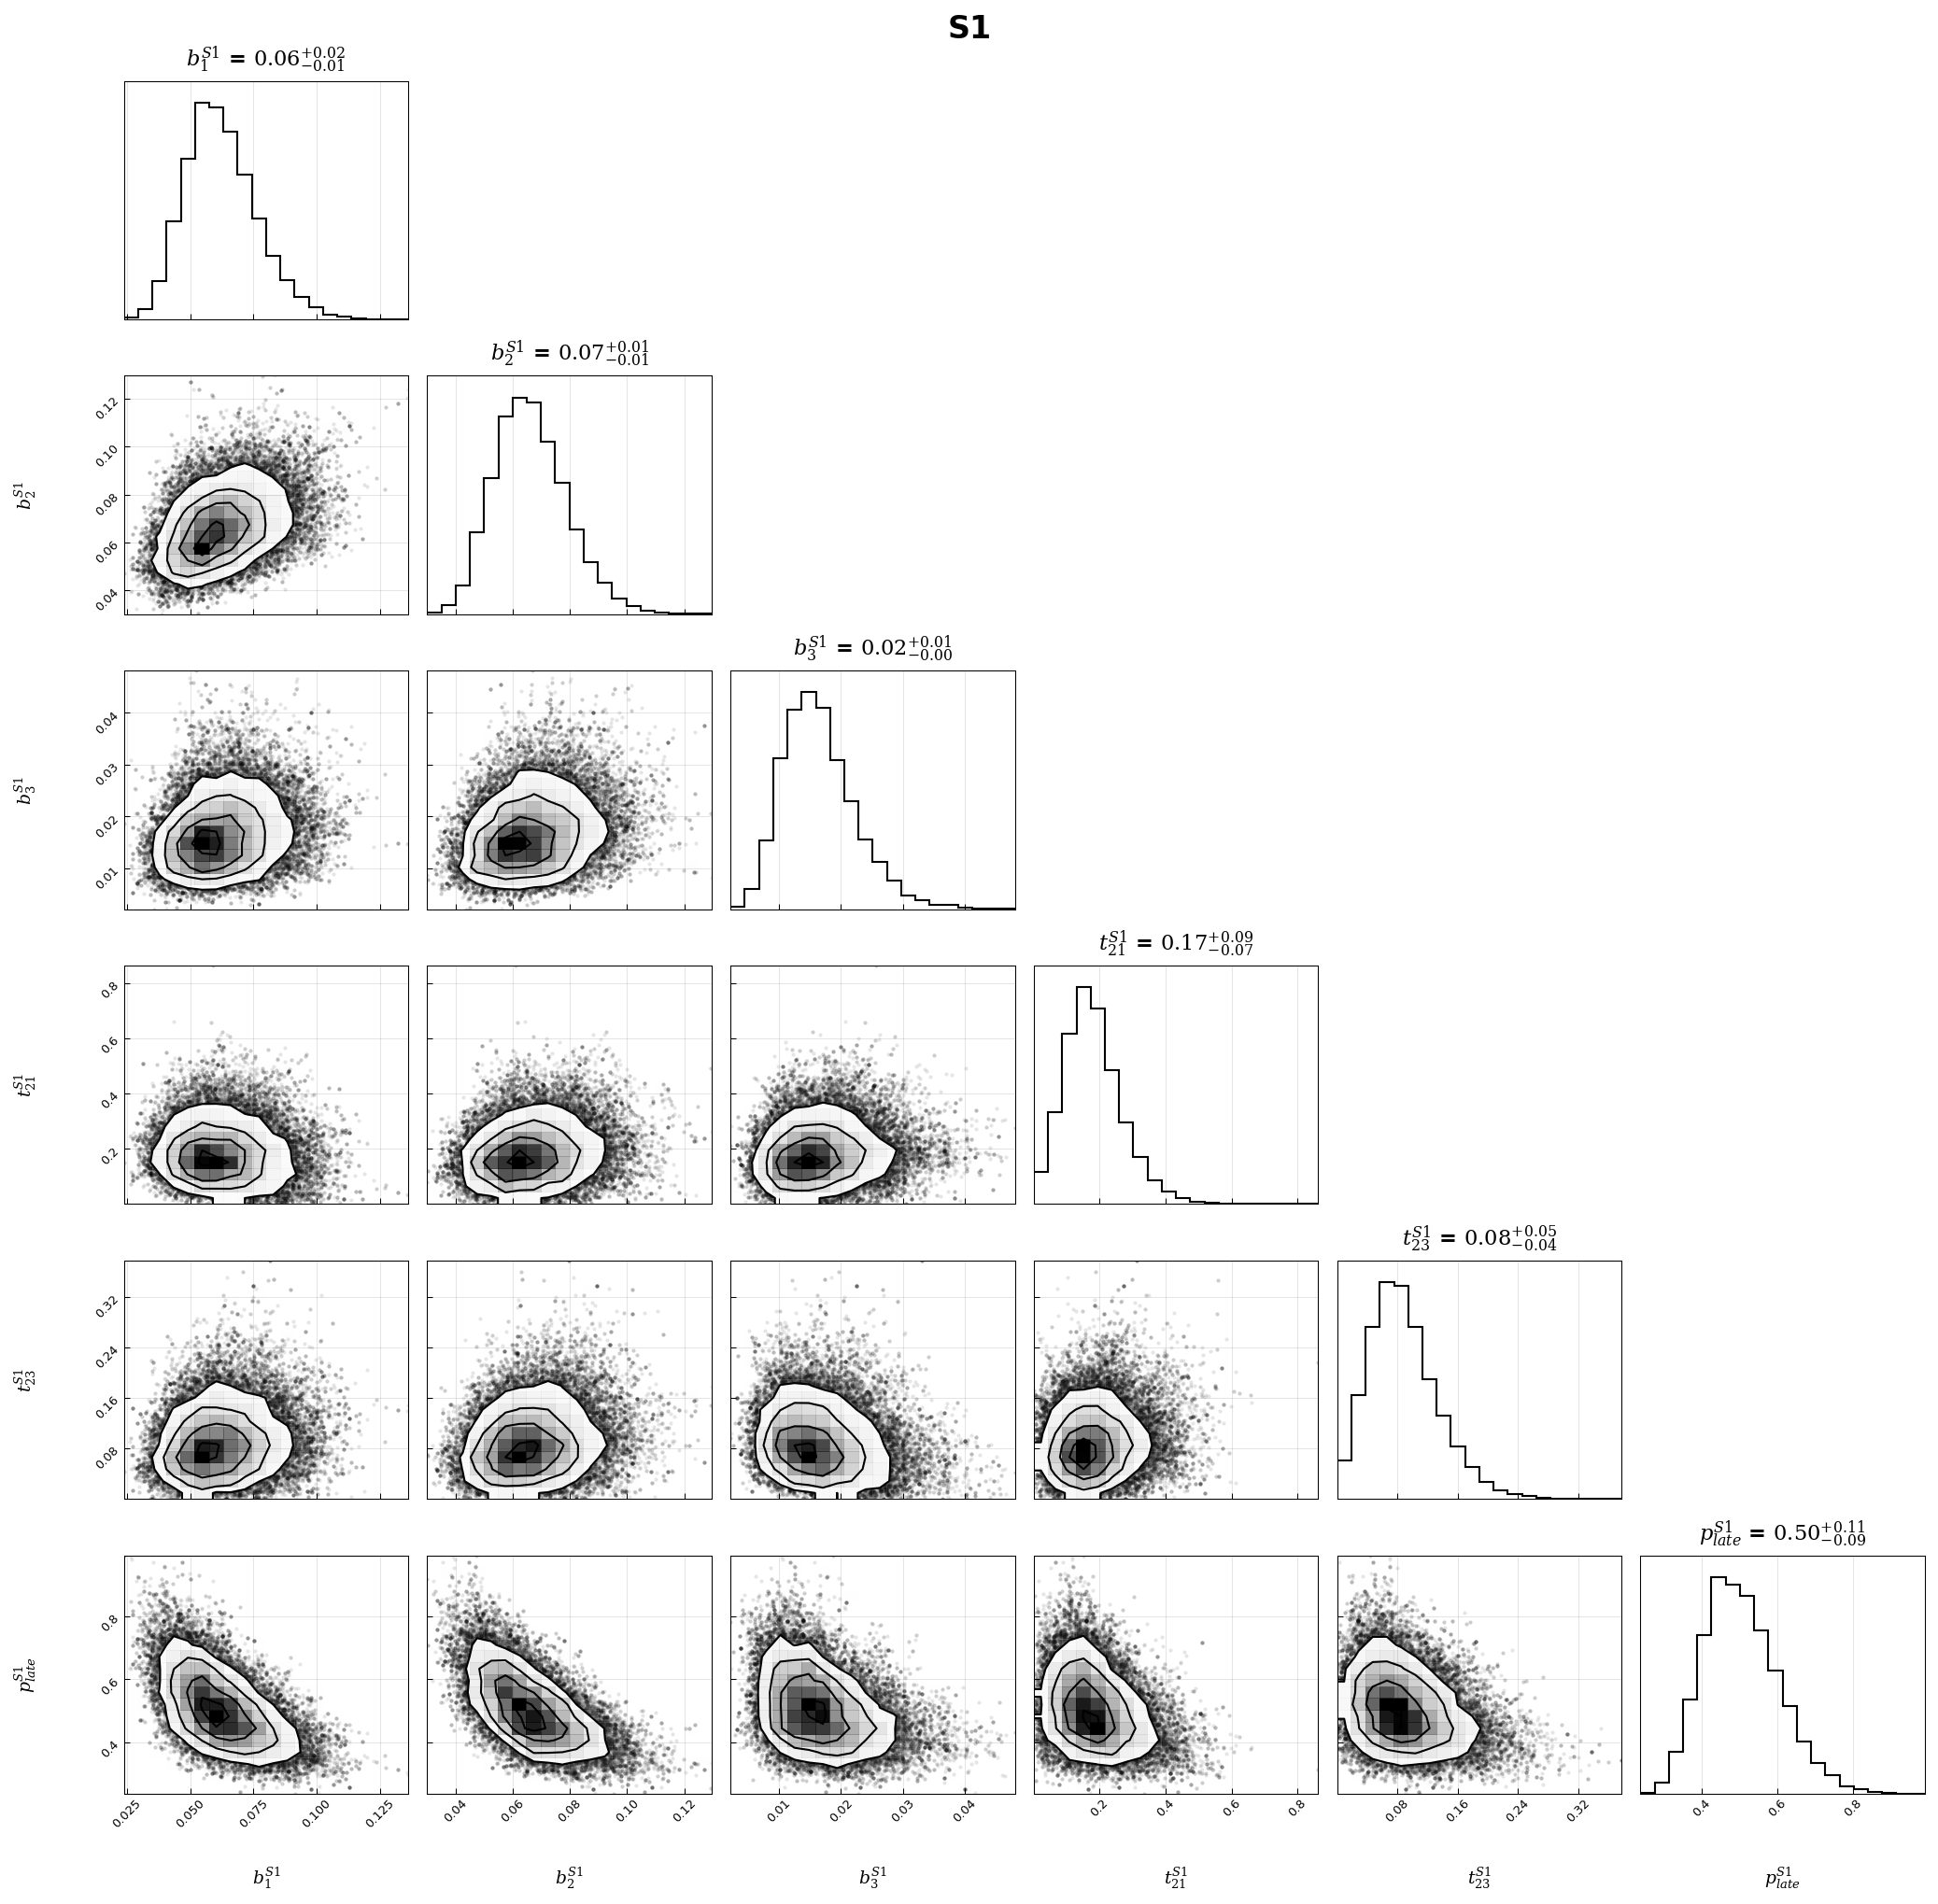

In [16]:
label_names = list(model_s1.get_params(as_dict = True).keys())
label_names = [r'$b_1^{S1}$', r'$b_2^{S1}$', r'$b_3^{S1}$', r'$t_{21}^{S1}$', r'$t_{23}^{S1}$', r'$p_{late}^{S1}$']
fig = corner.corner(
        samples_s1,
        labels=label_names,
        show_titles=True,
    )
fig.suptitle(f'S1', fontsize=16)
fig.tight_layout()
plt.show()
fig.savefig(PLOT_PATH / f"corner_S1_2123_late.png")

In [21]:
# Sampling S2

sampling = False
global MODEL
MODEL = model_s2
sample_name = f"S2_2123_late"
if sampling:
    samples_s2, end_point, llh = emcee_sampling_ext(log_prob_fn, n_params, sample_name, n_burnin = 750, n_step = 500, llh_args = [])
else:
    samples_s2 = np.load("samples/"+sample_name+".npy")

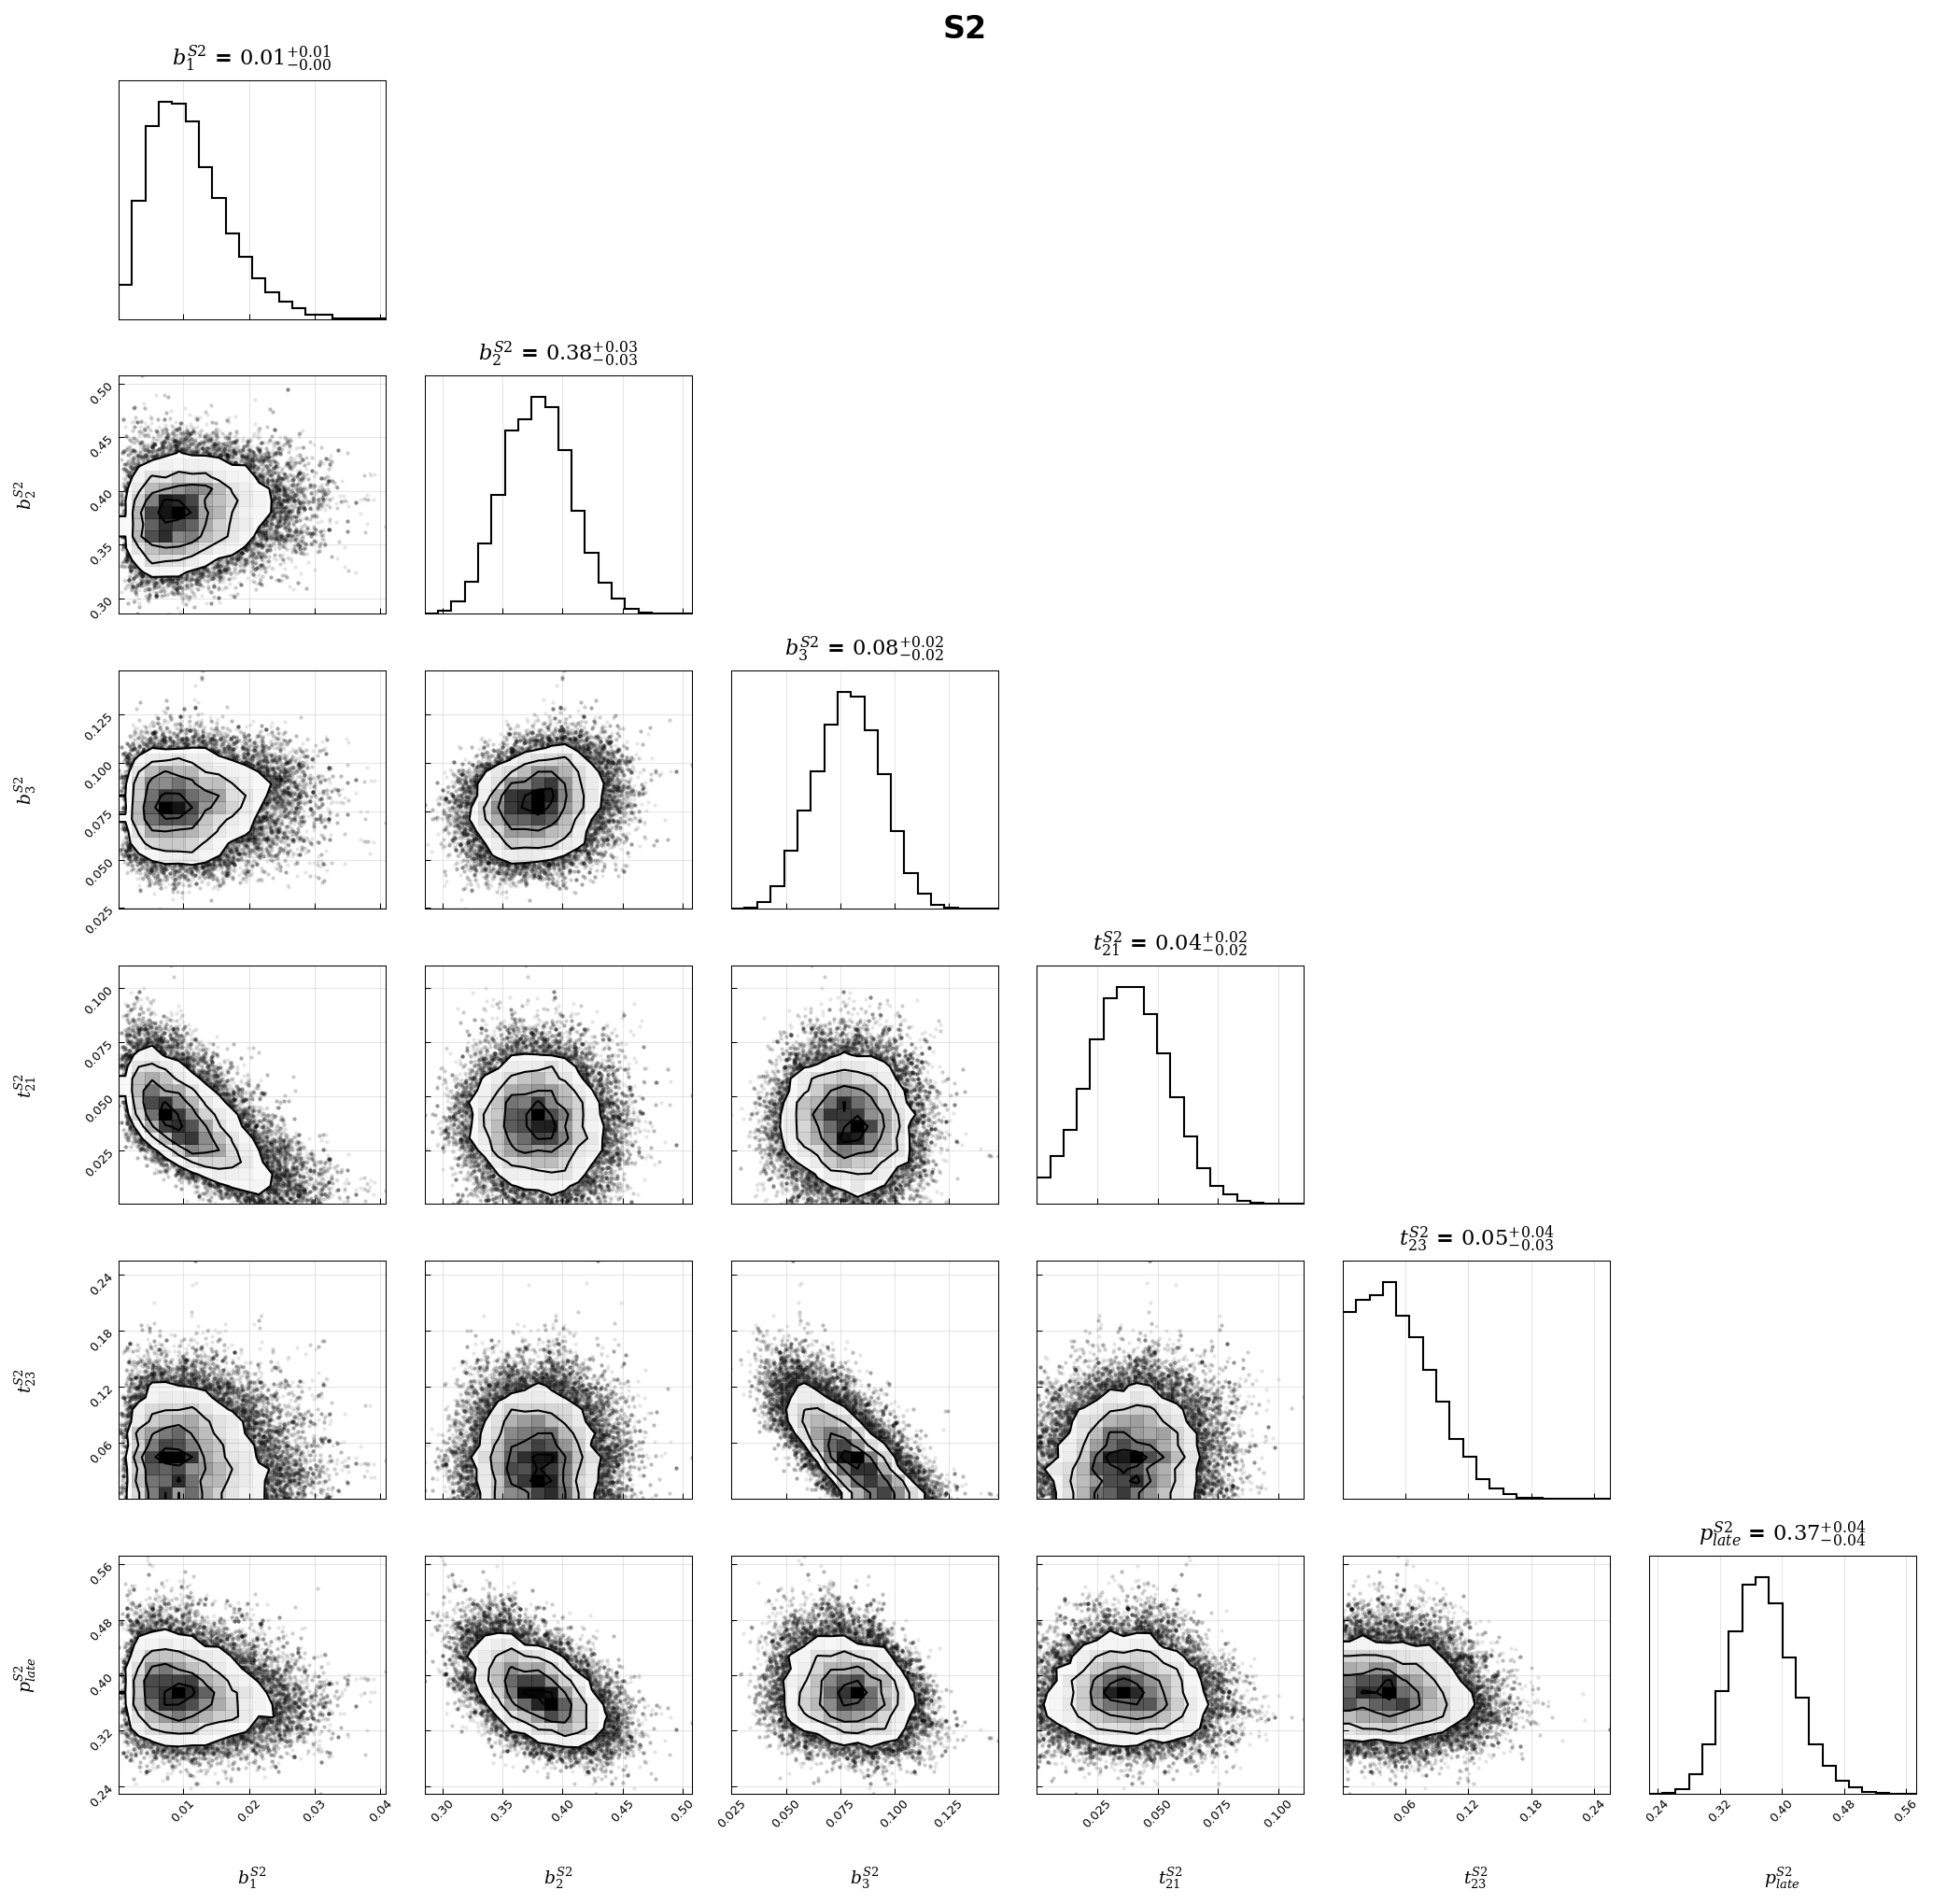

In [18]:
label_names = list(model_s1.get_params(as_dict = True).keys())
label_names = [r'$b_1^{S2}$', r'$b_2^{S2}$', r'$b_3^{S2}$', r'$t_{21}^{S2}$', r'$t_{23}^{S2}$', r'$p_{late}^{S2}$']
fig = corner.corner(
        samples_s2,
        labels=label_names,
        show_titles=True,
    )
fig.suptitle(f'S2', fontsize=16)
fig.tight_layout()
plt.show()
fig.savefig(PLOT_PATH / f"corner_{sample_name}.png")

In [22]:
# Sampling S2

sampling = False
global MODEL
MODEL = model_s3
sample_name = f"S3_2123_late"
if sampling:
    samples_s3, end_point, llh = emcee_sampling_ext(log_prob_fn, n_params, sample_name, n_burnin = 750, n_step = 500, llh_args = [])
else:
    samples_s3 = np.load("samples/"+sample_name+".npy")

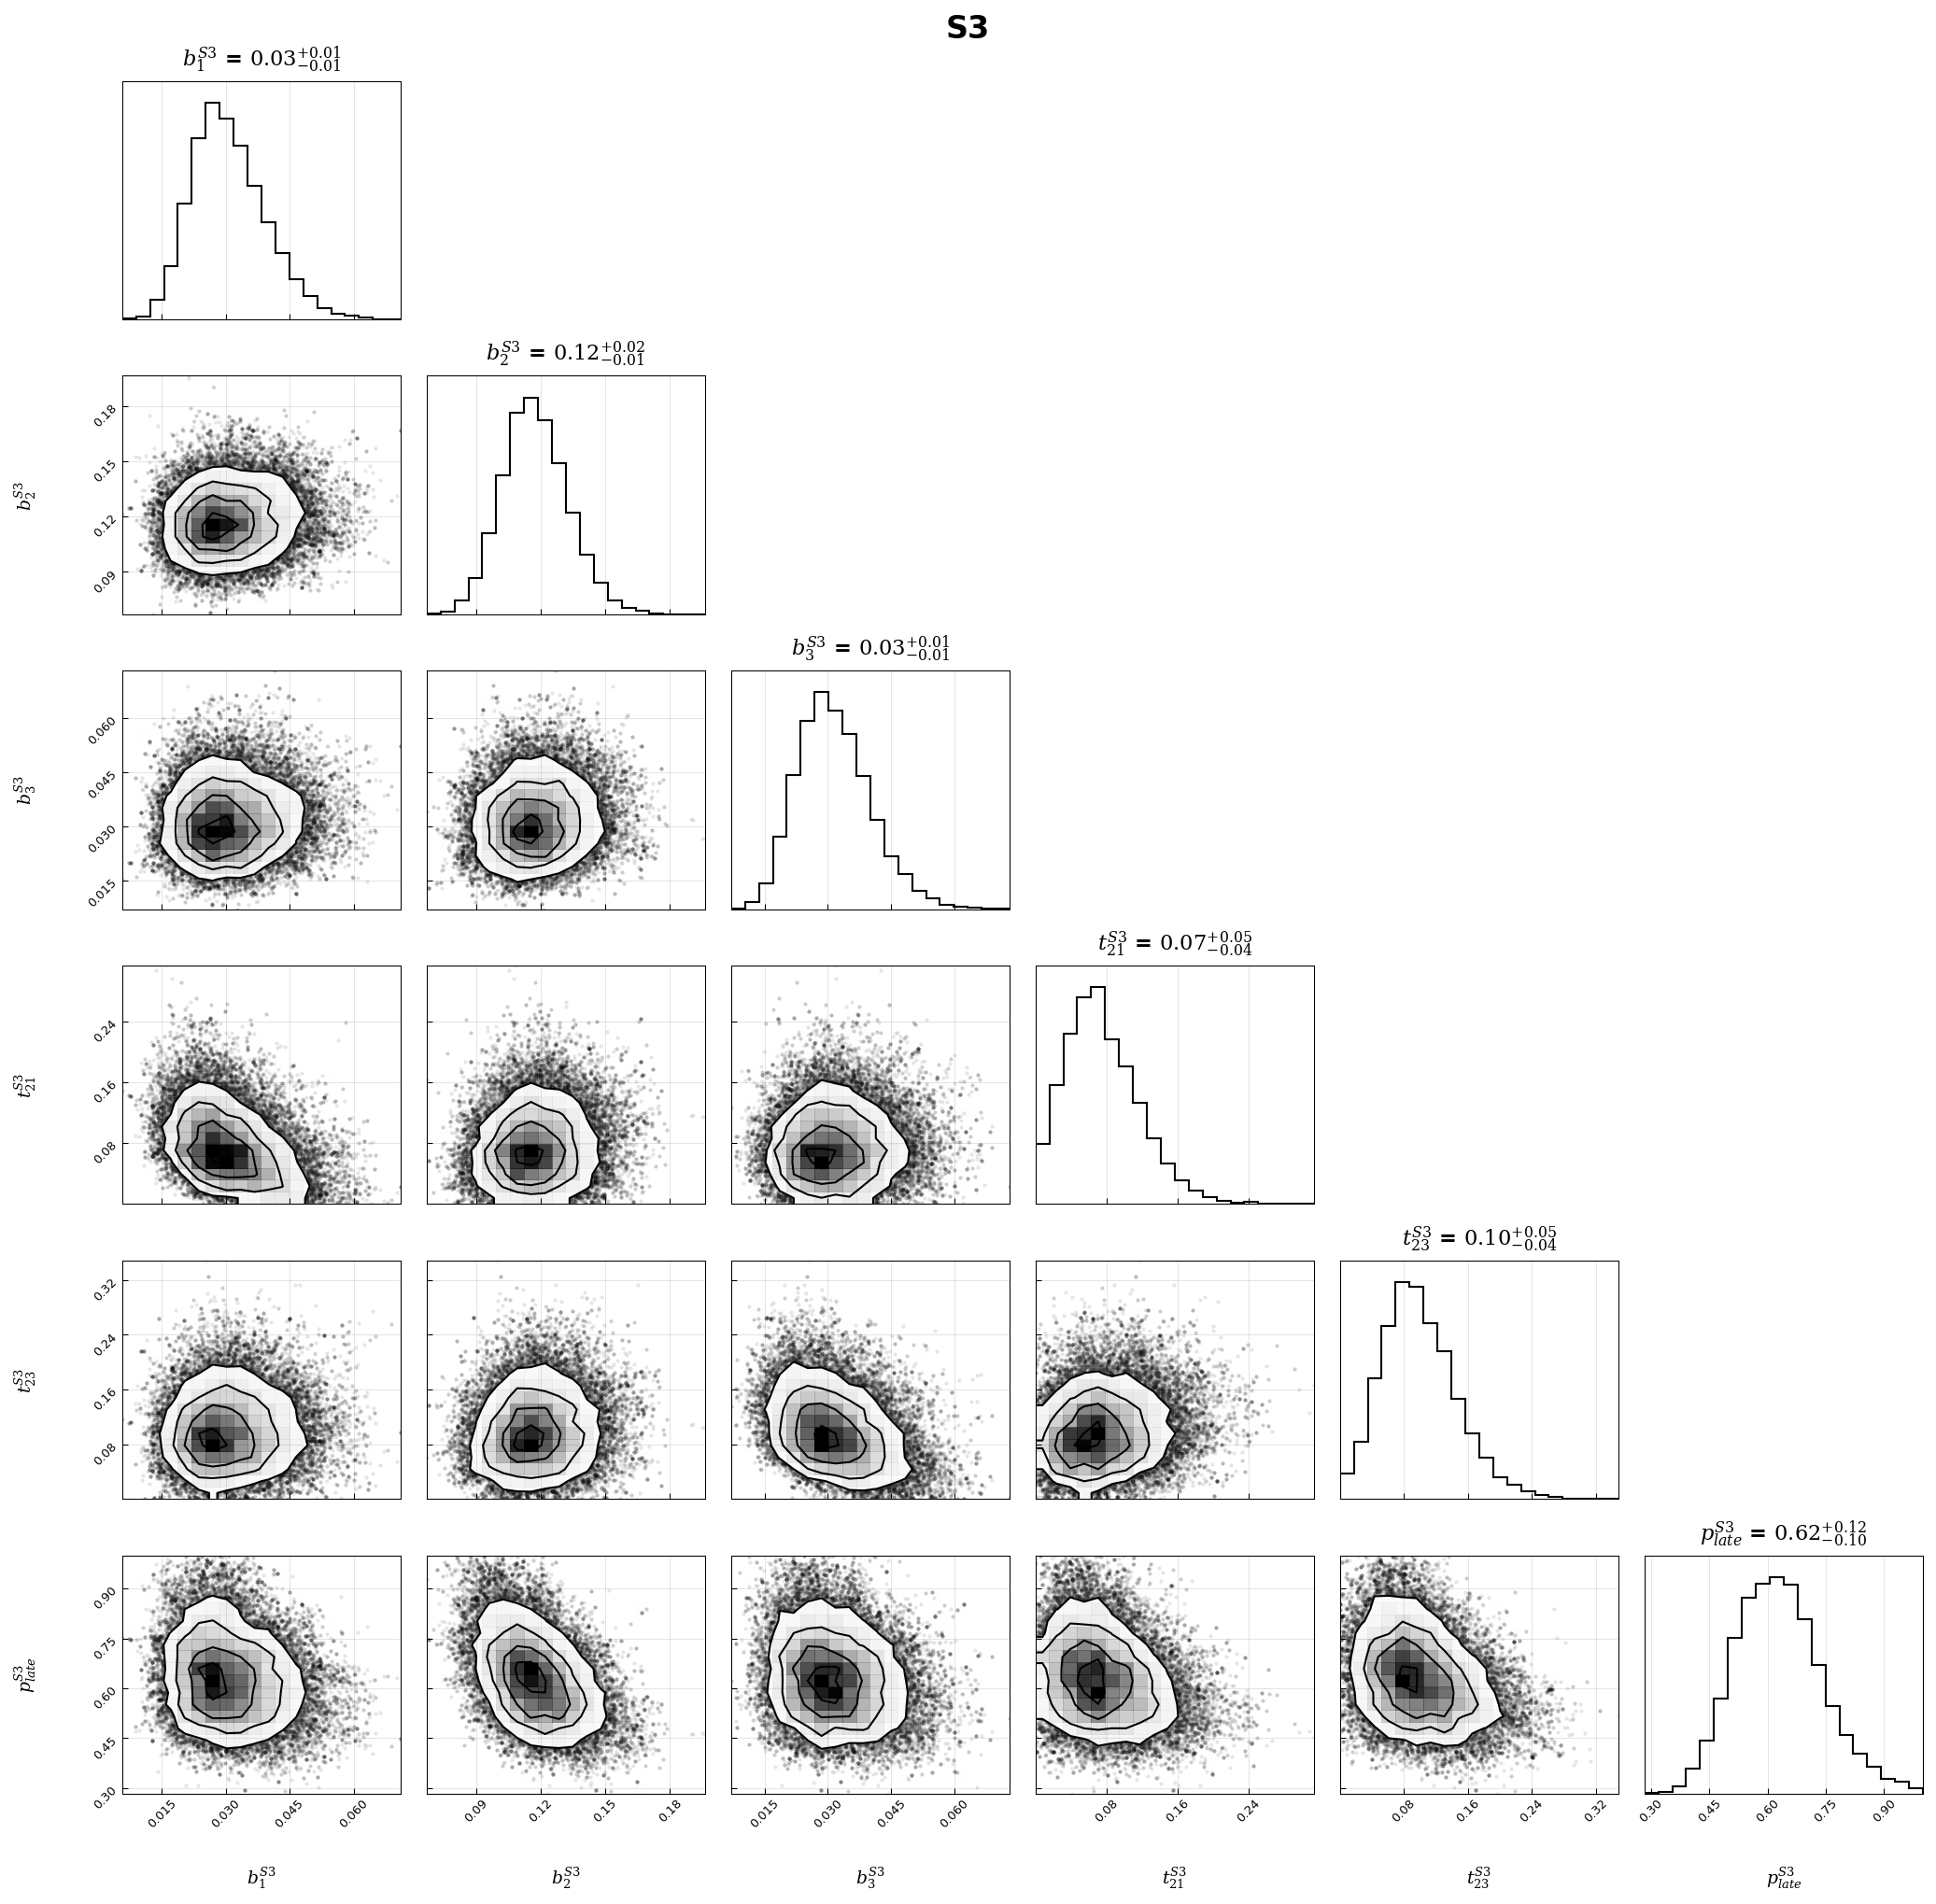

In [20]:

label_names = [r'$b_1^{S3}$', r'$b_2^{S3}$', r'$b_3^{S3}$', r'$t_{21}^{S3}$', r'$t_{23}^{S3}$', r'$p_{late}^{S3}$']
fig = corner.corner(
        samples_s3,
        labels=label_names,
        show_titles=True,
    )
fig.suptitle(f'S3', fontsize=16)
fig.tight_layout()
plt.show()
fig.savefig(PLOT_PATH / f"corner_{sample_name}.png")

### Now we sample all the components with our current implementation of the EM algorithm, and check what comes out

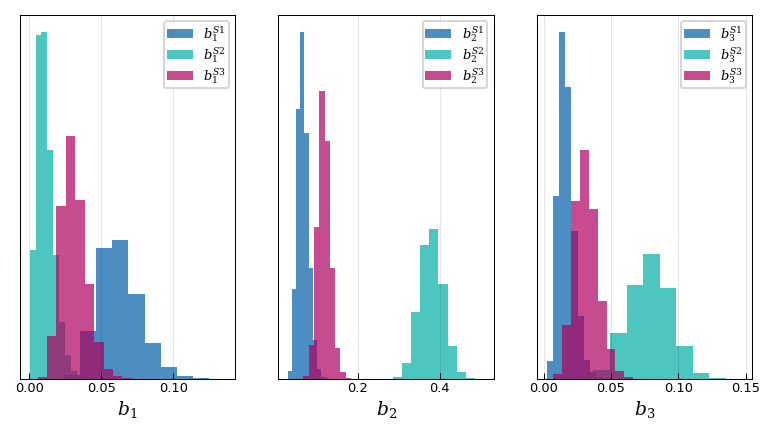

In [67]:
kwargs = {'density': True, 'alpha': 0.7, 'histtype': 'stepfilled'}
fix, ax = plt.subplots(1,3, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,0], label = r'$b_1^{S1}$', color= usz_blue, **kwargs)
ax[0].hist(samples_s2[:,0], label = r'$b_1^{S2}$', color=usz_green, **kwargs)
ax[0].hist(samples_s3[:,0], label = r'$b_1^{S3}$', color=usz_red, **kwargs)
ax[0].set_xlabel(r'$b_1$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,1], label = r'$b_2^{S1}$', color= usz_blue, **kwargs)
ax[1].hist(samples_s2[:,1], label = r'$b_2^{S2}$', color=usz_green, **kwargs)
ax[1].hist(samples_s3[:,1], label = r'$b_2^{S3}$', color=usz_red, **kwargs)
ax[1].set_xlabel(r'$b_2$')
ax[1].set_yticks([])
ax[1].legend()

ax[2].hist(samples_s1[:,2], label = r'$b_3^{S1}$', color= usz_blue, **kwargs)
ax[2].hist(samples_s2[:,2], label = r'$b_3^{S2}$', color=usz_green, **kwargs)
ax[2].hist(samples_s3[:,2], label = r'$b_3^{S3}$', color=usz_red, **kwargs)
ax[2].set_xlabel(r'$b_3$')
ax[2].set_yticks([])
ax[2].legend()
plt.show()


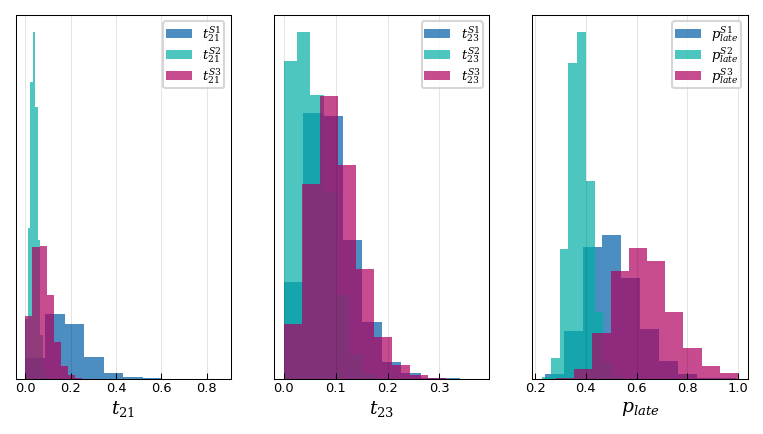

In [68]:
fix, ax = plt.subplots(1,3, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,3], label = r'$t_{21}^{S1}$', color= usz_blue, **kwargs)
ax[0].hist(samples_s2[:,3], label = r'$t_{21}^{S2}$', color=usz_green, **kwargs)
ax[0].hist(samples_s3[:,3], label = r'$t_{21}^{S3}$', color=usz_red, **kwargs)
ax[0].set_xlabel(r'$t_{21}$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,4], label = r'$t_{23}^{S1}$', color= usz_blue, **kwargs)
ax[1].hist(samples_s2[:,4], label = r'$t_{23}^{S2}$', color=usz_green, **kwargs)
ax[1].hist(samples_s3[:,4], label = r'$t_{23}^{S3}$', color=usz_red, **kwargs)
ax[1].set_xlabel(r'$t_{23}$')
ax[1].set_yticks([])
ax[1].legend()

ax[2].hist(samples_s1[:,5], label = r'$p_{late}^{S1}$', color= usz_blue, **kwargs)
ax[2].hist(samples_s2[:,5], label = r'$p_{late}^{S2}$', color=usz_green, **kwargs)
ax[2].hist(samples_s3[:,5], label = r'$p_{late}^{S3}$', color=usz_red, **kwargs)
ax[2].set_xlabel(r'$p_{late}$')
ax[2].set_yticks([])
ax[2].legend()
plt.show()

#### Function Definition

#### EM

In [21]:
n_subsites = 3
n_clusters = 2

n_params = 6
initial_weights = [0.5,0.5,0.5] # wheights of D1, D2, D12 corresponsing to cluster 0

models = create_models(n_subsites, graph_3lnl, include_late=True, n_mixture_components=n_clusters )
for i, (k,v) in enumerate(sdata.items()):
    models[i].load_patient_data(v, side='ipsi')

global MODELS
MODELS = models

In [22]:
params = np.random.random(12)
weights = np.random.random(3)

maximation_llh_2_cluster_fixed_weights(params, weights)


-3654.1695046448876

In [92]:
from scipy.optimize import minimize
# Check if MLE works for parameters
initial_guess = np.random.random(12)
weights = [0.5, 0.5, 0.5]

param_bounds = [(0, 1) for i in range(n_clusters*n_params)]
result = minimize(
    maximation_llh_2_cluster_fixed_weights_inv,
    initial_guess,
    args=(weights),
    bounds=param_bounds,
)


In [93]:
# Extract the MLE parameters
mle_params = result.x

print("MLE Parameters:", mle_params)
print("Log-Likelihood at MLE:", -result.fun)

MLE Parameters: [0.04509201 0.         0.07825903 0.40624133 0.02033867 0.07710564
 0.04344714 0.04581325 0.04945663 0.07887101 1.         0.17485517]
Log-Likelihood at MLE: -1134.2888286524635


In [99]:
params = np.random.random(12)
print(params)
assign_model_params(params, n_clusters)
for m in MODELS:
    print(m.get_params())

[0.51552298 0.02373684 0.49681568 0.89831166 0.60191743 0.19715614
 0.06217684 0.16572074 0.70552276 0.02819471 0.61630801 0.73409751]
dict_values([[0.5155229847510693, 0.023736841164376465], [0.49681568371029894, 0.8983116556519694], [0.6019174329281555, 0.19715613553179911], [0.06217684062139861, 0.1657207402532832], [0.7055227646129901, 0.028194707602859692], [1.0, 0.17485518472226685]])
dict_values([[0.5155229847510693, 0.023736841164376465], [0.49681568371029894, 0.8983116556519694], [0.6019174329281555, 0.19715613553179911], [0.06217684062139861, 0.1657207402532832], [0.7055227646129901, 0.028194707602859692], [1.0, 0.17485518472226685]])
dict_values([[0.5155229847510693, 0.023736841164376465], [0.49681568371029894, 0.8983116556519694], [0.6019174329281555, 0.19715613553179911], [0.06217684062139861, 0.1657207402532832], [0.7055227646129901, 0.028194707602859692], [1.0, 0.17485518472226685]])


In [101]:
import sys

In [7]:
def check_convergence(weights, params, llhs, ths = 0.001):
    w = np.array(weights)
    p = np.array(params)
    l = np.array(llhs)
    dw = np.sqrt(((w[-1] - w[-2])**2).sum()) 
    dp = np.sqrt(((p[-1] - p[-2])**2).sum()) 
    r = (dw + dp)
    dp_max = np.max(np.sqrt((p[-1] - p[-2])**2))
    dw_max = np.max(np.sqrt((w[-1] - w[-2])**2))
    if any(h > ths for h in [r, dp_max, dw_max]):
        return False
    else:
        return True

def check_convergence_deb(weights, params, llhs, ths = 0.001):
    w = np.array(weights)
    p = np.array(params)
    l = np.array(llhs)
    dw = np.sqrt(((w[-1] - w[-2])**2).sum()) 
    dp = np.sqrt(((p[-1] - p[-2])**2).sum()) 
    r = (dw + dp)
    dp_max = np.max(np.sqrt((p[-1] - p[-2])**2))
    dw_max = np.max(np.sqrt((w[-1] - w[-2])**2))
    return np.max([r, dp_max, dw_max])


In [8]:
base_name = "S1S2S3_MLEEM_2123_late"
weights = [0.5, 0.5, 0.5]
model_params = None
save_values = False


def find_optimal_weights(base_name=None, save_weights=None, n_clusters=2, n_params=5):
    global MODELS
    weights = [0.5, 0.5, 0.5]
    model_params = None
    param_bounds = [(0, 1) for i in range(n_clusters * n_params)]
    weight_bounds = [(0, 1) for i in range((n_clusters - 1) * n_subsites)]

    weights_hist = []
    model_params_hist = []
    llh_hist = []
    c_r = []
    steps = [str(i) for i in range(50)]
    for step in steps:
        print(f"Step {step} " + "- " * 20)
        # Expectation
        if model_params is not None:
            print("Expectation step..")
            llhs_e = []
            weights_e = []

            assign_model_params(model_params, n_clusters)
            for i in range(5):
                sys.stdout.write(f"\r Perform MLE [{i} / 5]")
                wbu = []
                initial_guess = np.random.random(1)
                res = minimize(
                    expectation_pi1_0,
                    initial_guess,
                    args=([weights[1], weights[2]]),
                    method="L-BFGS-B",
                )
                wbu.append(res.x[0])
                res = minimize(
                    expectation_pi2_0,
                    initial_guess,
                    args=([weights[1], weights[2]]),
                    method="L-BFGS-B",
                )
                wbu.append(res.x[0])
                res = minimize(
                    expectation_pi12_0,
                    initial_guess,
                    args=([weights[0], weights[1]]),
                    method="L-BFGS-B",
                )
                wbu.append(res.x[0])
                llhs_e.append(maximation_llh_2_cluster_fixed_weights(model_params, wbu))
                weights_e.append(wbu)

            weights = weights_e[np.argmax(llhs_e)]
            print(f"Expectation yields: {weights}")
            if save_weights is not None:
                np.save(f"./samples/em_samples/" + f"E{step}_{base_name}", weights)

            # Maximation
        print("Maximation step..")
        sample_name = f"em_samples/M{step}_{base_name}"
        llhs_m = []
        params_m = []
        for i in range(3):
            sys.stdout.write(f"\r Perform MLE [{i} / 3]")
            initial_guess = np.random.random(n_clusters * n_params)
            result = minimize(
                maximation_llh_2_cluster_fixed_weights_inv,
                initial_guess,
                args=(weights),
                bounds=param_bounds,
            )
            llhs_m.append(-result.fun)
            params_m.append(result.x)
        model_params = params_m[np.argmax(llhs_m)]
        # Maximization Results

        print(f"Maximation yields: {model_params}")
        weights_hist.append(weights)
        model_params_hist.append(model_params)
        llh_hist.append(np.max(llhs_m))

        try:
            c_r.append(check_convergence_deb(weights_hist, model_params_hist, llh_hist))
            print(f"Condition_ {np.round(c_r, 4)}")

            if check_convergence(weights_hist, model_params_hist, llh_hist):
                print(f"Condition fullfilled at step {step}!!")
                break
        except:
            print("Convergence test failed ")
    np.save(f"./samples/" + f"final_{base_name}", weights)
    return weights, [
        weights_hist,
        model_params_hist,
        llh_hist,
        c_r,
    ]

def plot_convergence(hist):
    
    weights_hist = hist[0]
    model_params_hist = hist[1]
    llh_hist = hist[2]
    c_r = hist[3]
    
    fig, axs = plt.subplots(2,2, figsize = set_size(width='full'))
    # Inspect llh
    axs[0][0].plot(range(len(llh_hist)), llh_hist, label = 'Likelihood')
    axs[0][0].set_xlabel('Steps')
    axs[0][0].set_ylabel('log lh')
    ax = axs[0][1]
    ax.plot(range(len(weights_hist)), [w[0] for w in weights_hist], label = r'$\pi_{S1,0}$')
    ax.plot(range(len(weights_hist)), [w[1] for w in weights_hist], label = r'$\pi_{S2,0}$')
    ax.plot(range(len(weights_hist)), [w[2] for w in weights_hist], label = r'$\pi_{S3,0}$')
    ax.set_xlabel('Steps')
    ax.set_ylabel('weights')
    ax.legend()

    # Inspect llh
    ax = axs[1,0]
    label_names_1 = [r'$b_1^{1}$', r'$b_2^{1}$', r'$b_3^{1}$', r'$t_{21}^{1}$', r'$t_{23}^{1}$', r'$p_{late}^{1}$']
    label_names_2 = [r'$b_1^{2}$', r'$b_2^{2}$', r'$b_3^{2}$', r'$t_{21}^{2}$', r'$t_{23}^{2}$', r'$p_{late}^{2}$']

    ax.plot(range(len(model_params_hist)), [w[0] for w in model_params_hist], label = r'$b_1^{1}$')
    ax.plot(range(len(model_params_hist)), [w[1] for w in model_params_hist], label = r'$b_1^{2}$')
    ax.plot(range(len(model_params_hist)), [w[2] for w in model_params_hist], label = r'$b_2^{1}$')
    ax.plot(range(len(model_params_hist)), [w[3] for w in model_params_hist], label = r'$b_2^{2}$')
    ax.plot(range(len(model_params_hist)), [w[4] for w in model_params_hist], label = r'$b_3^{1}$')
    ax.plot(range(len(model_params_hist)), [w[5] for w in model_params_hist], label = r'$b_3^{2}$')

    ax.set_xlabel('Steps')
    ax.set_ylabel('model params')
    ax.legend()
  
        # Inspect llh
    ax = axs[1][1]
    label_names_1 = [r'$b_1^{1}$', r'$b_2^{1}$', r'$b_3^{1}$', r'$t_{21}^{1}$', r'$t_{23}^{1}$']
    label_names_2 = [r'$b_1^{2}$', r'$b_2^{2}$', r'$b_3^{2}$', r'$t_{21}^{2}$', r'$t_{23}^{2}$']
    ax.plot(range(len(model_params_hist)), [w[6] for w in model_params_hist], label = r'$t_{21}^{1}$')
    ax.plot(range(len(model_params_hist)), [w[7] for w in model_params_hist], label = r'$t_{21}^{2}$')
    ax.plot(range(len(model_params_hist)), [w[8] for w in model_params_hist], label = r'$t_{23}^{1}$')
    ax.plot(range(len(model_params_hist)), [w[9] for w in model_params_hist], label = r'$t_{23}^{2}$')
    ax.set_xlabel('Steps')
    ax.set_ylabel('model params')
    ax.legend()
    plt.show()
    


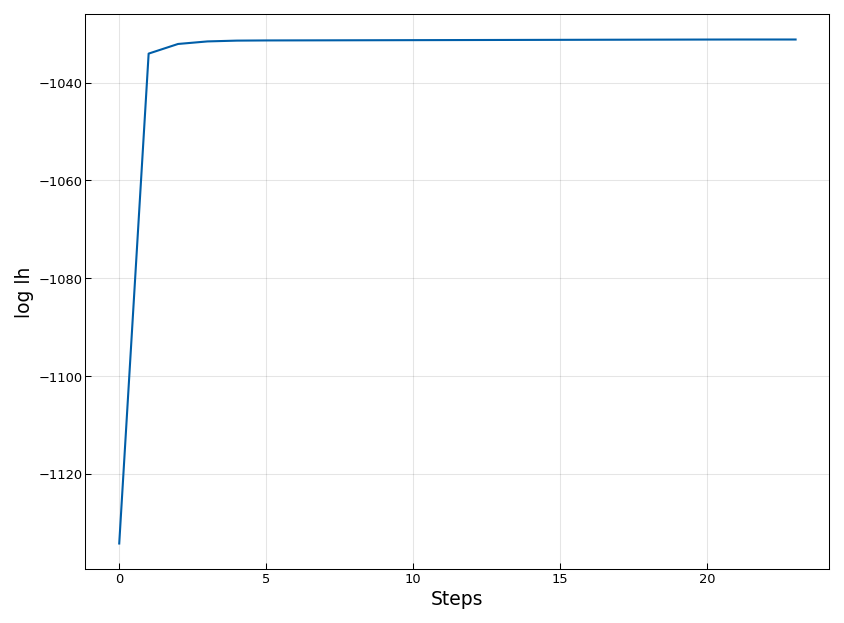

In [171]:
# Inspect llh
plt.plot(range(len(llh_hist)), llh_hist, label = 'Likelihood')
plt.xlabel('Steps')
plt.ylabel('log lh')
plt.savefig(PLOT_PATH / "hist_llh.svg")
plt.show()

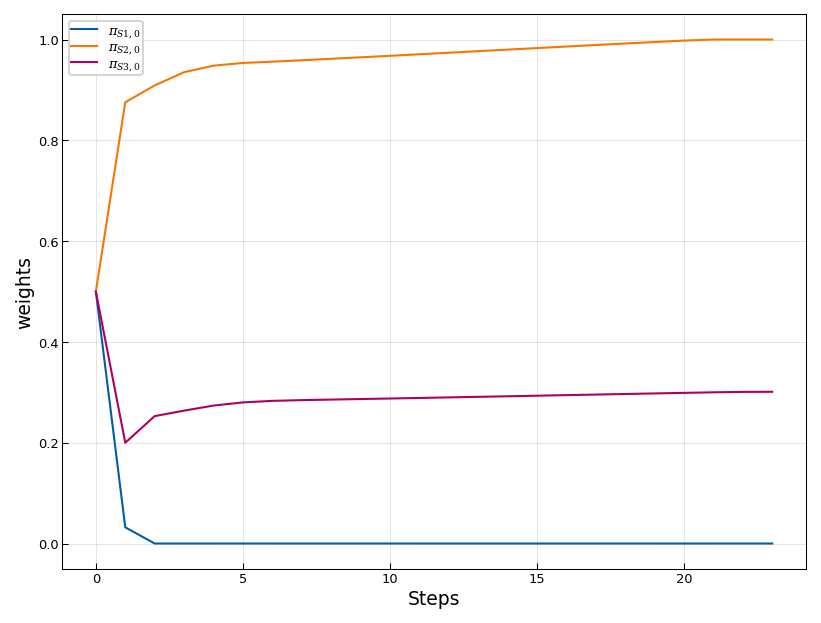

In [172]:
# Inspect llh
fig,ax = plt.subplots(1)
ax.plot(range(len(weights_hist)), [w[0] for w in weights_hist], label = r'$\pi_{S1,0}$')
ax.plot(range(len(weights_hist)), [w[1] for w in weights_hist], label = r'$\pi_{S2,0}$')
ax.plot(range(len(weights_hist)), [w[2] for w in weights_hist], label = r'$\pi_{S3,0}$')
plt.xlabel('Steps')
plt.ylabel('weights')
plt.legend()
plt.savefig(PLOT_PATH / "S_data_hist_weights.svg")
plt.show()

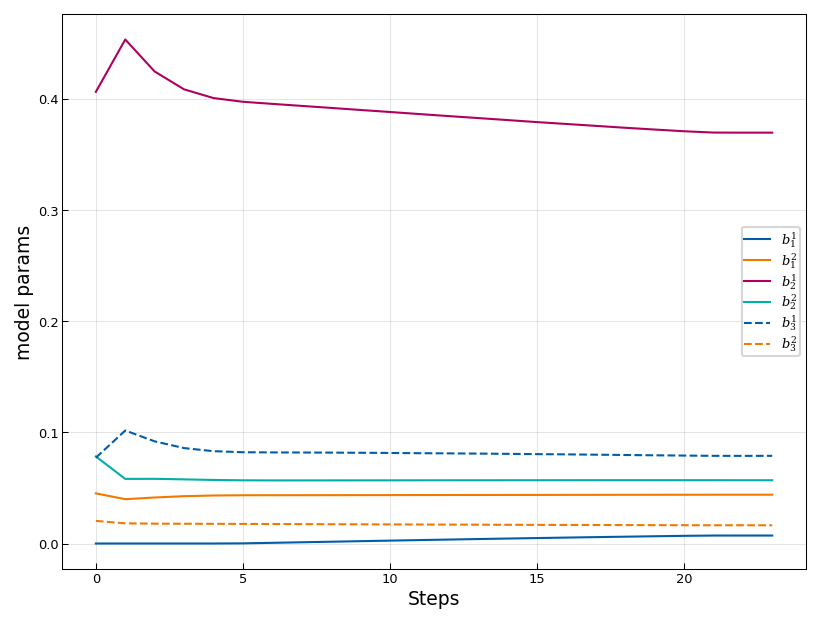

In [173]:
# Inspect llh
fig,ax = plt.subplots(1)
label_names_1 = [r'$b_1^{1}$', r'$b_2^{1}$', r'$b_3^{1}$', r'$t_{21}^{1}$', r'$t_{23}^{1}$', r'$p_{late}^{1}$']
label_names_2 = [r'$b_1^{2}$', r'$b_2^{2}$', r'$b_3^{2}$', r'$t_{21}^{2}$', r'$t_{23}^{2}$', r'$p_{late}^{2}$']

ax.plot(range(len(model_params_hist)), [w[0] for w in model_params_hist], label = r'$b_1^{1}$')
ax.plot(range(len(model_params_hist)), [w[1] for w in model_params_hist], label = r'$b_1^{2}$')
ax.plot(range(len(model_params_hist)), [w[2] for w in model_params_hist], label = r'$b_2^{1}$')
ax.plot(range(len(model_params_hist)), [w[3] for w in model_params_hist], label = r'$b_2^{2}$')
ax.plot(range(len(model_params_hist)), [w[4] for w in model_params_hist], label = r'$b_3^{1}$')
ax.plot(range(len(model_params_hist)), [w[5] for w in model_params_hist], label = r'$b_3^{2}$')

plt.xlabel('Steps')
plt.ylabel('model params')
plt.legend()
plt.savefig(PLOT_PATH / "S_data_hist_modelparams.svg")
plt.show()

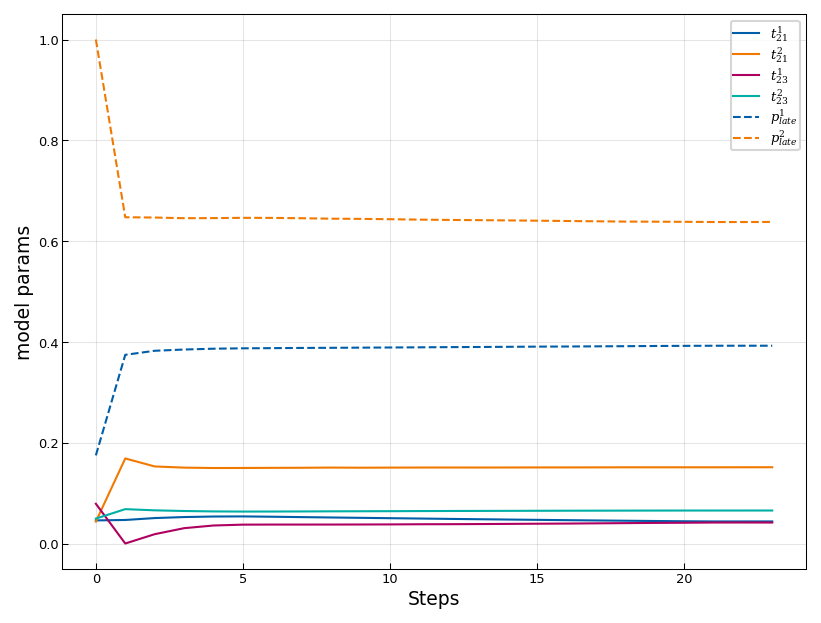

In [174]:
# Inspect llh
fig,ax = plt.subplots(1)
label_names_1 = [r'$b_1^{1}$', r'$b_2^{1}$', r'$b_3^{1}$', r'$t_{21}^{1}$', r'$t_{23}^{1}$', r'$p_{late}^{1}$']
label_names_2 = [r'$b_1^{2}$', r'$b_2^{2}$', r'$b_3^{2}$', r'$t_{21}^{2}$', r'$t_{23}^{2}$', r'$p_{late}^{2}$']

ax.plot(range(len(model_params_hist)), [w[6] for w in model_params_hist], label = r'$t_{21}^{1}$')
ax.plot(range(len(model_params_hist)), [w[7] for w in model_params_hist], label = r'$t_{21}^{2}$')
ax.plot(range(len(model_params_hist)), [w[8] for w in model_params_hist], label = r'$t_{23}^{1}$')
ax.plot(range(len(model_params_hist)), [w[9] for w in model_params_hist], label = r'$t_{23}^{2}$')
ax.plot(range(len(model_params_hist)), [w[10] for w in model_params_hist], label = r'$p_{late}^{1}$')
ax.plot(range(len(model_params_hist)), [w[11] for w in model_params_hist], label =  r'$p_{late}^{2}$')

plt.xlabel('Steps')
plt.ylabel('model params')
plt.legend()
plt.savefig(PLOT_PATH / "S_data_hist_modelparams.svg")
plt.show()

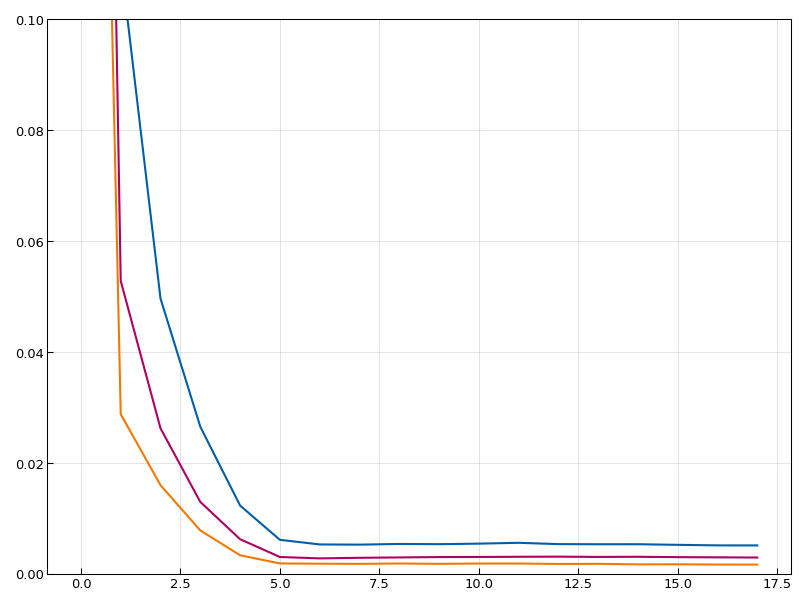

In [145]:
rs = []
for i in range(2, len(llh_hist)):
    rs.append(check_convergence(weights_hist[:i], model_params_hist[:i], llh_hist[:1]))
plt.plot(range(len(rs)), [r[0] for r in rs], label='sum')
plt.plot(range(len(rs)), [r[1] for r in rs], label='dp_max')
plt.plot(range(len(rs)), [r[2] for r in rs], label='dw_max')
plt.ylim(0,0.1)
plt.show()

In [ ]:
# Do posterior sampling with the weights

In [23]:
final_weights = np.load("samples/em_samples/E23_S1S2S3_MLEEM_2123_late.npy")
print(final_weights)

[8.61289365e-08 9.99996699e-01 3.01050071e-01]


In [24]:
n_subsite = 3
n_clusters = 2
MODELS = create_models(3, graph_3lnl, n_mixture_components=2)

MODELS[0].load_patient_data(sdata['S1'])
MODELS[1].load_patient_data(sdata['S2'])
MODELS[2].load_patient_data(sdata['S3'])

n_params = len(MODELS[0].get_params()) * n_clusters

weights = final_weights

In [25]:
# Sampling
sample_name = f"cl0_cl1_s1s2s3_2123_late"
sampling = False
if sampling:
    samples_cl0_cl1_rd,_,_= emcee_sampling_ext(maximation_llh_2_cluster_fixed_weights, n_params, sample_name, 1500, 1000, llh_args=([weights]))
else:
    samples_cl0_cl1_rd = np.load("samples/"+sample_name+".npy")



In [26]:
params_cl1 = samples_cl0_cl1_rd[:, ::2]
params_cl2 = samples_cl0_cl1_rd[:, 1::2]

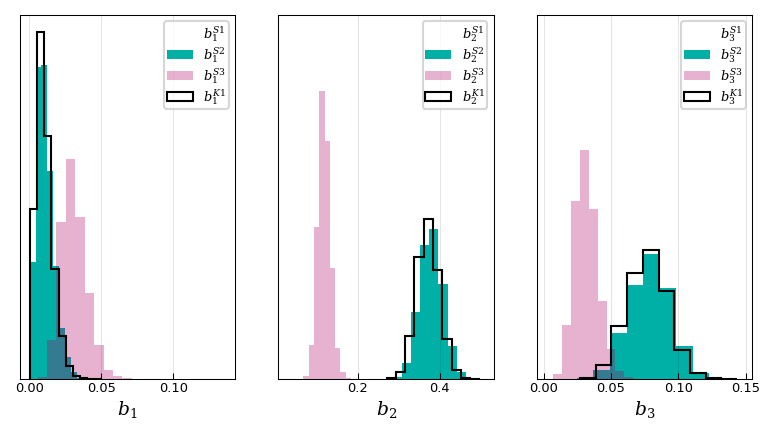

In [53]:
weights = final_weights
kwargs = {'density': True, 'histtype': 'stepfilled'}
fix, ax = plt.subplots(1,3, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,0], label = r'$b_1^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[0].hist(samples_s2[:,0], label = r'$b_1^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[0].hist(samples_s3[:,0], label = r'$b_1^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[0].hist(params_cl1[:,0], label = r'$b_1^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[0].set_xlabel(r'$b_1$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,1], label = r'$b_2^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[1].hist(samples_s2[:,1], label = r'$b_2^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[1].hist(samples_s3[:,1], label = r'$b_2^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[1].hist(params_cl1[:,1], label = r'$b_2^{K1}$', color='black', alpha = 1,density = True, histtype = "step")
ax[1].set_xlabel(r'$b_2$')
ax[1].set_yticks([])
ax[1].legend()

ax[2].hist(samples_s1[:,2], label = r'$b_3^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[2].hist(samples_s2[:,2], label = r'$b_3^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[2].hist(samples_s3[:,2], label = r'$b_3^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[2].hist(params_cl1[:,2], label = r'$b_3^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[2].set_xlabel(r'$b_3$')
ax[2].set_yticks([])
ax[2].legend()
plt.show()


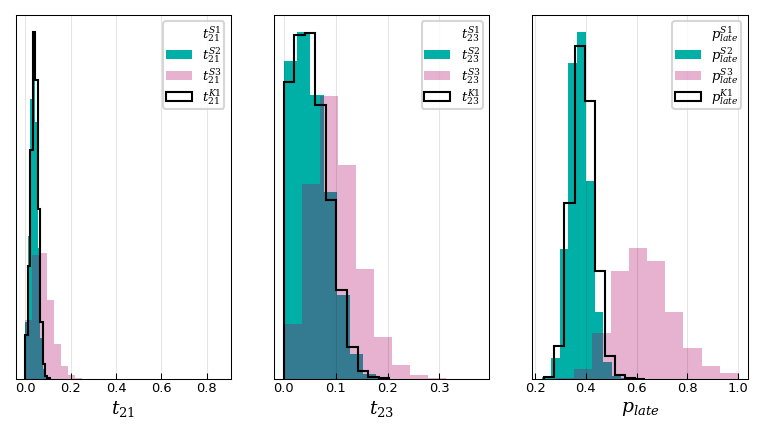

In [55]:
fix, ax = plt.subplots(1,3, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,3], label = r'$t_{21}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[0].hist(samples_s2[:,3], label = r'$t_{21}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[0].hist(samples_s3[:,3], label = r'$t_{21}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[0].hist(params_cl1[:,3], label = r'$t_{21}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[0].set_xlabel(r'$t_{21}$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,4], label = r'$t_{23}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[1].hist(samples_s2[:,4], label = r'$t_{23}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[1].hist(samples_s3[:,4], label = r'$t_{23}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[1].hist(params_cl1[:,4], label = r'$t_{23}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[1].set_xlabel(r'$t_{23}$')
ax[1].set_yticks([])
ax[1].legend()

ax[2].hist(samples_s1[:,5], label = r'$p_{late}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[2].hist(samples_s2[:,5], label = r'$p_{late}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[2].hist(samples_s3[:,5], label = r'$p_{late}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[2].hist(params_cl1[:,5], label = r'$p_{late}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[2].set_xlabel(r'$p_{late}$')
ax[2].set_yticks([])
ax[2].legend()
plt.show()

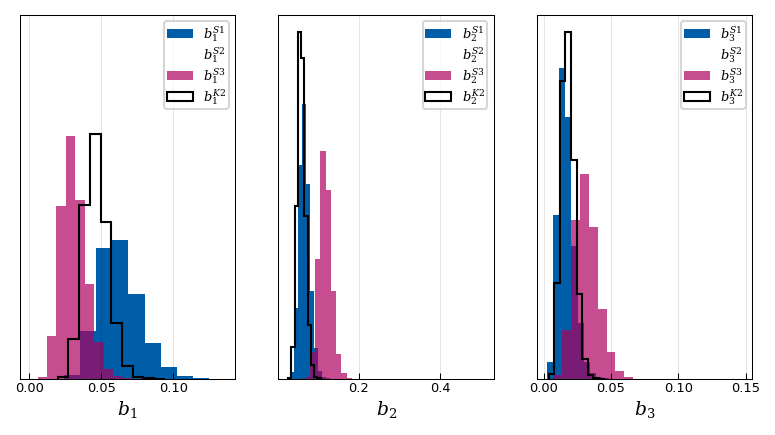

In [57]:
weights = 1-final_weights
kwargs = {'density': True, 'histtype': 'stepfilled'}
fix, ax = plt.subplots(1,3, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,0], label = r'$b_1^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[0].hist(samples_s2[:,0], label = r'$b_1^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[0].hist(samples_s3[:,0], label = r'$b_1^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[0].hist(params_cl2[:,0], label = r'$b_1^{K2}$', color='black', alpha = 1, density = True, histtype = "step")
ax[0].set_xlabel(r'$b_1$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,1], label = r'$b_2^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[1].hist(samples_s2[:,1], label = r'$b_2^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[1].hist(samples_s3[:,1], label = r'$b_2^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[1].hist(params_cl2[:,1], label = r'$b_2^{K2}$', color='black', alpha = 1,density = True, histtype = "step")
ax[1].set_xlabel(r'$b_2$')
ax[1].set_yticks([])
ax[1].legend()

ax[2].hist(samples_s1[:,2], label = r'$b_3^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[2].hist(samples_s2[:,2], label = r'$b_3^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[2].hist(samples_s3[:,2], label = r'$b_3^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[2].hist(params_cl2[:,2], label = r'$b_3^{K2}$', color='black', alpha = 1, density = True, histtype = "step")
ax[2].set_xlabel(r'$b_3$')
ax[2].set_yticks([])
ax[2].legend()
plt.show()


NameError: name 'kwargs' is not defined

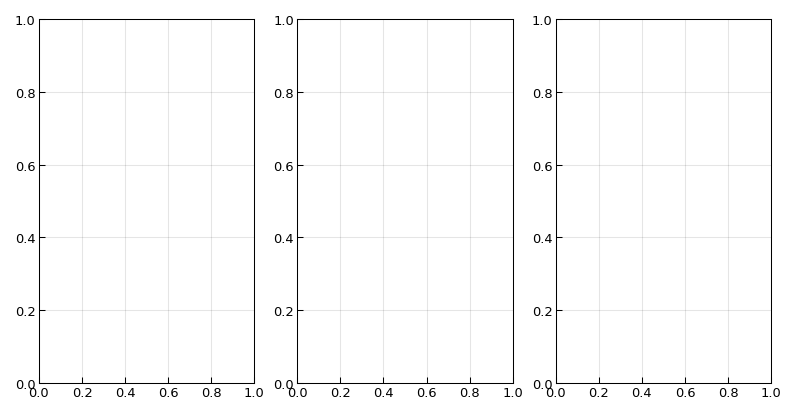

In [46]:
fix, ax = plt.subplots(1,3, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,3], label = r'$t_{21}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[0].hist(samples_s2[:,3], label = r'$t_{21}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[0].hist(samples_s3[:,3], label = r'$t_{21}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[0].hist(params_cl1[:,3], label = r'$t_{21}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[0].set_xlabel(r'$t_{21}$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,4], label = r'$t_{23}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[1].hist(samples_s2[:,4], label = r'$t_{23}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[1].hist(samples_s3[:,4], label = r'$t_{23}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[1].hist(params_cl1[:,4], label = r'$t_{23}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[1].set_xlabel(r'$t_{23}$')
ax[1].set_yticks([])
ax[1].legend()

ax[2].hist(samples_s1[:,5], label = r'$p_{late}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[2].hist(samples_s2[:,5], label = r'$p_{late}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[2].hist(samples_s3[:,5], label = r'$p_{late}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[2].hist(params_cl1[:,5], label = r'$p_{late}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[2].set_xlabel(r'$p_{late}$')
ax[2].set_yticks([])
ax[2].legend()
plt.show()

## Create the S123 model samples

In [27]:
sdata_joined = pd.concat([d for d in sdata.values()])
n_subsite = 1
n_clusters = 1
model_s123 = create_models(1, graph_3lnl, n_mixture_components=1)

model_s123.load_patient_data(sdata_joined)

n_params = len(model_s123.get_params()) * n_clusters


In [20]:
# Sampling
global MODEL

sample_name = f"S123_2123_late"
samples_s123 = np.load("samples/"+sample_name+".npy")

sample_name = f"S2_2123_late"
samples_s2 = np.load("samples/"+sample_name+".npy")

sample_name = f"S3_2123_late"
samples_s3 = np.load("samples/"+sample_name+".npy")

# Sampling
sample_name = f"cl0_cl1_s1s2s3_2123_late"
samples_cl0_cl1_rd = np.load("samples/"+sample_name+".npy")

samples_cl1 = samples_cl0_cl1_rd[:, ::2]
samples_cl2 = samples_cl0_cl1_rd[:, 1::2]

sample_name = f"S1_2123_late"
samples_s1 = np.load("samples/"+sample_name+".npy")

final_weights = np.load("samples/em_samples/E23_S1S2S3_MLEEM_2123_late.npy")
print(final_weights)

[8.61289365e-08 9.99996699e-01 3.01050071e-01]


## Create the prevalence tables for S1, S2, S3, Cl12, S123

In [ ]:
# Sampling
global MODEL
MODEL = model_s1


In [19]:
samples_list = [samples_s1, samples_s2, samples_s3, samples_cl1, samples_cl2, samples_s123]
samples_label = ['S1', 'S2', 'S3', 'Cl1', 'Cl2', 'S123']

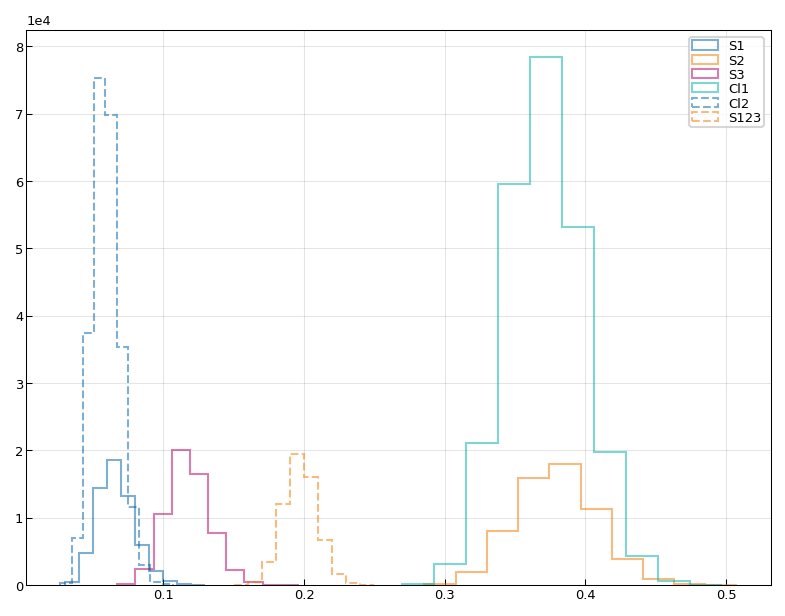

In [20]:
fig, ax = plt.subplots(1)
for i, ss in enumerate(samples_list):
    ax.hist(ss[:,1], label = samples_label[i], alpha=0.5, histtype='step')
ax.legend()
plt.show()

In [79]:
import random
def create_obs_pred_df_single(samples, model, data, patterns, lnls, save_name=None, n_samples=100):
    
    random_idx = random.sample(range(samples.shape[0]), n_samples)
    samples_to_use = [samples[i,:] for i in random_idx]
    obs_prev = {}
    pred_prev = {}
    pred_prev_std = {}
    pred_prev_list = {}
    df_dict = {}
    t_stages = list(model.diag_time_dists)
    for t_stage in t_stages:
        obs_prev_t = {}
        pred_prev_t = {}
        pred_prev_std_t = {}
        pred_prev_list_t = {}
        df_dict_t = {}

        for pattern in patterns:
            pname = pattern
            op = compute_observed_prevalence(
                pattern={"ipsi": pattern},
                data=data,
                t_stage=t_stage,
                lnls=lnls,
            )
            # print(f"{loc}: Observed P({lnl}) = {round(op[0]/op[1], 2)} ({op})")
            pp_list = list(generate_predicted_prevalences(
                pattern={"ipsi": pattern},
                model=model,
                samples=samples_to_use,
                t_stage=t_stage,
            ))
            # predicted_prevalence overwrites the patient data, therefore we have to load it again.
            obs_prev_t[str(pname)] = op[0] / op[1] if op[1] != 0 else 0
            pred_prev_t[str(pname)] = np.mean(pp_list)
            pred_prev_std_t[str(pname)] = np.std(pp_list)
            pred_prev_list_t[str(pname)] = (pp_list, op)
            df_dict_t[str(pname)] = {
                "obs": op[0] / op[1] if op[1] != 0 else 0,
                "pred": np.mean(pp_list),
                "pred_tot":np.mean(pp_list) * op[1],
                "diff": (op[0] / op[1] if op[1] != 0 else 0) - np.mean(pp_list),
                "n/t": op,
                "n": op[0],
                "t":op[1]
            }

            # print(f"{loc}: Predicted P({lnl}) = {round(pp_list.mean(), 2)}")
        obs_prev[t_stage] = obs_prev_t
        pred_prev[t_stage] = pred_prev_t
        pred_prev_std[t_stage] = pred_prev_std_t
        pred_prev_list[t_stage] = pred_prev_list_t
        df_dict[t_stage] = df_dict_t

    df_obs_pred = pd.DataFrame((df_dict), columns=[["oral cavity"]])
    df = pd.DataFrame.from_dict(
        {
            (stage, state): df_dict[stage][state]
            for stage in df_dict.keys()
            for state in df_dict[stage].keys()
        },
        orient="columns",
    )
    df = df.stack().unstack(level=0)
    if len(t_stages) == 2:
        df['tot', "obs"] = (df["early", "n"] + df["late", "n"]) / (df["early", "t"]+df["late", "t"])
        df['tot', "pred"] = (df["early", "pred"]*df["early", "t"] + df["late", "pred"]*df["late", "t"]) / (df["early", "t"]+df["late", "t"])
        # df['tot', "n/t"] = (df["early", "n"] + df["late", "n"], df["early", "t"]+df["late", "t"])
    
    if save_name is not None:
        df.to_csv(save_name)
    return df, [obs_prev, pred_prev, pred_prev_std, pred_prev_list]


In [70]:
# create the patterns dataframe
states_all_raw = [
        list(combination) for combination in itertools.product([0, 1], repeat=len(lnls))
    ]
states_all = [
        {lnls[-(i + 1)]: p[i] for i in range(len(lnls))} for p in states_all_raw
    ]

In [73]:
final_weights = [8.61289365e-08, 9.99996699e-01, 3.01050071e-01]
samples_list = [samples_s1, samples_s2, samples_s3, [samples_cl0_cl1_rd, [final_weights[0], 1-final_weights[0]]], [samples_cl0_cl1_rd, [final_weights[1], 1-final_weights[1]]], [samples_cl0_cl1_rd, [final_weights[2], 1-final_weights[2]]], samples_s123]
samples_label = ['S1', 'S2', 'S3', 'S1_MM', 'S2_MM', 'S3_MM', 'S123']
sdata_joined = pd.concat([d for d in sdata.values()])
data_list = [sdata['S1'], sdata['S2'], sdata['S3'], sdata['S1'], sdata['S2'], sdata['S3'],sdata_joined ]

In [74]:
for i, ss in enumerate(samples_list):
    if isinstance(ss, list):
        model = create_models(1, graph_3lnl, n_mixture_components=2)
        model.mixture_components = ss[1]
    else:
        model = create_models(1, graph_3lnl, n_mixture_components=1)
    s_label =samples_label[i]
    print(s_label)
    d = data_list[i]
    S1_df, S1_list = create_obs_pred_df_single(ss, model, d, states_all, lnls, f"prevalences/{s_label}_prev_df.csv")
    

S1


S2
S3
S1_MM
S2_MM
S3_MM
S123


In [143]:
## Sampling with p_late fixed, or ignored t_stage

In [20]:
ignore_t_stage = True
d = sdata_ignore_t
graph_3lnl = {
            ("tumor", "primary"): ["I", "II", "III"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): [],
        }

models_rd = create_models(4, graph_3lnl, ignore_t_stage=ignore_t_stage)
model_s1 = models_rd[0]
model_s1.load_patient_data(d['S1'])
model_s2 = models_rd[1]
model_s2.load_patient_data(d['S2'])
model_s3 = models_rd[2]
model_s3.load_patient_data(d['S3'])

sdata_joined = pd.concat([d for d in d.values()])
model_s123 = models_rd[3]
model_s123.load_patient_data(sdata_joined)

n_params = len(model_s1.get_params())
print(model_s1.get_params())



dict_values([0.0, 0.0, 0.0, 0.0, 0.0])


In [24]:
# Sampling
global MODEL
sampling = False

sample_name = f"S1_2123"
MODEL = model_s1
if sampling: 
    samples_s1, end_point, llh = emcee_sampling_ext(log_prob_fn, n_params, sample_name, n_burnin = 750, n_step = 500, llh_args = [])
else:
    samples_s1 = np.load("samples/"+sample_name+".npy")

sample_name = f"S2_2123"
MODEL = model_s2
if sampling:
    samples_s2, end_point, llh = emcee_sampling_ext(log_prob_fn, n_params, sample_name, n_burnin = 750, n_step = 500, llh_args = [])
else:
    samples_s2 = np.load("samples/"+sample_name+".npy")


sample_name = f"S3_2123"
MODEL = model_s3
if sampling:
    samples_s3, end_point, llh = emcee_sampling_ext(log_prob_fn, n_params, sample_name, n_burnin = 750, n_step = 500, llh_args = [])
else:
    samples_s3 = np.load("samples/"+sample_name+".npy")

# # Sampling
# sample_name = f"cl0_cl1_s1s2s3_2123"
# samples_cl0_cl1_rd = np.load("samples/"+sample_name+".npy")

# samples_cl1 = samples_cl0_cl1_rd[:, ::2]
# samples_cl2 = samples_cl0_cl1_rd[:, 1::2]

sample_name = f"S123_2123"
MODEL = model_s123
if sampling:
    samples_s123, end_point, llh = emcee_sampling_ext(log_prob_fn, n_params, sample_name, n_burnin = 750, n_step = 500, llh_args = [])
else:
    samples_s123 = np.load("samples/"+sample_name+".npy")

final_weights = np.load("samples/em_samples/E23_S1S2S3_MLEEM_2123_late.npy")
print(final_weights)

[8.61289365e-08 9.99996699e-01 3.01050071e-01]


In [87]:
n_subsites = 3
n_clusters = 2

n_params = 6
initial_weights = [0.5,0.5,0.5] # wheights of D1, D2, D12 corresponsing to cluster 0

models_MM = create_models(n_subsites, graph_3lnl, ignore_t_stage=True, n_mixture_components=n_clusters )

sample_name = f"CL1_2123"

models_MM[0].load_patient_data(sdata['S1'])
models_MM[1].load_patient_data(sdata['S2'])
models_MM[2].load_patient_data(sdata['S3'])

n_params_mm = len(MODELS[0].get_params()) * n_clusters

global MODELS
MODELS = models_MM

import sys
from scipy.optimize import minimize

In [78]:
weights, hist = find_optimal_weights('weights_CL12_2123', n_params=n_params, n_clusters=n_clusters )

Step 0 - - - - - - - - - - - - - - - - - - - - 
Maximation step..
 Perform MLE [2 / 3]Maximation yields: [9.07542934e-02 6.88121650e-06 1.87004203e-01 2.58072987e-01
 3.67988293e-02 4.74400839e-02 7.20184118e-02 1.09238377e-02
 2.16606446e-01 5.99260612e-02 8.15159202e-01 3.18232473e-01]
Convergence test failed 
Step 1 - - - - - - - - - - - - - - - - - - - - 
Expectation step..
 Perform MLE [4 / 5]Expectation yields: [0.9999331642129021, 0.16704981839867386, 0.6732773580084825]
Maximation step..
 Perform MLE [2 / 3]Maximation yields: [0.05522666 0.         0.07994317 0.48718481 0.02625906 0.10556998
 0.32827483 0.046471   0.14290755 0.         0.19909793 0.2928211 ]
Condition_ [1.3496]
Step 2 - - - - - - - - - - - - - - - - - - - - 
Expectation step..
 Perform MLE [4 / 5]Expectation yields: [0.9893617118688682, 0.08886514661054376, 0.7529619936930875]
Maximation step..
 Perform MLE [2 / 3]Maximation yields: [0.05815936 0.         0.08219014 0.45090922 0.02583001 0.09756676
 0.29041492 

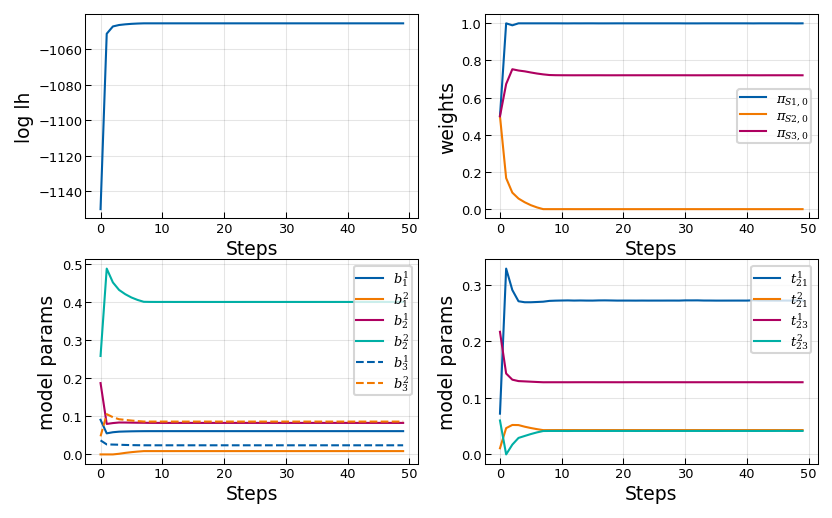

In [85]:
plot_convergence(hist)

In [36]:
log_prob_n_models(np.random.random(6))

-2085.6498201366467

In [63]:
# Sampling
global MODELS
n_subsites = 3
n_clusters = 2
d = sdata_ignore_t

n_params = 6
final_weights = [0.9999983448281871, 2.3570171044287586e-06, 0.7203758077958747]

models_MM = create_models(n_subsites, graph_3lnl, ignore_t_stage=True, n_mixture_components=n_clusters )

sample_name = f"CL1_2123"

models_MM[0].load_patient_data(d['S1'])
models_MM[0].mixture_components=[final_weights[0], 1- final_weights[0]]
models_MM[1].load_patient_data(d['S2'])
models_MM[1].mixture_components=[final_weights[1], 1- final_weights[1]]
models_MM[2].load_patient_data(d['S3'])
models_MM[2].mixture_components=[final_weights[2], 1- final_weights[2]]

n_params_mm = len(models_MM[0].get_params()) * n_clusters


MODELS = models_MM


In [39]:

import sys
from scipy.optimize import minimize

sample_name = f"cl0_cl1_2123"
sampling = True
if sampling:
    samples_cl0_cl1_rd,_,_= emcee_sampling_ext(log_prob_n_models, n_params_mm, sample_name, 1000, 1000, llh_args=([]))
else:
    samples_cl0_cl1_rd = np.load("samples/"+sample_name+".npy")

Dimension: 10 with n walkers: 200
Start Burning (steps = 1000) with 8 cores


100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


the HMM sampler for model 01 accepted 39.01 % of samples.


100%|██████████| 1000/1000 [02:24<00:00,  6.91it/s]

the HMM sampler for model accepted 38.64 % of samples.


In [40]:
params_cl1 = samples_cl0_cl1_rd[:, ::2]
params_cl2 = samples_cl0_cl1_rd[:, 1::2]
final_weights= np.array([0.9999983448281871, 2.3570171044287586e-06, 0.7203758077958747])

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Lucida Calligraphy
findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'monospace' not found because none of the following families were found: Ubuntu Mono


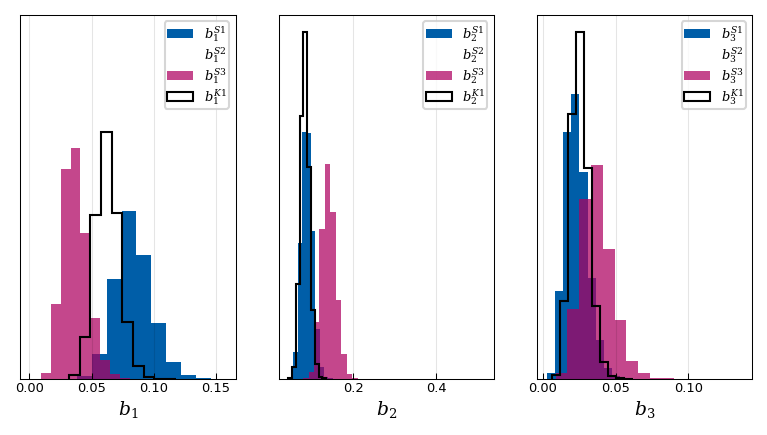

In [41]:
weights = [0.9999983448281871, 2.3570171044287586e-06, 0.7203758077958747]
kwargs = {'density': True, 'histtype': 'stepfilled'}
fix, ax = plt.subplots(1,3, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,0], label = r'$b_1^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[0].hist(samples_s2[:,0], label = r'$b_1^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[0].hist(samples_s3[:,0], label = r'$b_1^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[0].hist(params_cl1[:,0], label = r'$b_1^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[0].set_xlabel(r'$b_1$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,1], label = r'$b_2^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[1].hist(samples_s2[:,1], label = r'$b_2^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[1].hist(samples_s3[:,1], label = r'$b_2^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[1].hist(params_cl1[:,1], label = r'$b_2^{K1}$', color='black', alpha = 1,density = True, histtype = "step")
ax[1].set_xlabel(r'$b_2$')
ax[1].set_yticks([])
ax[1].legend()

ax[2].hist(samples_s1[:,2], label = r'$b_3^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[2].hist(samples_s2[:,2], label = r'$b_3^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[2].hist(samples_s3[:,2], label = r'$b_3^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[2].hist(params_cl1[:,2], label = r'$b_3^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[2].set_xlabel(r'$b_3$')
ax[2].set_yticks([])
ax[2].legend()
plt.show()


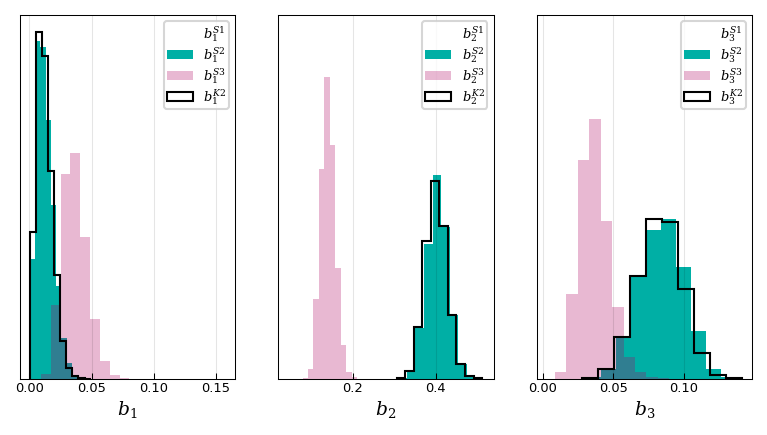

In [42]:
weights = 1-final_weights
kwargs = {'density': True, 'histtype': 'stepfilled'}
fix, ax = plt.subplots(1,3, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,0], label = r'$b_1^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[0].hist(samples_s2[:,0], label = r'$b_1^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[0].hist(samples_s3[:,0], label = r'$b_1^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[0].hist(params_cl2[:,0], label = r'$b_1^{K2}$', color='black', alpha = 1, density = True, histtype = "step")
ax[0].set_xlabel(r'$b_1$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,1], label = r'$b_2^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[1].hist(samples_s2[:,1], label = r'$b_2^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[1].hist(samples_s3[:,1], label = r'$b_2^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[1].hist(params_cl2[:,1], label = r'$b_2^{K2}$', color='black', alpha = 1,density = True, histtype = "step")
ax[1].set_xlabel(r'$b_2$')
ax[1].set_yticks([])
ax[1].legend()

ax[2].hist(samples_s1[:,2], label = r'$b_3^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[2].hist(samples_s2[:,2], label = r'$b_3^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[2].hist(samples_s3[:,2], label = r'$b_3^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[2].hist(params_cl2[:,2], label = r'$b_3^{K2}$', color='black', alpha = 1, density = True, histtype = "step")
ax[2].set_xlabel(r'$b_3$')
ax[2].set_yticks([])
ax[2].legend()
plt.show()


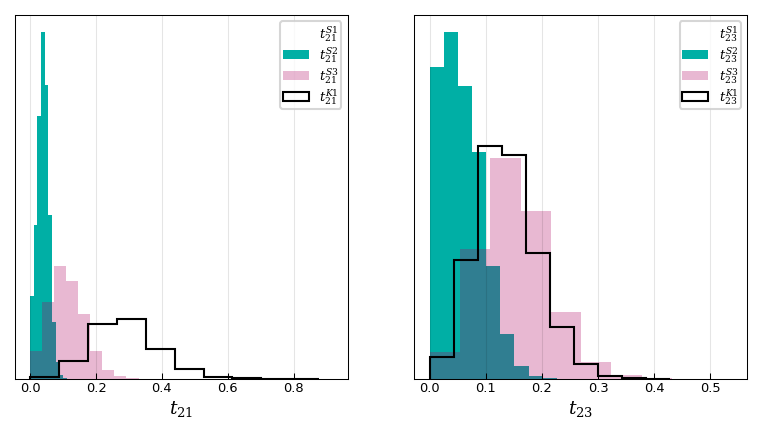

In [43]:
fix, ax = plt.subplots(1,2, figsize = set_size(width='full', ratio = 2))
ax[0].hist(samples_s1[:,3], label = r'$t_{21}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[0].hist(samples_s2[:,3], label = r'$t_{21}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[0].hist(samples_s3[:,3], label = r'$t_{21}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[0].hist(params_cl1[:,3], label = r'$t_{21}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[0].set_xlabel(r'$t_{21}$')
ax[0].set_yticks([])
ax[0].legend()

ax[1].hist(samples_s1[:,4], label = r'$t_{23}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
ax[1].hist(samples_s2[:,4], label = r'$t_{23}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
ax[1].hist(samples_s3[:,4], label = r'$t_{23}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
ax[1].hist(params_cl1[:,4], label = r'$t_{23}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
ax[1].set_xlabel(r'$t_{23}$')
ax[1].set_yticks([])
ax[1].legend()

# ax[2].hist(samples_s1[:,5], label = r'$p_{late}^{S1}$', color= usz_blue, alpha = weights[0], **kwargs)
# ax[2].hist(samples_s2[:,5], label = r'$p_{late}^{S2}$', color=usz_green, alpha = weights[1], **kwargs)
# ax[2].hist(samples_s3[:,5], label = r'$p_{late}^{S3}$', color=usz_red, alpha = weights[2], **kwargs)
# ax[2].hist(params_cl1[:,5], label = r'$p_{late}^{K1}$', color='black', alpha = 1, density = True, histtype = "step")
# ax[2].set_xlabel(r'$p_{late}$')
# ax[2].set_yticks([])
# ax[2].legend()
plt.show()

In [65]:
# Now create the hist charts and then create the dataframes

In [126]:
model = create_models(1, graph_3lnl, ignore_t_stage=True, n_mixture_components=1)
# model.mixture_components = [final_weights[0],  1-final_weights[0]]
d = sdata_ignore_t['S1']
params = samples_s1

S1_df, S1_list = create_obs_pred_df_single(params, model, d, states_all, lnls, 'prevalences/MM_S1_prev_df.csv',n_samples = 700)

model_mm_s1 = create_models(1, graph_3lnl, ignore_t_stage=True, n_mixture_components=2)
model_mm_s1.mixture_components = [final_weights[0],  1-final_weights[0]]
d = sdata_ignore_t['S1']
params = samples_cl0_cl1_rd

S1_MM_df, S1_MM_list = create_obs_pred_df_single(params, model_mm_s1, d, states_all, lnls, 'prevalences/MM_S1_prev_df.csv', n_samples = 700)

In [132]:
def plot_histograms(data_in, states, single_line, loc, bins = 50):

    for state in states:

        data = {k:v[state] for k,v in data_in.items()} 

        fig, axs = plt.subplots(1, figsize=set_size(width='full'), tight_layout = True)
        # fig.suptitle('S2')
        hist_cycl = (
            cycler(histtype=["stepfilled", "step"])
            * cycler(color=list(COLORS.values())) 
        )
        line_cycl = (
            cycler(linestyle=["-", "--"])
            * cycler(color=list(COLORS.values()))
        )
        print("Set up figure")


            
        values = []
        labels = []
        num_matches = []
        num_totals = []
        lines = []
        min_value = 1.
        max_value = 0.
        for label, d in data.items():
            values.append([ds* 100 for ds in d[0]])
            labels.append(label)
            num_matches.append(d[1][0])
            num_totals.append(d[1][1])
            lines.append(100. * num_matches[-1] / num_totals[-1])
            min_value = np.minimum(1, np.min(values))
            max_value = np.maximum(0, np.max(values))


        min_value = np.min(lines, where=~np.isnan(lines), initial=min_value)
        max_value = np.max(lines, where=~np.isnan(lines), initial=max_value)

        hist_kwargs = {
        "bins": np.linspace(min_value, max_value, bins),
        "density": True,
        "alpha": 0.6,
        "linewidth": 2.,
        }

        x = np.linspace(min_value, max_value, 200)
        zipper = zip(values, labels, num_matches, num_totals, hist_cycl, line_cycl)
        # ax = axs[int(np.floor(i/2))][i%2]
        ax = axs
        for i, (vals, label, a, n, hstyle, lstyle) in enumerate(zipper):
            ax.hist(
                vals,
                label=label,
                **hist_kwargs,
                **hstyle
            )
            if not np.isnan(a) and not (i>0 and single_line):
                post = sp.stats.beta.pdf(x / 100., a+1, n-a+1) / 100.
                if single_line:
                    lstyle['color'] = usz_red
                ax.plot(x, post, label=f"{int(a)}/{int(n)}", **lstyle)
            ax.legend()
            ax.set_xlabel("probability [%]")
        ax.set_title(f"{state}", fontsize = 'small', fontweight = 'regular')
        print(f"Plotted {len(values)} histograms")
        plt.savefig(PLOT_PATH / f"hist_{loc}_{state}.png")
        plt.show()

Set up figure
Plotted 2 histograms


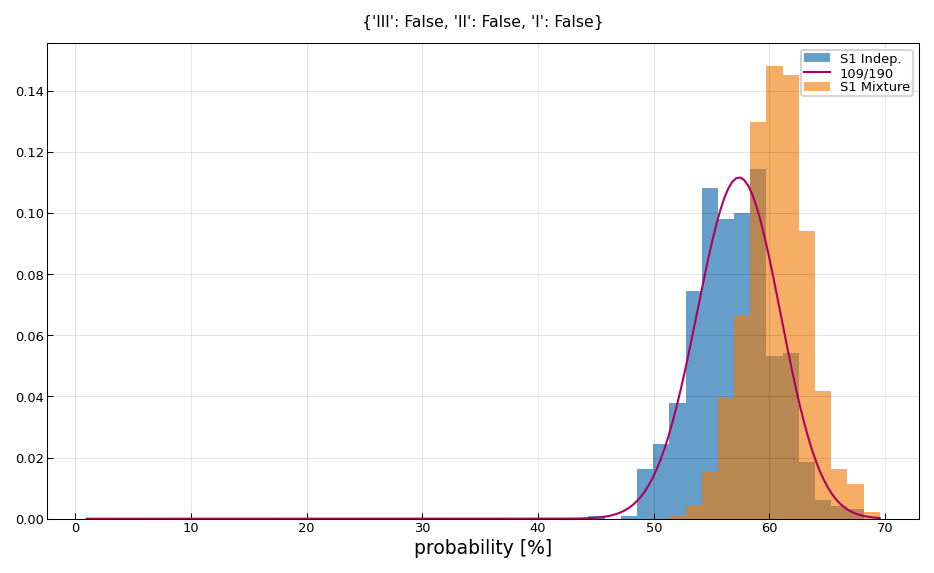

Set up figure
Plotted 2 histograms


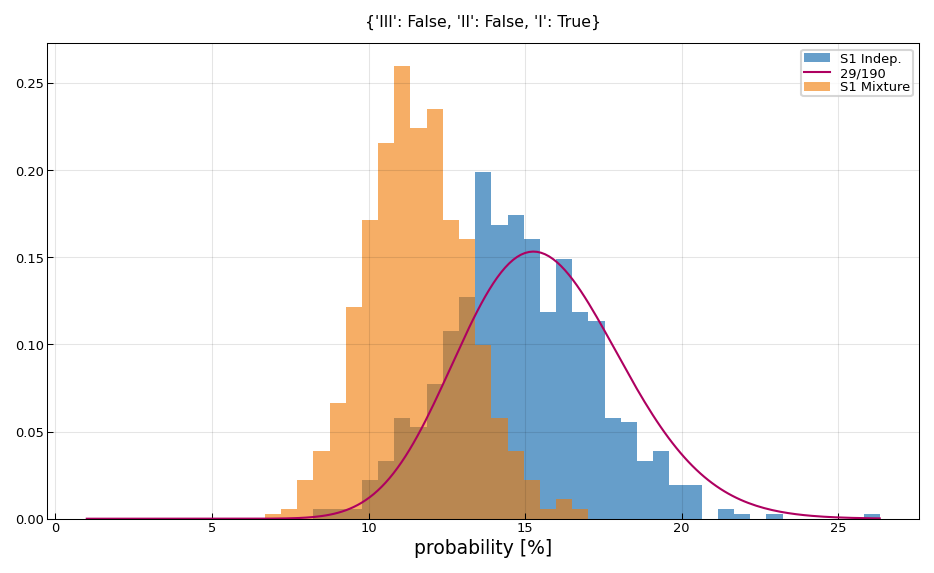

Set up figure
Plotted 2 histograms


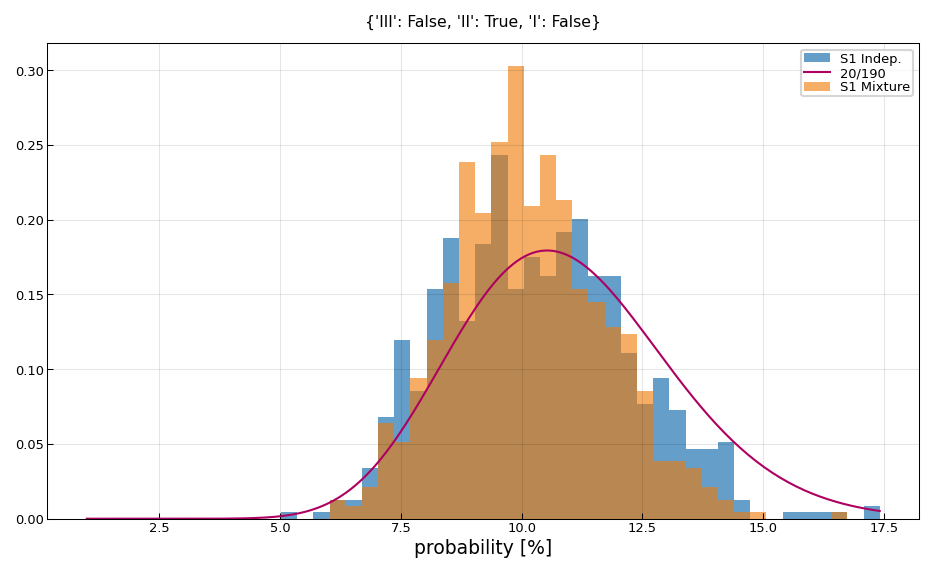

Set up figure
Plotted 2 histograms


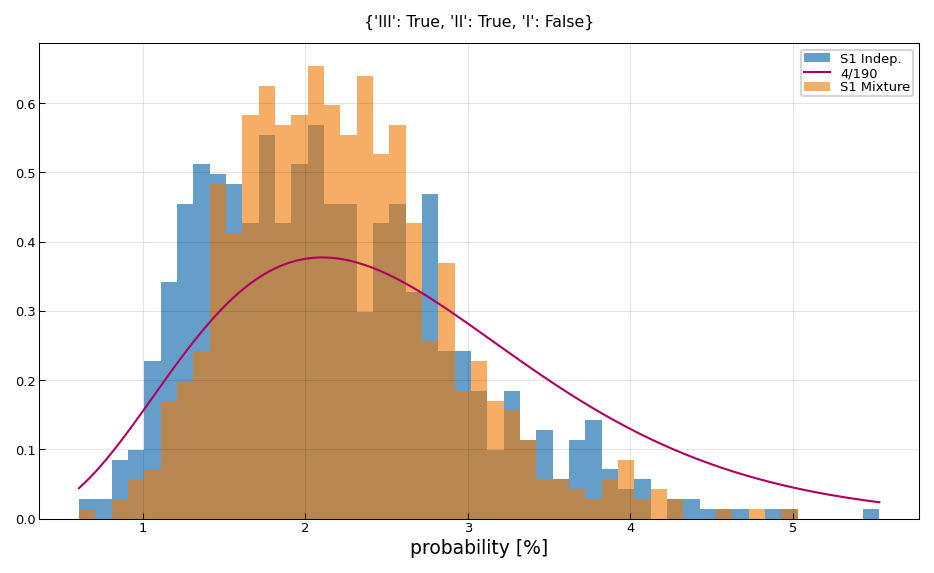

In [133]:
loc = 'S1vsS1MM'
bins =50
single_line = True
t_stage = 'all'
data = {'S1 Indep.': S1_list[3][t_stage], 'S1 Mixture': S1_MM_list[3][t_stage]}
states_for_hists = [
    "{'III': False, 'II': False, 'I': False}",
    "{'III': False, 'II': False, 'I': True}",
    "{'III': False, 'II': True, 'I': False}",
    "{'III': True, 'II': True, 'I': False}"]

plot_histograms(data, states_for_hists, single_line=True, loc=loc)
    
    

In [136]:
model = create_models(1, graph_3lnl, ignore_t_stage=True, n_mixture_components=1)
# model.mixture_components = [final_weights[0],  1-final_weights[0]]
d = sdata_ignore_t['S2']
params = samples_s2

S2_df, S2_list = create_obs_pred_df_single(params, model, d, states_all, lnls, 'prevalences/S2_prev_df.csv',n_samples = 700)

model_mm_s2 = create_models(1, graph_3lnl, ignore_t_stage=True, n_mixture_components=2)
model_mm_s2.mixture_components = [final_weights[1],  1-final_weights[1]]
d = sdata_ignore_t['S2']
params = samples_cl0_cl1_rd

S2_MM_df, S2_MM_list = create_obs_pred_df_single(params, model_mm_s2, d, states_all, lnls, 'prevalences/MM_S2_prev_df.csv', n_samples = 700)

Set up figure
Plotted 2 histograms


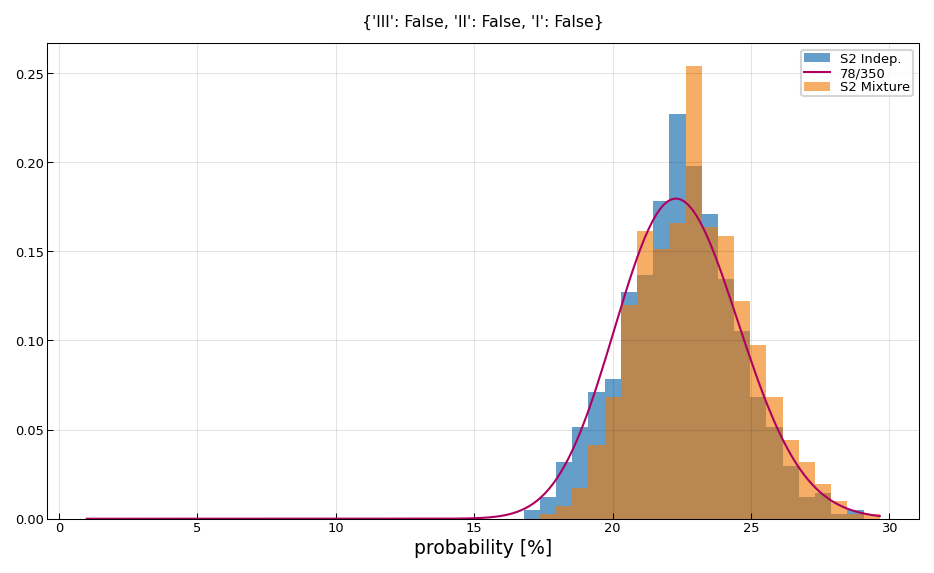

Set up figure
Plotted 2 histograms


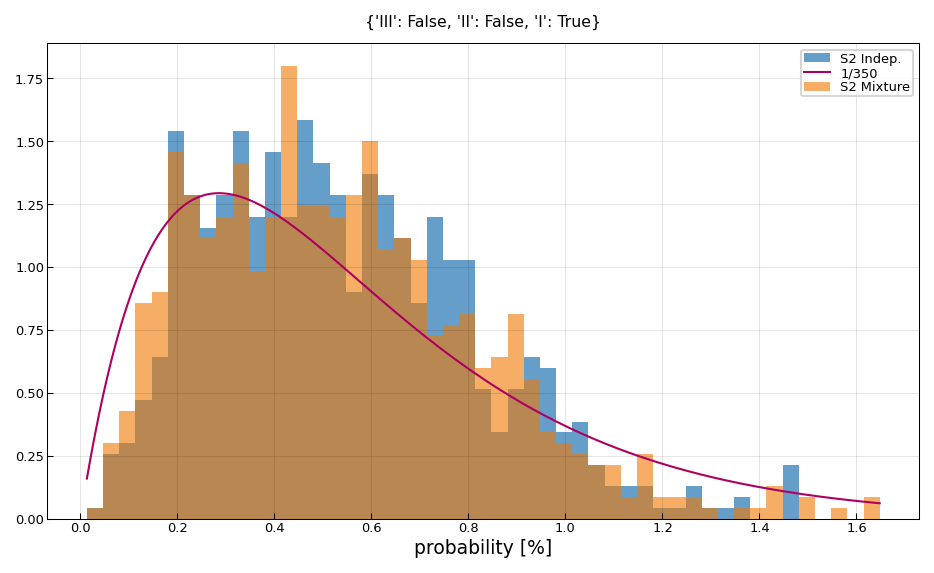

Set up figure
Plotted 2 histograms


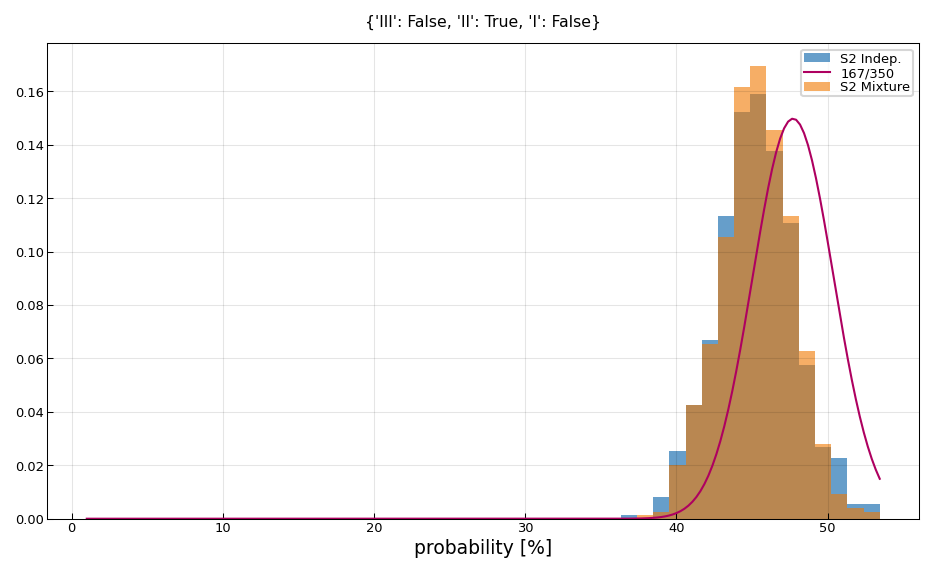

Set up figure
Plotted 2 histograms


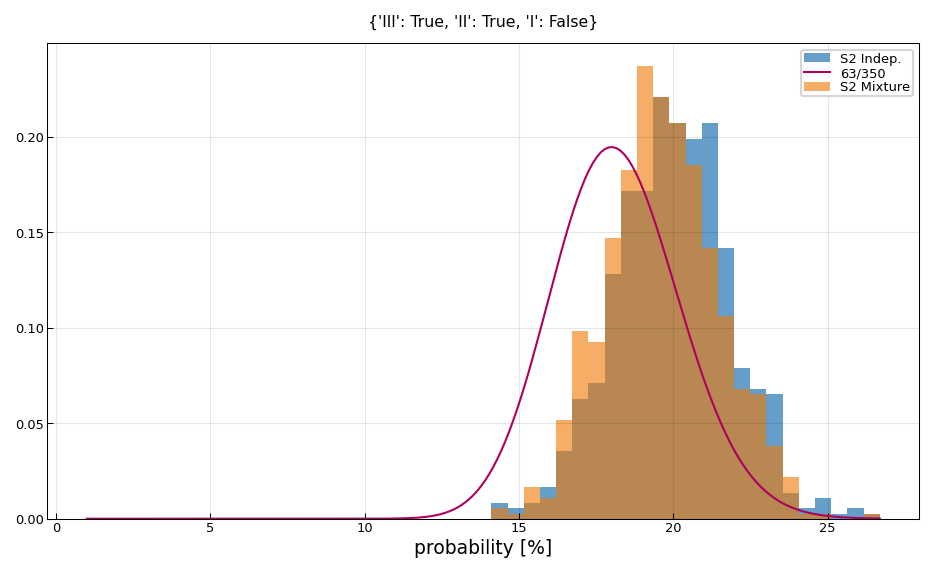

In [137]:
loc = 'S2vsS2MM'
bins =50
single_line = True
t_stage = 'all'
data = {'S2 Indep.': S2_list[3][t_stage], 'S2 Mixture': S2_MM_list[3][t_stage]}
states_for_hists = [
    "{'III': False, 'II': False, 'I': False}",
    "{'III': False, 'II': False, 'I': True}",
    "{'III': False, 'II': True, 'I': False}",
    "{'III': True, 'II': True, 'I': False}"]

plot_histograms(data, states_for_hists, single_line=True, loc=loc)

In [141]:
model = create_models(1, graph_3lnl, ignore_t_stage=True, n_mixture_components=1)
# model.mixture_components = [final_weights[0],  1-final_weights[0]]
d = sdata_ignore_t['S3']
params = samples_s3

S3_df, S3_list = create_obs_pred_df_single(params, model, d, states_all, lnls, 'prevalences/S3_prev_df.csv',n_samples = 700)

model_mm_S3 = create_models(1, graph_3lnl, ignore_t_stage=True, n_mixture_components=2)
model_mm_S3.mixture_components = [final_weights[2],  1-final_weights[2]]
d = sdata_ignore_t['S3']
params = samples_cl0_cl1_rd

S3_MM_df, S3_MM_list = create_obs_pred_df_single(params, model_mm_S3, d, states_all, lnls, 'prevalences/MM_S3_prev_df.csv', n_samples = 700)

Set up figure
Plotted 2 histograms


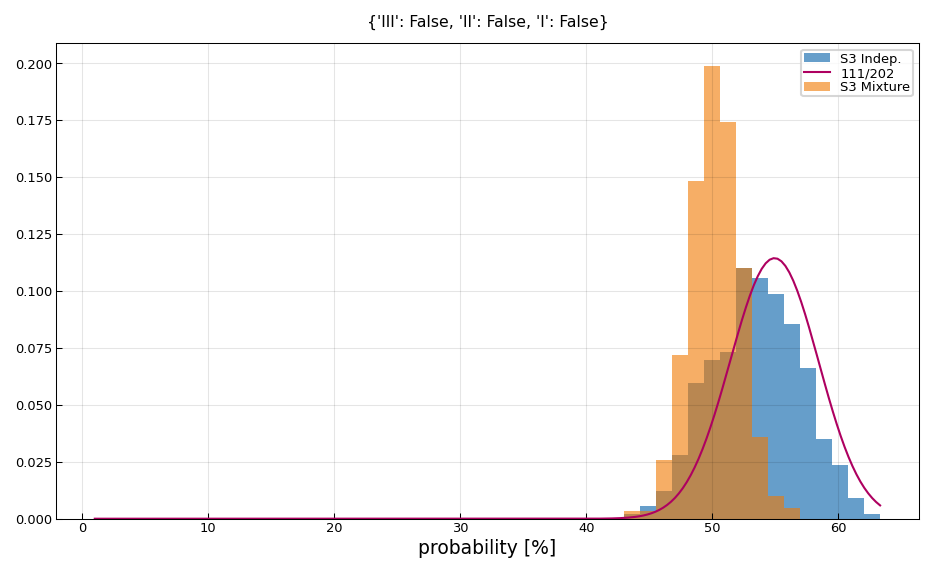

Set up figure
Plotted 2 histograms


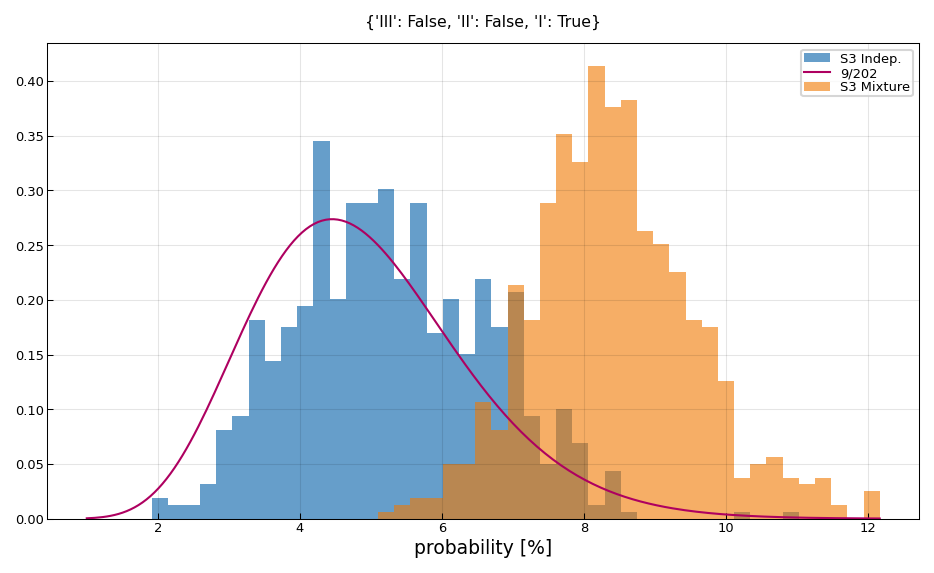

Set up figure
Plotted 2 histograms


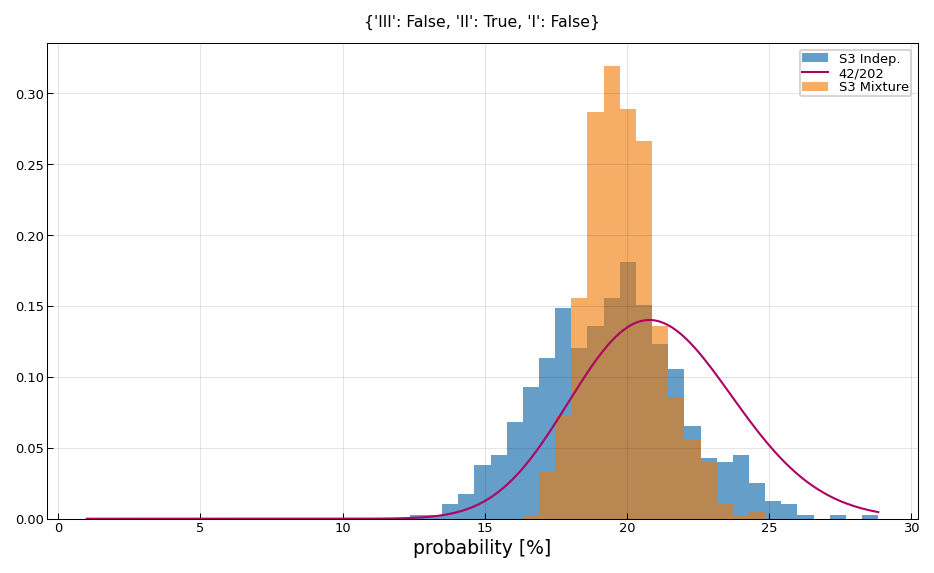

Set up figure
Plotted 2 histograms


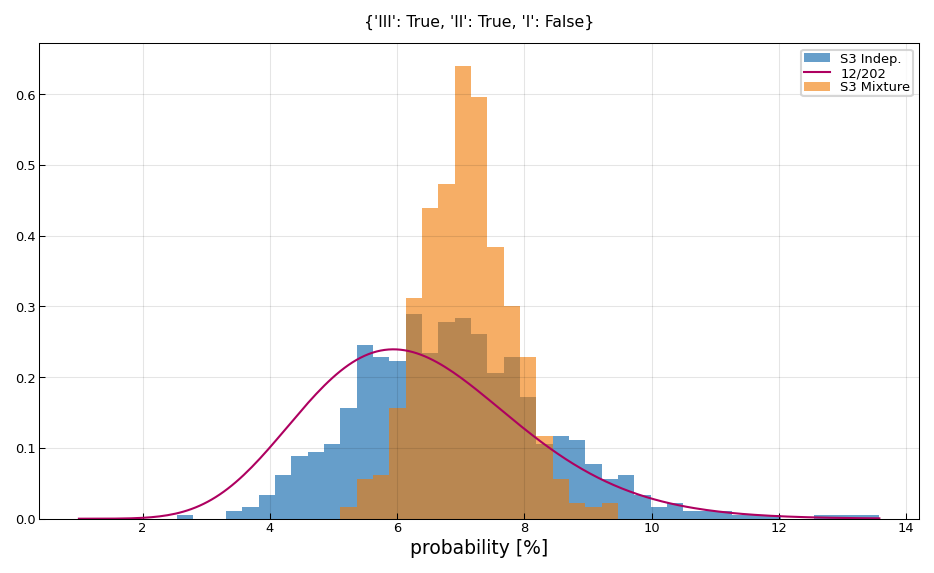

In [142]:
loc = 'S3vsS3MM'
bins =50
single_line = True
t_stage = 'all'
data = {'S3 Indep.': S3_list[3][t_stage], 'S3 Mixture': S3_MM_list[3][t_stage]}
states_for_hists = [
    "{'III': False, 'II': False, 'I': False}",
    "{'III': False, 'II': False, 'I': True}",
    "{'III': False, 'II': True, 'I': False}",
    "{'III': True, 'II': True, 'I': False}"]

plot_histograms(data, states_for_hists, single_line=True, loc=loc)

In [146]:
# create the patterns dataframe
states_all_raw = [
        list(combination) for combination in itertools.product([0, 1], repeat=len(lnls))
    ]
states_all = [
        {lnls[-(i + 1)]: p[i] for i in range(len(lnls))} for p in states_all_raw
    ]
    
data = sdata_ignore_t
samples_list = [samples_s1, samples_s2, samples_s3, [samples_cl0_cl1_rd, [final_weights[0], 1-final_weights[0]]], [samples_cl0_cl1_rd, [final_weights[1], 1-final_weights[1]]], [samples_cl0_cl1_rd, [final_weights[2], 1-final_weights[2]]], samples_s123]
samples_label = ['S1', 'S2', 'S3', 'S1_MM', 'S2_MM', 'S3_MM', 'S123']
data_joined = pd.concat([d for d in data.values()])
data_list = [data['S1'], data['S2'], data['S3'], data['S1'], data['S2'], data['S3'], data_joined ]


for i, samples in enumerate(samples_list):
    if isinstance(samples, list):
        model = create_models(1, graph_3lnl, ignore_t_stage=True, n_mixture_components=2)
        model.mixture_components = samples[1]
        samples = samples[0]
    else:
        model = create_models(1, graph_3lnl, ignore_t_stage=True, n_mixture_components=1)
    s_label =samples_label[i]
    print(s_label)
    d = data_list[i]
    S1_df, S1_list = create_obs_pred_df_single(samples, model, d, states_all, lnls, f"prevalences/{s_label}_inde_t_prev_df.csv")



S1
S2
S3
S1_MM
S2_MM
S3_MM
S123


In [150]:
final_weights

[0.9999983448281871, 2.3570171044287586e-06, 0.7203758077958747]

In [151]:
weight_data = np.array([final_weights, [1-x for x in final_weights]])

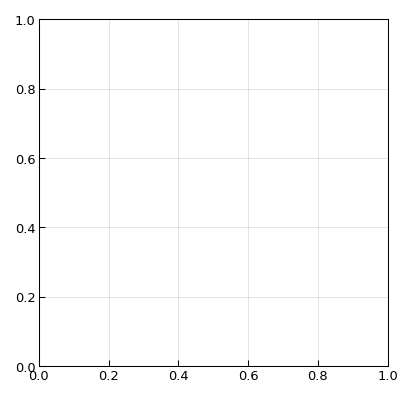

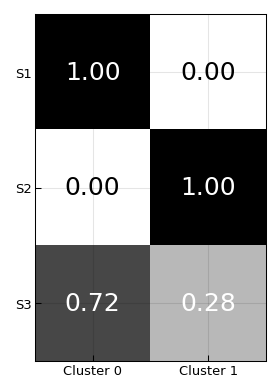

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 3x2 NumPy array with values and opacities
data_w = weight_data.T

# Create a figure and axis
fig, ax = plt.subplots(figsize = (3,3))

# Define a colormap (you can customize the colormap)
cmap = plt.get_cmap('binary')
threshold=0.2
# Create a heatmap with colors determined by the array values
heatmap = ax.imshow(data_w, cmap=cmap)

# Add text labels with values in each cell
for i in range(data_w.shape[0]):
    for j in range(data_w.shape[1]):
        value = data_w[i, j]
        text_color = 'white' if value > threshold else 'black'
        ax.text(j, i, f'{data_w[i, j]:.2f}', ha='center', va='center', color=text_color, fontsize=12)

# Add color bar
# cbar = plt.colorbar(heatmap)

# Set axis labels
ax.set_xticks(np.arange(data_w.shape[1]))
ax.set_yticks(np.arange(data_w.shape[0]))
ax.set_xticklabels(['Cluster 0', 'Cluster 1'])
ax.set_yticklabels(['S1', 'S2', 'S3'])
# ax.set_xlabel('Row')
# ax.set_ylabel('Subsites')

# Show the plot
plt.show()


## Trash

In [20]:
diagnostic_spsn = {
        "max_llh": [1.0, 1.0],
    }


max_t = 10
first_binom_prob = 0.3

models = []

model = lymph.models.Unilateral.binary(graph_dict=graph_lnl_I_II)
model.modalities = diagnostic_spsn

max_time = model.max_time
time_steps = np.arange(max_time+1)
p = 0.3

early_prior = sp.stats.binom.pmf(time_steps, max_time, p)
model.diag_time_dists["early"] = early_prior
if include_late:
    model.diag_time_dists["late"] = late_binomial

model.assign_params(*params_d1)
model.generate_dataset(20, t_dist, column_index_levels='none')

max_llh          tumor    info
      ipsi              1   tumor
         I     II t_stage t_stage
0     True  False       1   early
1     True  False       1   early
2    False  False       1   early
3    False  False       1   early
4    False  False       1   early
5     True  False       1   early
6    False  False       1   early
7    False  False       1   early
8     True  False       1   early
9     True  False       1   early
10    True  False       1   early
11   False  False       1   early
12    True  False       1   early
13    True  False       1   early
14   False  False       1   early
15    True  False       1   early
16   False  False       1   early
17    True  False       1   early
18    True  False       1   early
19    True  False       1   early

In [148]:
d1 = model.generate_dataset(80, t_dist, column_index_levels='non_default')
d1_prev = create_prev_vectors(d1, lnls)

TypeError: 'NoneType' object is not subscriptable

# Try the new EM algorithm:

In [16]:



graph_lnl_I_II = {
            ("tumor", "primary"): ["I", "II"],
            ("lnl", "I"): [],
            ("lnl", "II"): [],
        }

lnls = ['I', 'II']


n_D1 = 500  
n_D2 = 500
n_D12 = 500
r_12 = 0.4 # means 60% D2 and 40% D1 patients.

# Wheter we want the model to incorprate t-catergory late.
include_late = False

# Define spread prob. for HMM model 
params_d1 = [0.4, 0.0]
params_d2 = [0.0, 0.6]

t_dist = {'early': 1, 'late': 0}


# params_d1 = [0.6, 0.0, 0.05, 0.01, 0.1, 0.5]
# params_d2 = [0.0, 0.6, 0.05, 0.01, 0.1, 0.5]
# params_s2 = [0.2, 0.02, 0.05, 0.00, 0.1, 0.5]

data_synth_D1 = create_synth_data(params_d1, params_d2, n_D1, 1, graph_lnl_I_II, t_dist, header="nd")
data_synth_D2 = create_synth_data(params_d1, params_d2, n_D2, 0, graph_lnl_I_II, t_dist, header="nd")
data_synth_D12 = create_synth_data(params_d1, params_d2, n_D12, r_12, graph_lnl_I_II, t_dist, header="nd")

data_synth = {'D1': data_synth_D1, 'D2': data_synth_D2, 'D12': data_synth_D12}
data_synth_D1.head(5)


mixture_labels = np.array([[r"$\pi_{D1, 0}$", r"$\pi_{D1, 1}$"], 
                  [r"$\pi_{D2, 0}$", r"$\pi_{D2, 1}$"],
                  [r"$\pi_{D12, 0}$", r"$\pi_{D12, 1}$"]])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [17]:
def emcee_sampling_ext_em(log_prob_fn, n_params = None, sample_name = None, n_burnin = None, n_step = None, start_with = None, skip_burnin = False, llh_args=None):

    nwalkers = 20*n_params
    burnin = 1000 if n_burnin is None else n_burnin
    nstep = 1000 if n_step is None else n_step
    thin_by = 1
    print(f"Dimension: {n_params} with n walkers: {nwalkers}")
    output_name = sample_name

    if False:
        samples = np.load("samples/expl_oc_hp/em/"+output_name+".npy")
    else:
        created_pool = mp.Pool(os.cpu_count())
        with created_pool as pool:
            if start_with is None:
                starting_points = np.random.uniform(size=(nwalkers, n_params))
            else:
                if np.shape(start_with) != np.shape(np.random.uniform(size=(nwalkers, n_params))):
                    starting_points = np.tile(start_with, (nwalkers, 1))
                else:
                    starting_points = start_with
            print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
            burnin_sampler = emcee.EnsembleSampler(
                nwalkers,
                n_params,
                log_prob_fn,
                args=llh_args,
                pool=pool,
            )
            burnin_results = burnin_sampler.run_mcmc(
                initial_state=starting_points, nsteps=burnin, progress=True
            )
            
            ar = np.mean(burnin_sampler.acceptance_fraction)
            print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
            starting_points = burnin_sampler.get_last_sample()[0]
            # print(f"The shape of the last sample is {starting_points.shape}")
            original_sampler_mp = emcee.EnsembleSampler(
                nwalkers,
                n_params,
                log_prob_fn,
                args=llh_args,
                backend=None,
                pool=pool,
            )
            sampling_results = original_sampler_mp.run_mcmc(
                initial_state=starting_points, nsteps=nstep, progress=True, thin_by = thin_by
            )

        ar = np.mean(original_sampler_mp.acceptance_fraction)
        print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
        samples = original_sampler_mp.get_chain(flat=True)
        log_probs = original_sampler_mp.get_log_prob(flat=True)
        end_point = original_sampler_mp.get_last_sample()[0]
        if output_name is not None:
            np.save(f"./samples/expl_oc_hp/em/" + output_name, samples)
        # plots["acor_times"].append(burnin_info["acor_times"][-1])
        # plots["accept_rates"].append(burnin_info["accept_rates"][-1])
    return samples, end_point, log_probs

In [25]:
def assign_mixing_parameters(z):
    """
    Assigns mixing parameters(latent variables) to models.
    z_s,k, where s is subsite and k is cluster
    Structure [z_11, z_12, .. , z1(K-1), z21, .., z2(K-1), .. , zS(K-1)]
    """
    global MODELS, N_CLUSTERS
    z_grouped = [z[i:i+(N_CLUSTERS-1)] for i in range(0, len(MODELS), N_CLUSTERS-1)]
    z_grouped = [[*zs, 1-np.sum(zs)] for zs in z_grouped]
    for i, model in enumerate(MODELS):
        model.mixture_components = z_grouped[i]

def assign_model_params(theta):
    global MODELS, N_CLUSTERS
    theta_grouped = [list(theta[i:i + N_CLUSTERS]) for i in range(0, len(theta), N_CLUSTERS)]
    for model in MODELS:
        model.assign_params(*theta_grouped)

def llh_z_given_theta(z, inverted = False):
    global MODELS, N_CLUSTERS
    # For now works only with 2 clusters
    for zs in z:
        if zs < 0 or 1 < zs:
            return 10000 if inverted else -10000
    llh = 0
    for i, model in enumerate(MODELS):
        model.mixture_components = [z[i], 1 - z[i]]
        llh += model._hmm_likelihood(log=True)
    if inverted: 
        return -llh
    else:
        return llh

def perform_expectation(theta, step, n_clusters = 2):
    """
    compute p(z|\theta^{i}, x)
    """
    global MODELS, N_CLUSTERS

    # Sampling definitions
    n_burnin = 300
    n_step = 100
    # assign theta to the models (actually, the model can do this already by its own)
    theta_grouped = [[theta[i+j] for j in range(N_CLUSTERS)] for i in range(0, len(theta), N_CLUSTERS)]
    for model in MODELS:
        model.assign_params(*theta_grouped)
    
    n_params = (N_CLUSTERS -1)*len(MODELS)
    z_posterior, last_sample, log_probs = emcee_sampling_ext_em(llh_z_given_theta, n_params, sample_name = f"exp_{step}", n_burnin=n_burnin, n_step=n_step)
    return z_posterior, last_sample, log_probs


def q_function(theta, z_samples, inverted = False):
    global MODELS
    for t in theta:
        if t<0 or 1<t:
            return -10000 if not inverted else 10000
    llh = 0
    # assign_model_params(theta)
    for z_sample in z_samples:
        if len(z_samples)>1:
            assign_mixing_parameters(z_sample)
        for model in MODELS:
            llh += model.likelihood(given_param_args = theta, log=True)
    llh = llh/len(z_samples)
    return (-1)**(inverted) * llh
    

def perform_maximization(z_samples: list[list[float]], step, method = 'MC', minimize_method = "L-BFGS-B"):
    "return theta which maximizes the q function"
    global MODELS
    # Sampling definitions
    n_burnin = 300
    n_step = 100

    n_params = len(MODELS[0].get_params()) * N_CLUSTERS

    if len(z_samples) == 1:
        for z_sample in z_samples:
            assign_mixing_parameters(z_sample)
    if method == 'MC':
        theta_samples, last_theta_samples, log_probs = emcee_sampling_ext_em(q_function, n_params, sample_name = f"maximization_{step}", n_burnin=n_burnin, n_step=n_step, llh_args=[z_samples])
        theta_max = theta_samples[log_probs.argmax()]
        log_probs_max = log_probs.max()
    else:
        initial_guess = np.random.random(n_params)
        param_bounds = [(0,1)]*n_params
        res = minimize(
            q_function,
            initial_guess,
            args=(z_samples, True),
            method=minimize_method,
            bounds=param_bounds,
        )
        theta_max, last_theta_samples = res.x
        log_probs_max = - res.fun
    
    return theta_max, log_probs_max
    

def find_optimal_weights(n_steps = 20, m_imputations = 3):
    global MODELS
    # Initialize the weights
    z_samples_initial = [0.5]*(N_CLUSTERS - 1) * len(MODELS)
    model_params = None # initially set to None
    

    history = {"z_samples" : [],
    "thetas" : [],
    "log_probs" : [],
    "convergence_criteria_values" : [],}
    
    for step in range(n_steps):
        print(f"Step {step} " + "- " * 20)

        if isinstance(m_imputations, int):
            m_imputations_i = m_imputations
        else:
            m_imputations_i = m_imputations(step)
        # Expectation
        if model_params is not None:
            print("Performing expectation: ")
            llhs_e = []
            weights_e = []
            z_posterior, last_sample, log_probs = perform_expectation(model_params, step)

            z_samples = z_posterior[np.random.choice(z_posterior.shape[0], m_imputations_i, replace=False)]

            sys.stdout.write(f"\n yiels {z_samples}")
            np.save(f"./samples/expl_oc_hp/em/" + f"z_samples_{step}", z_samples) 
        else:
            z_samples = [z_samples_initial]  

        # Maximation
        print("Performing maximization: ")

        theta_i, log_prob_i = perform_maximization(z_samples, step, method = 'MLE', minimize_method='SLSQP')

        print(f"Yields: {theta_i}")

        # Store the data in dict
        if step > 0:
            history["z_samples"].append(z_posterior.mean(axis = 0))
        else:
            history["z_samples"].append(np.array(z_samples[0]))
        history["thetas"].append(theta_i)
        history["log_probs"].append(log_prob_i)



        # convergence criteria
        converged = False
        try:
            n_steps_for_convergence = 3
            threshold = 0.015
            last_thetas_array = np.array(history["thetas"][-n_steps_for_convergence:])
            reference_theta_line = last_thetas_array.sum(axis = 0)/n_steps_for_convergence
            squared_differences = (last_thetas_array-reference_theta_line)**2
            history["convergence_criteria_values"].append(np.sqrt(squared_differences.max()))
            converged = (squared_differences<threshold**2).all()
        except:
            history["convergence_criteria_values"].append(0)
            pass
        if converged:
            print(f"Condition Fullfilled at step {step}")
            break
    return z_samples, theta_i, history

In [31]:
global MODELS, N_CLUSTERS

n_subsites = 3
n_clusters = 2

models_MM = create_models(n_subsites, graph_3lnl, ignore_t_stage=True, n_mixture_components=n_clusters)
for i, (k,v) in enumerate(sdata_ignore_t.items()):
    models_MM[i].load_patient_data(v, mapping= lambda x: 'all')
    print(f"Loaded patients for ICD {k} (total {len(v)} patients)")

MODELS = models_MM
N_CLUSTERS = n_clusters

TypeError: create_models() got an unexpected keyword argument 'ignore_t_stage'

In [27]:
m_imputations_fun = lambda x: int(5/(20)**2*x**2 + 1)

z_samples, theta_samples, history = find_optimal_weights(m_imputations = m_imputations_fun, n_steps = 20)

Step 0 - - - - - - - - - - - - - - - - - - - - 
Performing maximization: 


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

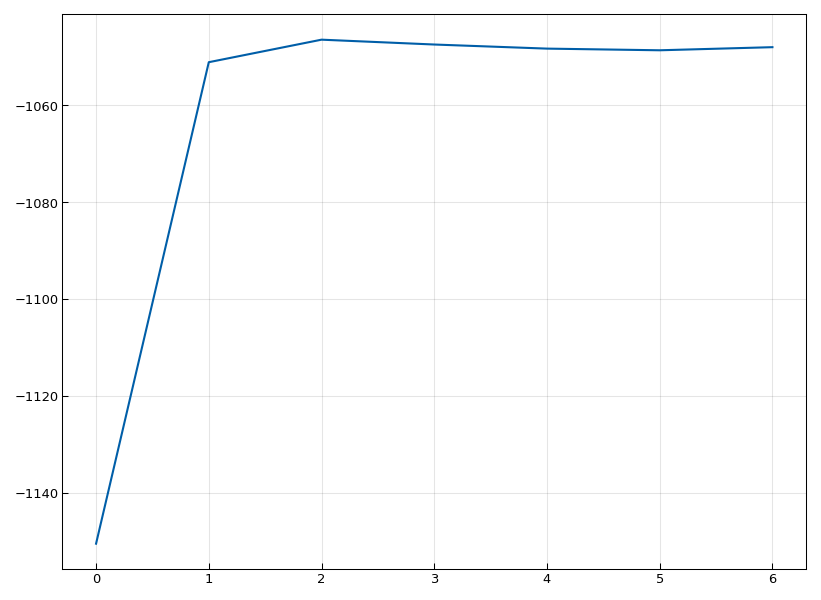

In [117]:
plt.plot(range(len(history["log_probs"])), history["log_probs"])

In [128]:
def plot_history(history):

    weights_hist = history["z_samples"]
    model_params_hist = history["thetas"]
    llh_hist = history["log_probs"]
    c_r = history["convergence_criteria_values"]

    fig, axs = plt.subplots(2,2, figsize = set_size(width='full'))
    # Inspect llh
    axs[0][0].plot(range(len(llh_hist)), llh_hist, label = 'Likelihood')
    axs[0][0].set_xlabel('Steps')
    axs[0][0].set_ylabel('log lh')
    ax = axs[0][1]
    ax.plot(range(len(weights_hist)), [w[0] for w in weights_hist], label = r'$\pi_{S1,0}$')
    ax.plot(range(len(weights_hist)), [w[1] for w in weights_hist], label = r'$\pi_{S2,0}$')
    ax.plot(range(len(weights_hist)), [w[2] for w in weights_hist], label = r'$\pi_{S3,0}$')
    ax.set_xlabel('Steps')
    ax.set_ylabel('weights')
    ax.legend()

    # Inspect llh
    ax = axs[1,0]
    label_names_1 = [r'$b_1^{1}$', r'$b_2^{1}$', r'$b_3^{1}$', r'$t_{21}^{1}$', r'$t_{23}^{1}$', r'$p_{late}^{1}$']
    label_names_2 = [r'$b_1^{2}$', r'$b_2^{2}$', r'$b_3^{2}$', r'$t_{21}^{2}$', r'$t_{23}^{2}$', r'$p_{late}^{2}$']

    ax.plot(range(len(model_params_hist)), [w[0] for w in model_params_hist], label = r'$b_1^{1}$')
    ax.plot(range(len(model_params_hist)), [w[1] for w in model_params_hist], label = r'$b_1^{2}$')
    ax.plot(range(len(model_params_hist)), [w[2] for w in model_params_hist], label = r'$b_2^{1}$')
    ax.plot(range(len(model_params_hist)), [w[3] for w in model_params_hist], label = r'$b_2^{2}$')
    ax.plot(range(len(model_params_hist)), [w[4] for w in model_params_hist], label = r'$b_3^{1}$')
    ax.plot(range(len(model_params_hist)), [w[5] for w in model_params_hist], label = r'$b_3^{2}$')

    ax.set_xlabel('Steps')
    ax.set_ylabel('model params')
    ax.legend()

        # Inspect llh
    ax = axs[1][1]
    label_names_1 = [r'$b_1^{1}$', r'$b_2^{1}$', r'$b_3^{1}$', r'$t_{21}^{1}$', r'$t_{23}^{1}$']
    label_names_2 = [r'$b_1^{2}$', r'$b_2^{2}$', r'$b_3^{2}$', r'$t_{21}^{2}$', r'$t_{23}^{2}$']
    ax.plot(range(len(model_params_hist)), [w[6] for w in model_params_hist], label = r'$t_{21}^{1}$')
    ax.plot(range(len(model_params_hist)), [w[7] for w in model_params_hist], label = r'$t_{21}^{2}$')
    ax.plot(range(len(model_params_hist)), [w[8] for w in model_params_hist], label = r'$t_{23}^{1}$')
    ax.plot(range(len(model_params_hist)), [w[9] for w in model_params_hist], label = r'$t_{23}^{2}$')
    ax.set_xlabel('Steps')
    ax.set_ylabel('model params')
    ax.legend()
    plt.show()


In [126]:
z_samples, theta_samples, history = find_optimal_weights(m_imputations = 1, n_steps = 10, model_params=history["thetas"][-1])

Step 0 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60
Start Burning (steps = 300) with 8 cores


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:56<00:00,  5.34it/s]


the HMM sampler for model 01 accepted 57.86 % of samples.


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


the HMM sampler for model accepted 60.27 % of samples.

 yiels [[9.37619745e-01 9.03457271e-04 5.87936055e-01]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:42<00:00,  2.92it/s]


the HMM sampler for model 01 accepted 39.34 % of samples.


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]

the HMM sampler for model accepted 40.25 % of samples.
         Yields: [0.07065398 0.01521162 0.07154267 0.3997588  0.02806528 0.07511188
 0.49191966 0.04366826 0.1831434  0.08497119]
Step 1 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:55<00:00,  5.45it/s]


the HMM sampler for model 01 accepted 56.88 % of samples.


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


the HMM sampler for model accepted 57.50 % of samples.

 yiels [[0.98622719 0.00278019 0.6534479 ]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:40<00:00,  2.98it/s]


the HMM sampler for model 01 accepted 38.58 % of samples.


100%|██████████| 100/100 [00:34<00:00,  2.92it/s]

the HMM sampler for model accepted 40.55 % of samples.
         Yields: [0.0823525  0.02311718 0.08576989 0.43523621 0.037794   0.08036596
 0.42247344 0.0586025  0.25649926 0.09192318]
Step 2 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:54<00:00,  5.48it/s]


the HMM sampler for model 01 accepted 55.88 % of samples.


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


the HMM sampler for model accepted 58.10 % of samples.

 yiels [[0.99251869 0.01016419 0.82840715]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:42<00:00,  2.93it/s]


the HMM sampler for model 01 accepted 39.05 % of samples.


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]

the HMM sampler for model accepted 39.28 % of samples.
         Yields: [0.06225496 0.01477915 0.09596077 0.43184302 0.02786768 0.08754926
 0.2946003  0.04528616 0.16399518 0.06414323]
Step 3 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:55<00:00,  5.41it/s]


the HMM sampler for model 01 accepted 55.60 % of samples.


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


the HMM sampler for model accepted 57.37 % of samples.

 yiels [[0.94577639 0.01041952 0.74819872]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:42<00:00,  2.92it/s]


the HMM sampler for model 01 accepted 38.73 % of samples.


100%|██████████| 100/100 [00:38<00:00,  2.61it/s]

the HMM sampler for model accepted 39.00 % of samples.
         Yields: [0.06372048 0.01190584 0.0787804  0.42127342 0.02762935 0.08679588
 0.36988735 0.04322456 0.15712234 0.05768032]
Step 4 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:55<00:00,  5.39it/s]


the HMM sampler for model 01 accepted 57.58 % of samples.


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


the HMM sampler for model accepted 59.52 % of samples.

 yiels [[0.97269715 0.03018496 0.68113803]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:37<00:00,  3.08it/s]


the HMM sampler for model 01 accepted 38.20 % of samples.


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]

the HMM sampler for model accepted 38.46 % of samples.
         Yields: [0.06596659 0.0129493  0.08204518 0.40922845 0.02875368 0.08377519
 0.43418862 0.04855635 0.18969942 0.07502314]
Step 5 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:53<00:00,  5.60it/s]


the HMM sampler for model 01 accepted 56.82 % of samples.


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


the HMM sampler for model accepted 59.80 % of samples.

 yiels [[0.97353877 0.01784751 0.7406616 ]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:37<00:00,  3.07it/s]


the HMM sampler for model 01 accepted 38.89 % of samples.


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]

the HMM sampler for model accepted 39.91 % of samples.
         Yields: [0.0728726  0.01683128 0.0802362  0.4110325  0.03037957 0.08212822
 0.39881208 0.03928729 0.19372664 0.08475213]
Step 6 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:53<00:00,  5.62it/s]


the HMM sampler for model 01 accepted 56.51 % of samples.


100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


the HMM sampler for model accepted 58.50 % of samples.

 yiels [[0.95640486 0.04221662 0.65425463]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:37<00:00,  3.08it/s]


the HMM sampler for model 01 accepted 38.51 % of samples.


100%|██████████| 100/100 [00:30<00:00,  3.23it/s]

the HMM sampler for model accepted 37.99 % of samples.
         Yields: [0.06925628 0.01102065 0.07532856 0.44199331 0.03031562 0.08199108
 0.47477786 0.05069796 0.16474259 0.08773463]
Step 7 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:01<00:00,  4.86it/s]


the HMM sampler for model 01 accepted 58.53 % of samples.


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]

the HMM sampler for model accepted 61.67 % of samples.

 yiels [[0.88507425 0.00768555 0.8043455 ]]Performing maximization: 
Dimension: 10 with n walkers: 200


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:43<00:00,  2.89it/s]


the HMM sampler for model 01 accepted 38.53 % of samples.


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]

the HMM sampler for model accepted 39.12 % of samples.
         Yields: [0.06827207 0.01309541 0.07566294 0.42221146 0.02843768 0.08157414
 0.33010133 0.0438982  0.17881656 0.07288454]
Step 8 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:52<00:00,  5.77it/s]


the HMM sampler for model 01 accepted 56.42 % of samples.


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


the HMM sampler for model accepted 59.83 % of samples.

 yiels [[0.97769696 0.00344188 0.69604835]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:38<00:00,  3.05it/s]


the HMM sampler for model 01 accepted 38.99 % of samples.


100%|██████████| 100/100 [00:32<00:00,  3.10it/s]

the HMM sampler for model accepted 39.25 % of samples.
         Yields: [0.06801535 0.01341712 0.08271882 0.41069771 0.02875302 0.07722523
 0.3853381  0.04456747 0.1652952  0.07818485]
Step 9 - - - - - - - - - - - - - - - - - - - - 
Performing expectation: Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:52<00:00,  5.69it/s]


the HMM sampler for model 01 accepted 56.19 % of samples.


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


the HMM sampler for model accepted 59.03 % of samples.

 yiels [[0.92063336 0.02757937 0.77326763]]Performing maximization: 
Dimension: 10 with n walkers: 200
Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [01:52<00:00,  2.66it/s]


the HMM sampler for model 01 accepted 38.24 % of samples.


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]

the HMM sampler for model accepted 38.39 % of samples.
         Yields: [0.06457199 0.01192108 0.080698   0.42444782 0.02920997 0.08394025
 0.47665294 0.04557271 0.18590691 0.06783481]


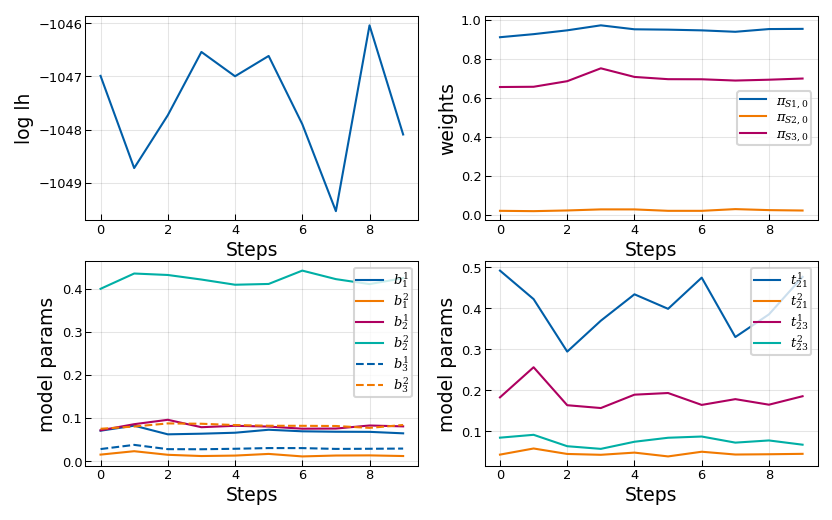

In [130]:
plot_history(history)

In [22]:
# the em sampler is somehow wrong

In [98]:
sample_name = f"cl0_cl1_s1s2s3_2123_late"
samples_cl0_cl1_rd = np.load("samples/"+sample_name+".npy")

In [99]:
theta_mean_opt = samples_cl0_cl1_rd.mean(axis = 0)
theta_mean_opt

array([0.01038946, 0.04635071, 0.37176134, 0.0592309 , 0.07698589,
       0.01804053, 0.04042822, 0.17103857, 0.05231924, 0.07636865,
       0.38930733, 0.61316532])

In [100]:
# Now we check if the expectation step is correct:

In [113]:
z_posterior, last_sample, log_probs = perform_expectation(theta_mean_opt, None)

Dimension: 3 with n walkers: 60


Start Burning (steps = 300) with 8 cores


100%|██████████| 300/300 [00:43<00:00,  6.88it/s]


the HMM sampler for model 01 accepted 56.14 % of samples.


100%|██████████| 100/100 [00:13<00:00,  7.38it/s]

the HMM sampler for model accepted 58.72 % of samples.


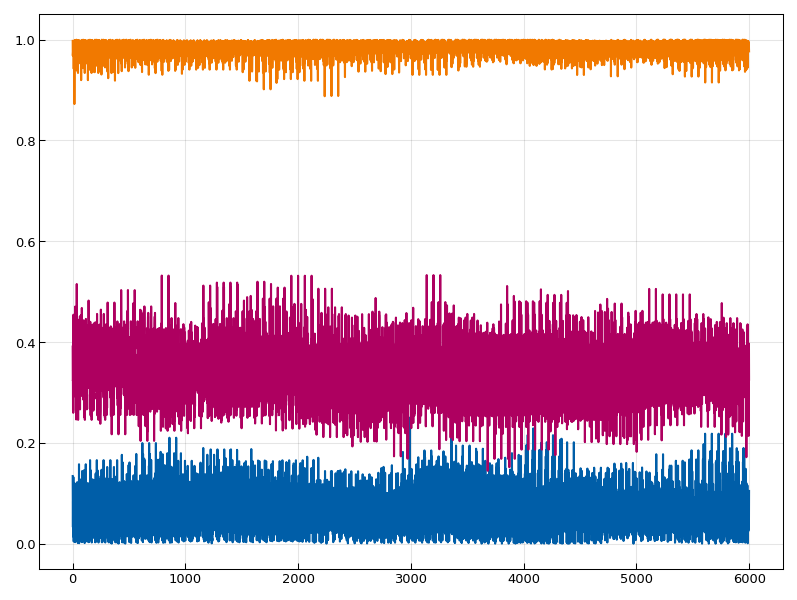

In [114]:
plt.plot(range(len(z_posterior)), z_posterior)